In [1]:
import datetime
import sys
sys.path.append("..")
import random
from numpy.random import default_rng
from annoy import AnnoyIndex
import torch.autograd as autograd
from typing import List
import anndata
from functools import partial
from copy import deepcopy

from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from sklearn.metrics import (adjusted_rand_score, calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
import math
import utils
from sklearn import metrics
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
import colorcet as cc

import math
from scipy import sparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import sample
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.utils.spectral_norm as spectral_norm
import torch.nn.utils.weight_norm as weight_norm
import torch.optim.lr_scheduler as lr_scheduler
import scanpy as sc
import time
import os
from scipy import sparse
from adabelief_pytorch import AdaBelief
import torch.quantization

import gzip

from torch.utils.data import WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler
import gc

torch.cuda.set_device(0)

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

from anndata import AnnData
    
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# import warnings
# warnings.filterwarnings("ignore")

path= "../"

torch.autograd.set_detect_anomaly(True)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

########## NEURAL NETWORK UTILITY ##########
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

CPUTensor =  torch.FloatTensor

In [2]:
# Enable autocompletion
%config Completer.use_jedi = False

In [4]:
sc.settings.verbosity = 1

sc.settings.set_figure_params(
    dpi=300, frameon=False, figsize=(3, 3), facecolor='white')

In [6]:
import scipy.io as sio
import scipy.sparse as sp
import h5py

In [7]:
import sklearn
sklearn.__version__

'1.3.2'

## Reading the data

In [8]:
adata = sc.read_h5ad("data/lupus/kang_raw.h5ad")
adata = adata[adata.obs.multiplets == "singlet"].copy()

In [9]:
adata.obs

sample_id condition  cluster        cell_type multiplets  \
barcode                                                                     
AAACATACATTTCC-1      1016      ctrl        9  CD14+ Monocytes    singlet   
AAACATACCAGAAA-1      1256      ctrl        9  CD14+ Monocytes    singlet   
AAACATACCATGCA-1      1488      ctrl        3      CD4 T cells    singlet   
AAACATACCTCGCT-1      1256      ctrl        9  CD14+ Monocytes    singlet   
AAACATACCTGGTA-1      1039      ctrl        4  Dendritic cells    singlet   
...                    ...       ...      ...              ...        ...   
TTTGCATGCCTGAA-1      1244      stim        6      CD4 T cells    singlet   
TTTGCATGCCTGTC-1      1256      stim        4          B cells    singlet   
TTTGCATGCTAAGC-1       107      stim        6      CD4 T cells    singlet   
TTTGCATGGGACGA-1      1488      stim        6      CD4 T cells    singlet   
TTTGCATGTCTTAC-1      1016      stim        5      CD4 T cells    singlet   

                  n_genes  
barcode                    
AAACATACATTTCC-1      878  
AAACATACCAGAAA-1      713  
AAACATACCATGCA-1      337  
AAACATACCTCGCT-1      850  
AAACATACCTGGTA-1     1111  
...                   ...  
TTTGCATGCCTGAA-1      468  
TTTGCATGCCTGTC-1      819  
TTTGCATGCTAAGC-1      523  
TTTGCATGGGACGA-1      503  
TTTGCATGTCTTAC-1      421  

[24483 rows x 6 columns]

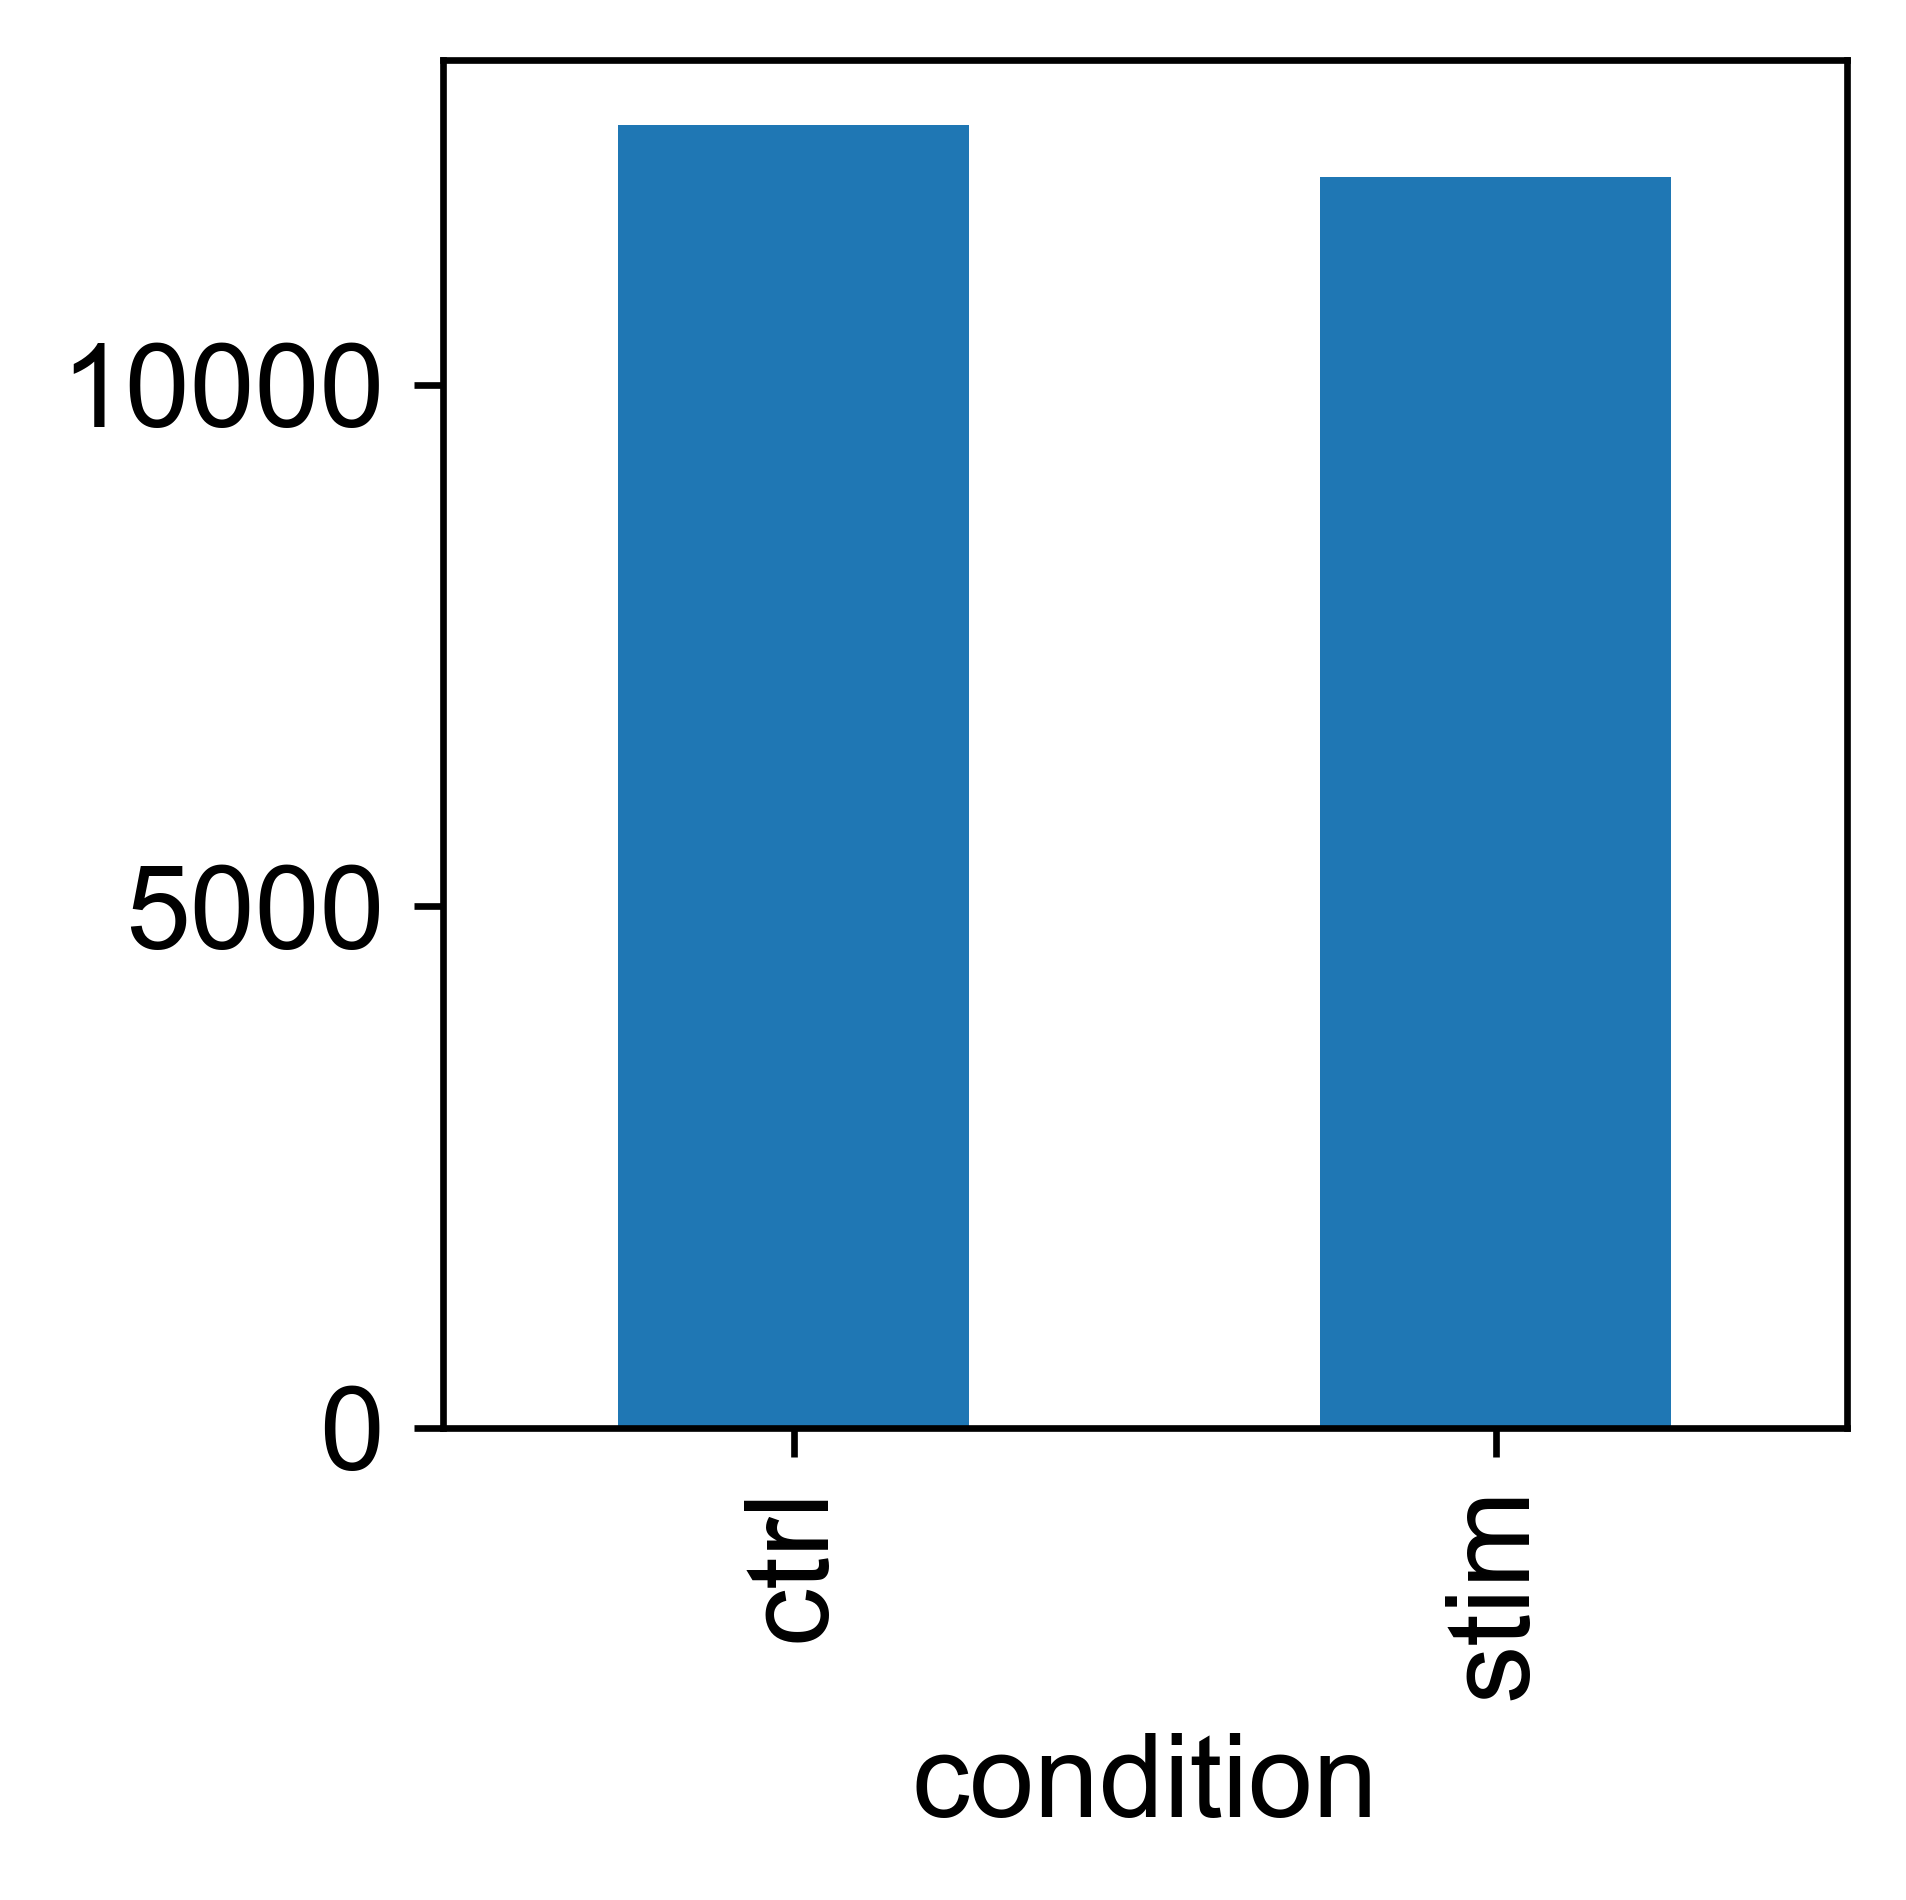

In [10]:
adata.obs.groupby(["condition"]).size().plot(kind="bar")
plt.grid(False)

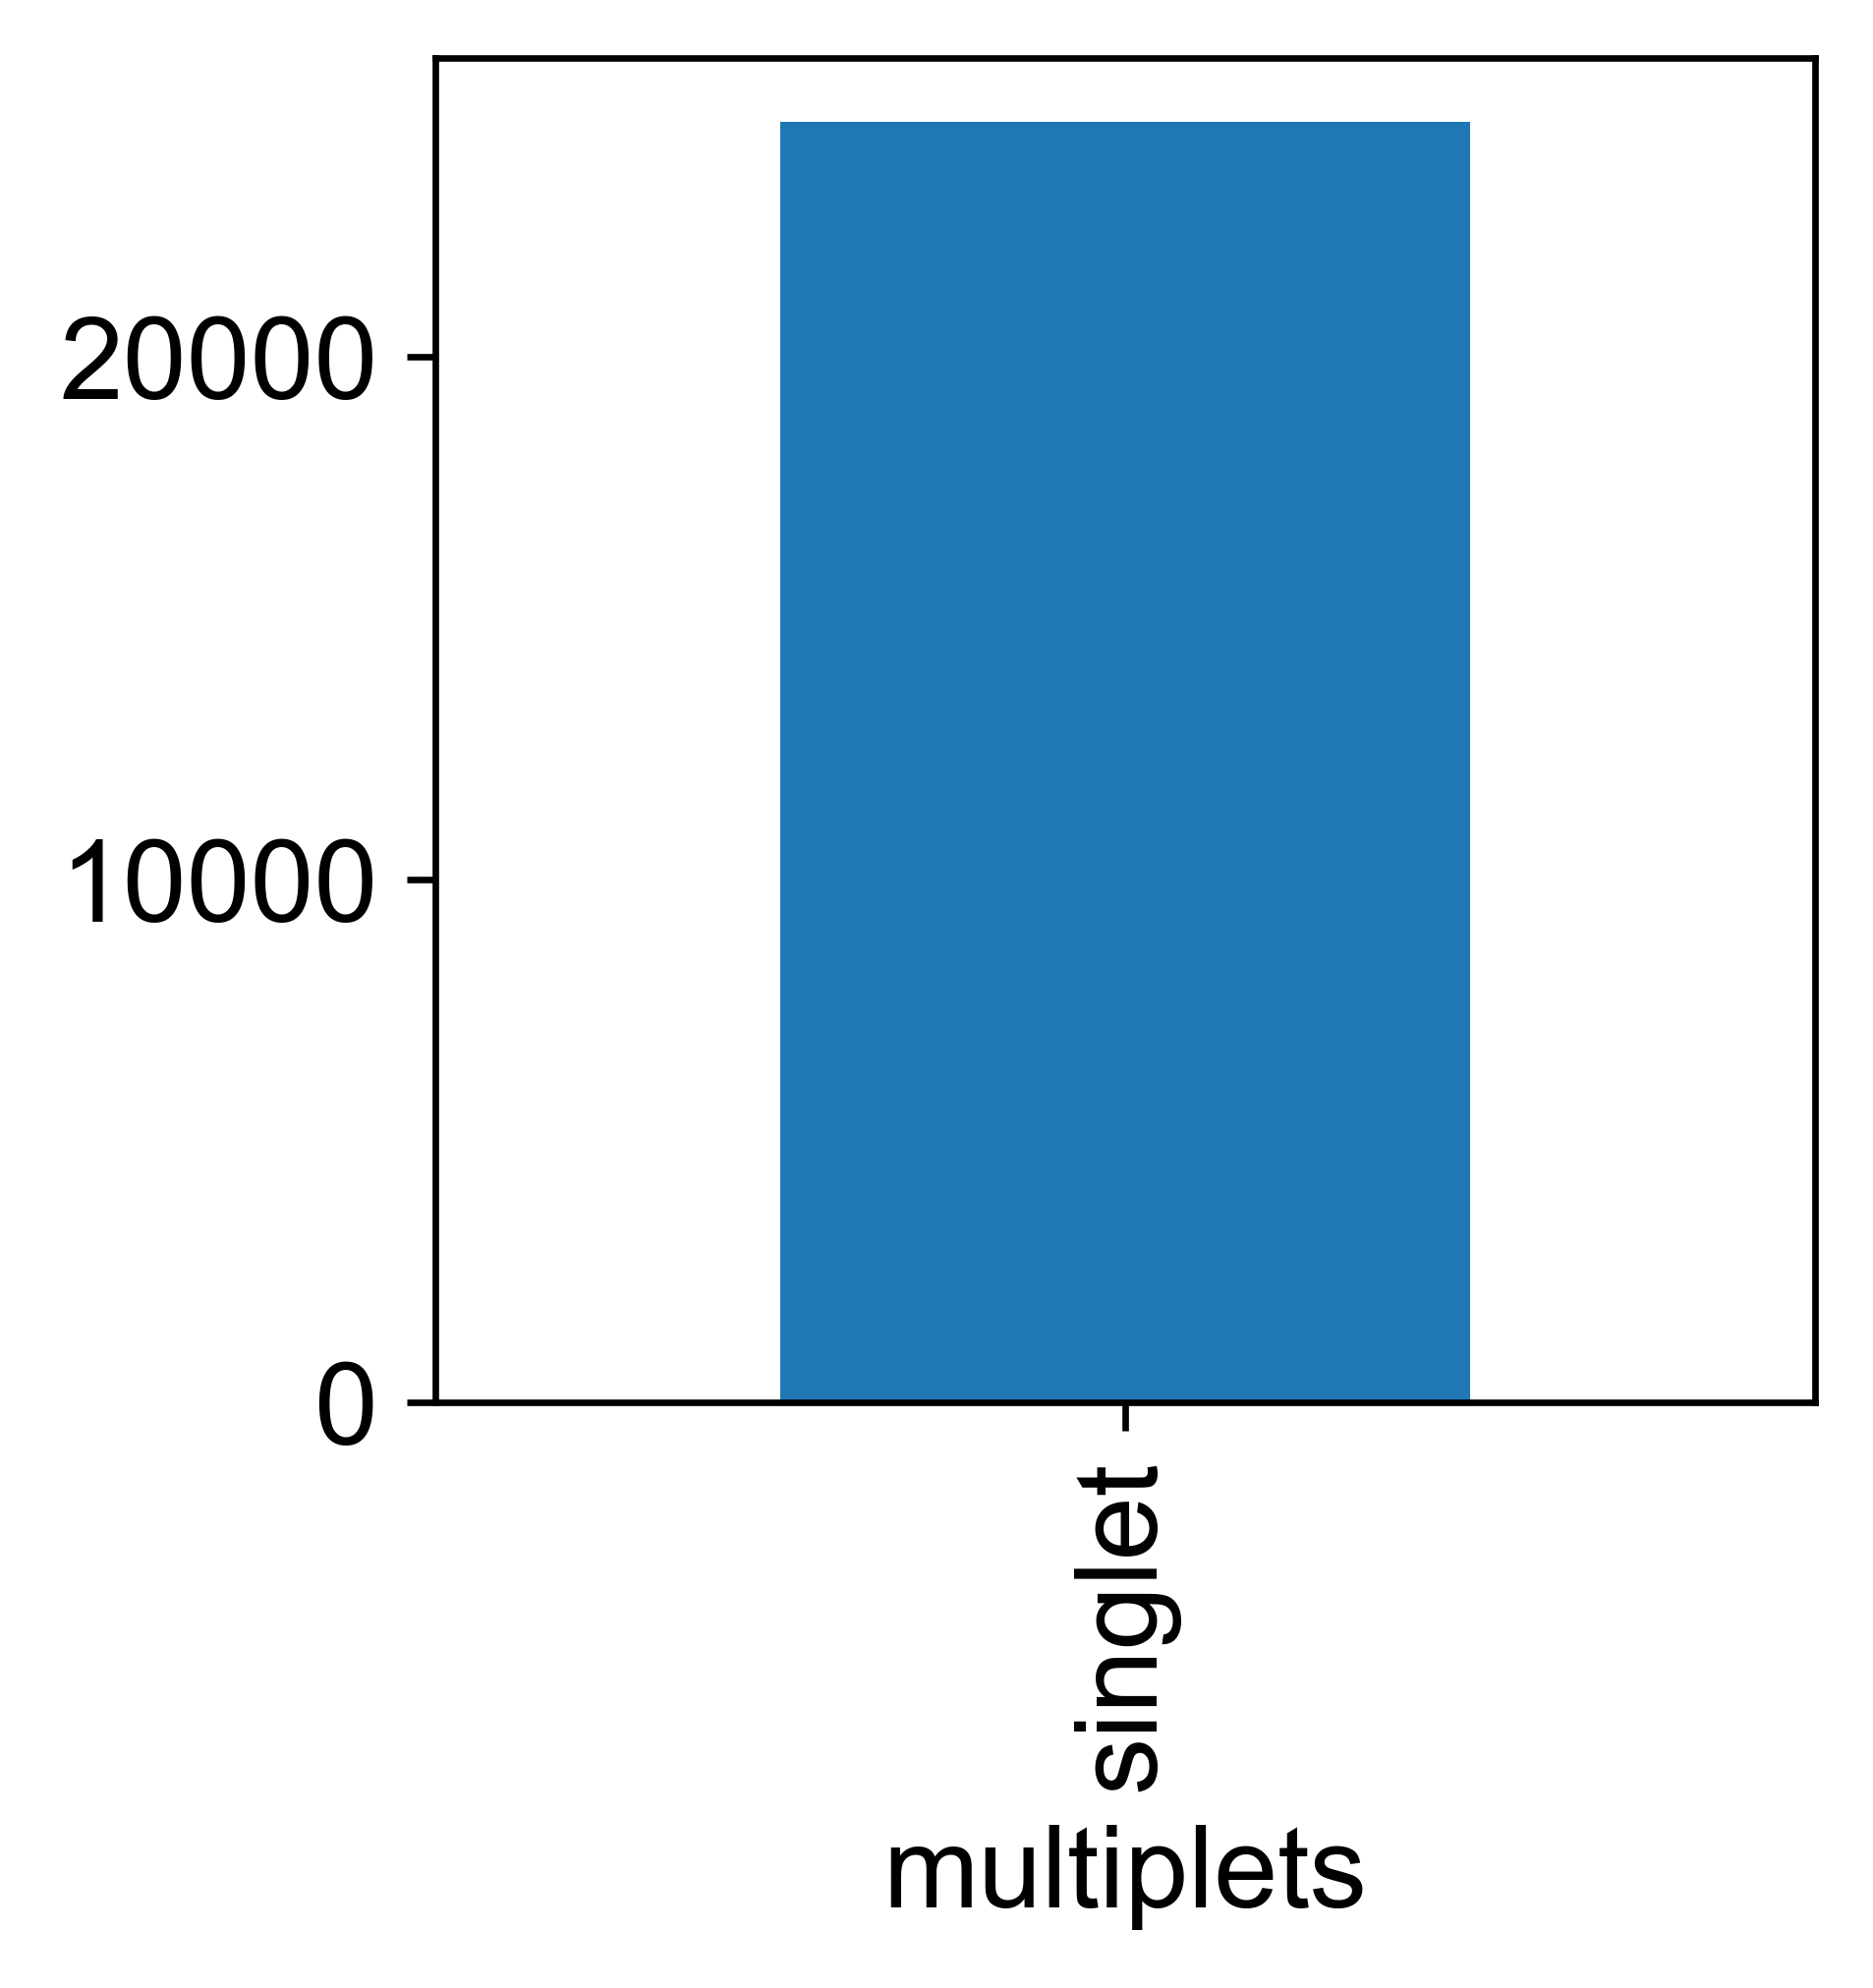

In [11]:
adata.obs.groupby(["multiplets"]).size().plot(kind="bar")
plt.grid(False)

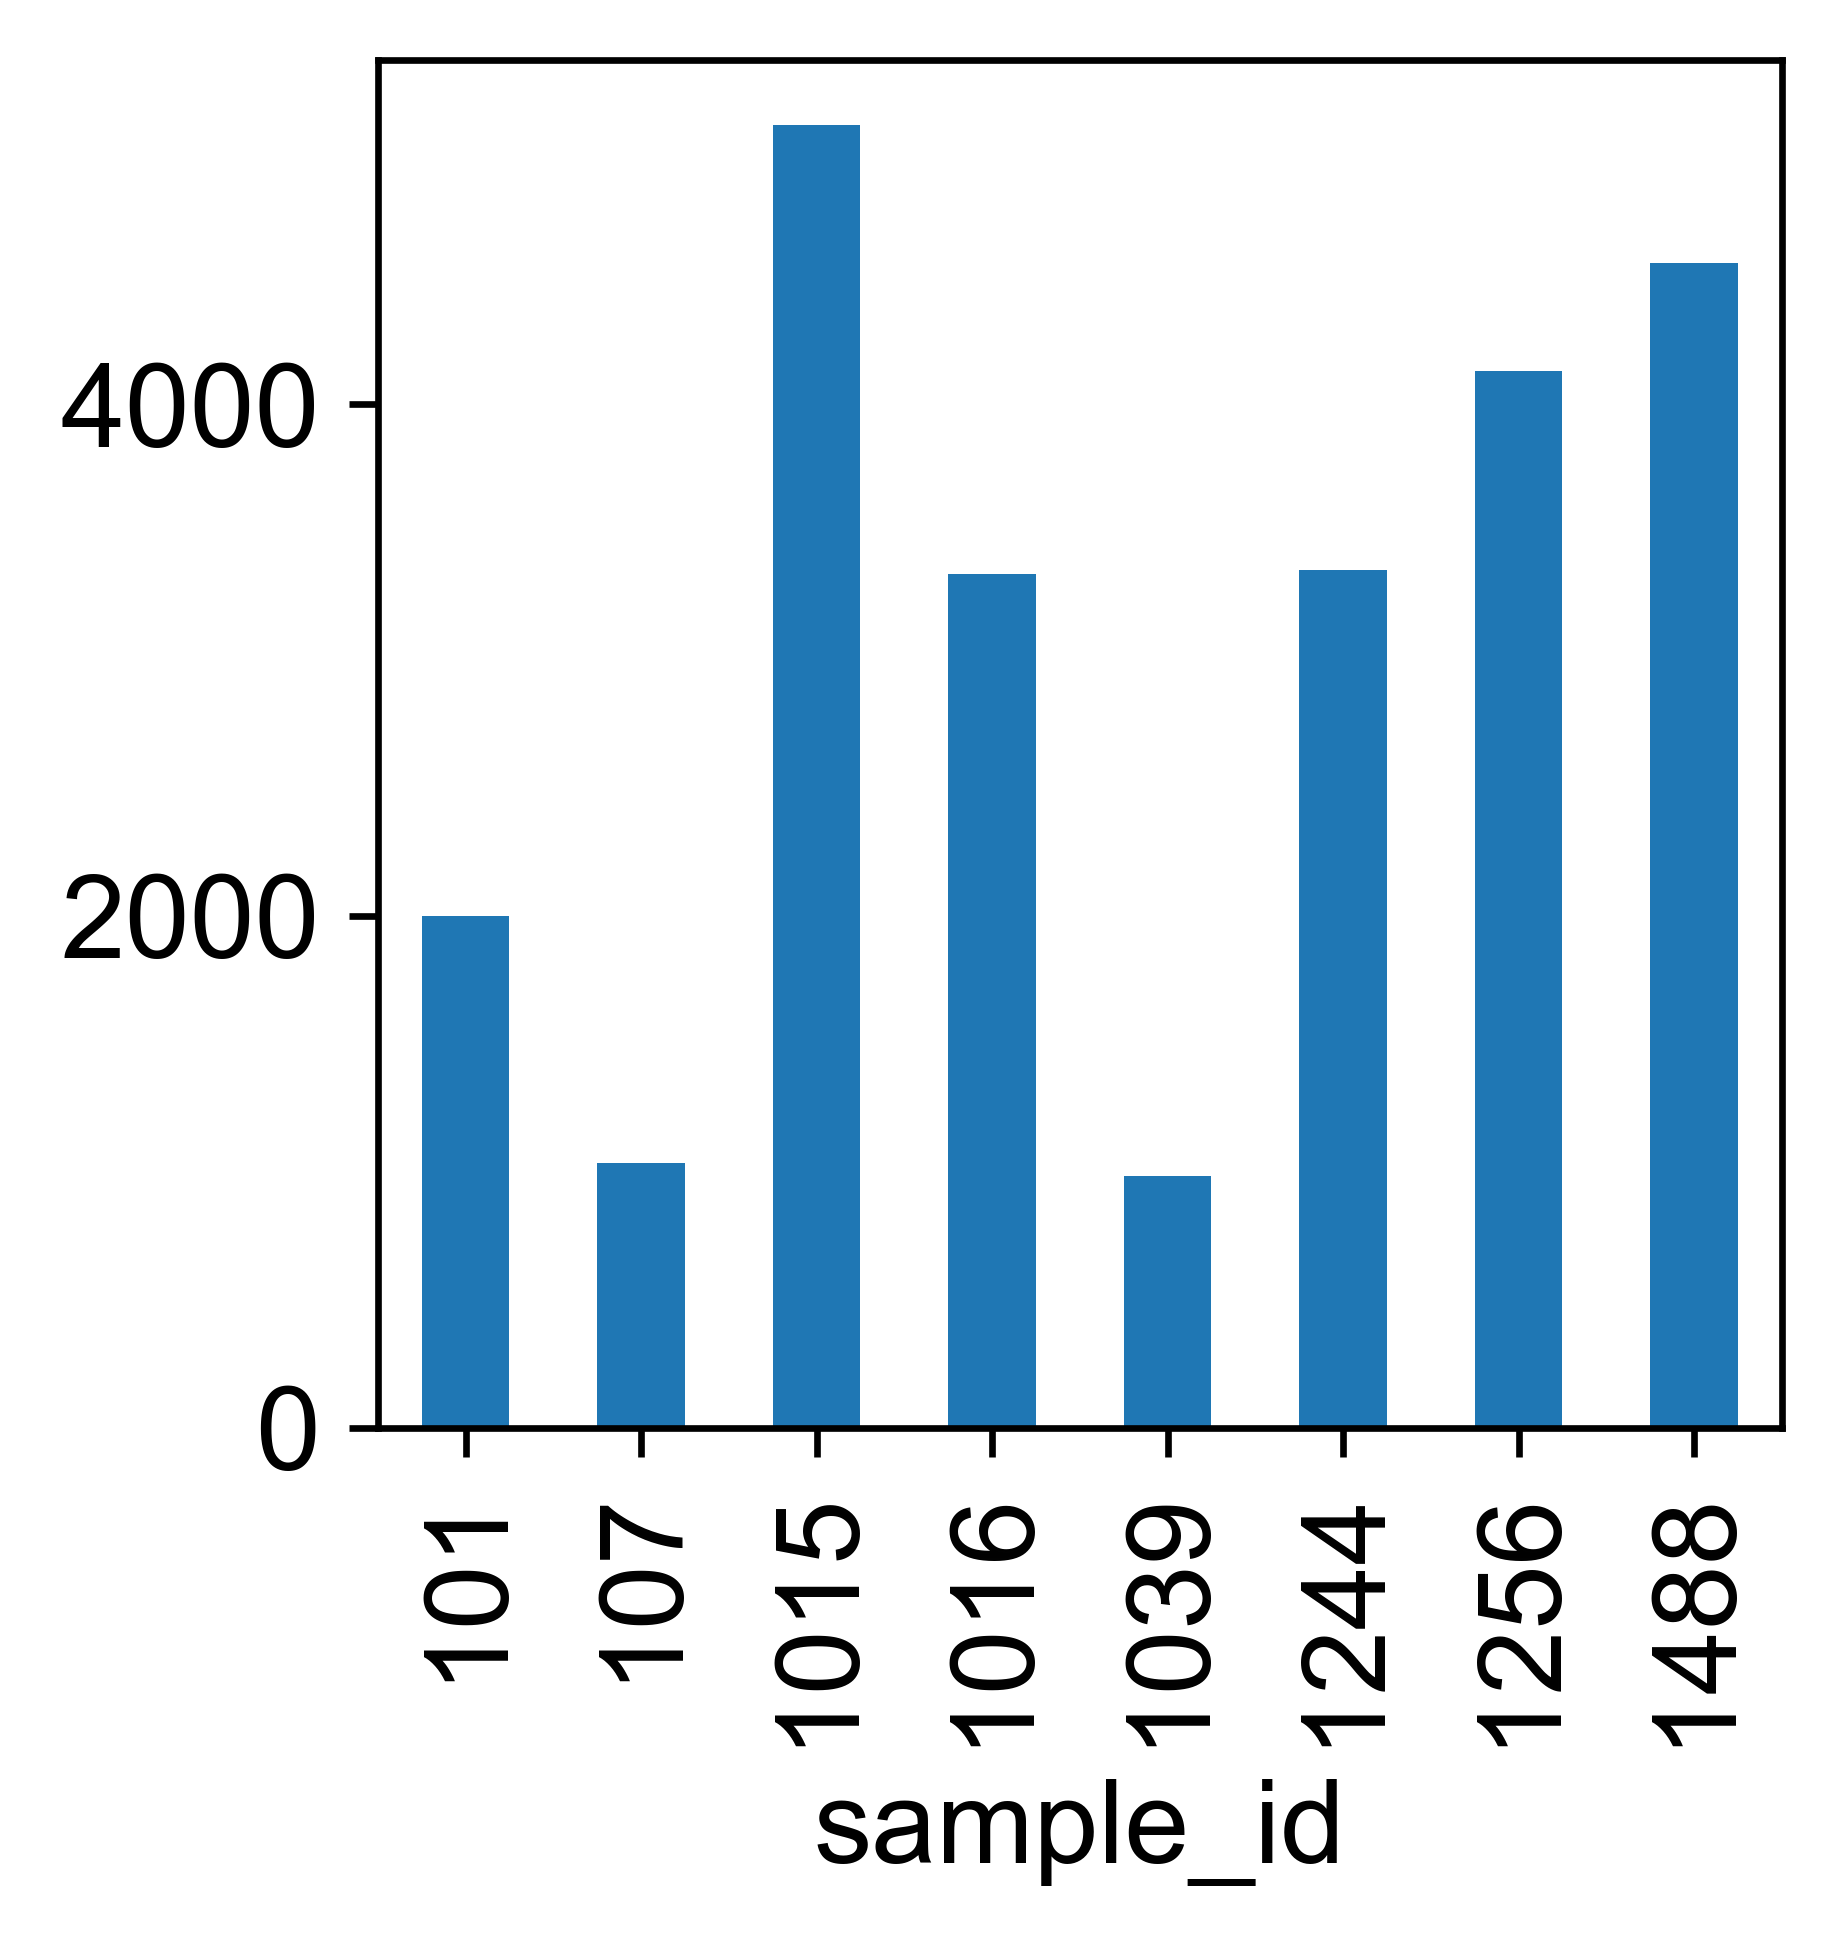

In [12]:
adata.obs.groupby(["sample_id"]).size().plot(kind="bar")
plt.grid(False)

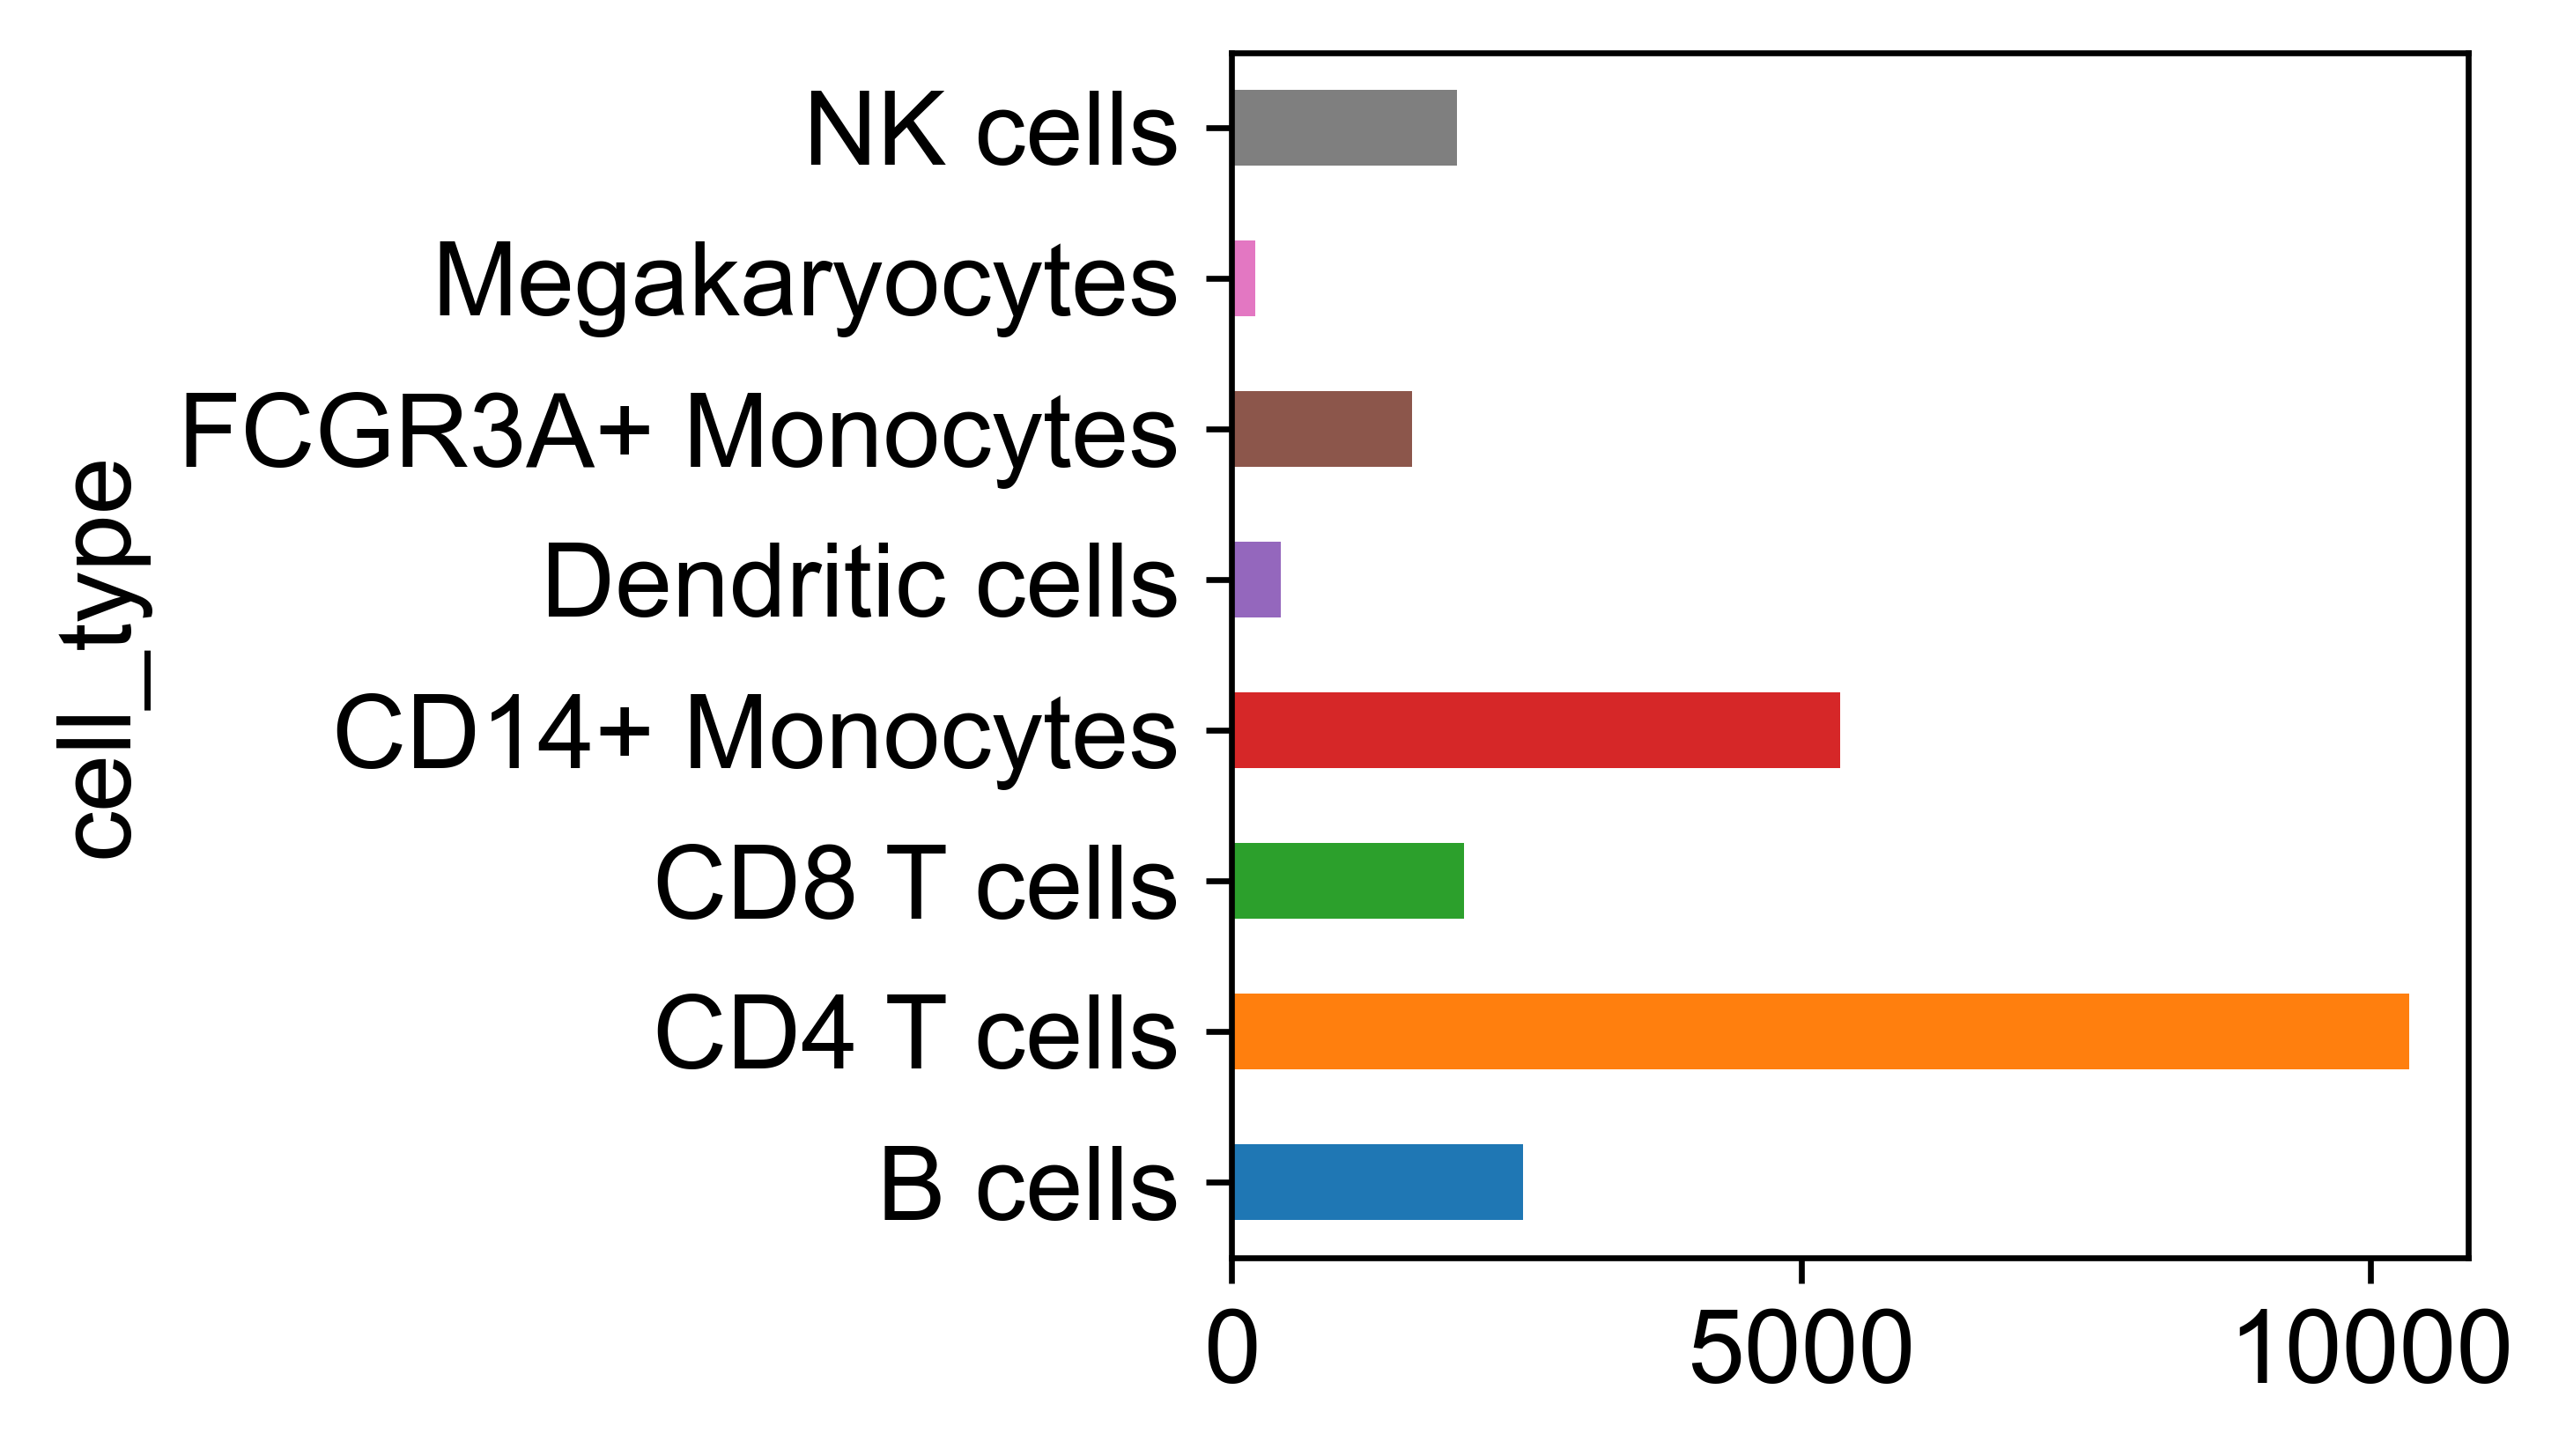

In [13]:
custom_palette = cc.glasbey_category10
adata.obs.groupby(["cell_type"]).size().plot.barh(color=custom_palette)
plt.grid(False)

In [14]:
adata.obs["sample_id"]

barcode
AAACATACATTTCC-1    1016
AAACATACCAGAAA-1    1256
AAACATACCATGCA-1    1488
AAACATACCTCGCT-1    1256
AAACATACCTGGTA-1    1039
                    ... 
TTTGCATGCCTGAA-1    1244
TTTGCATGCCTGTC-1    1256
TTTGCATGCTAAGC-1     107
TTTGCATGGGACGA-1    1488
TTTGCATGTCTTAC-1    1016
Name: sample_id, Length: 24483, dtype: category
Categories (8, int64): [101, 107, 1015, 1016, 1039, 1244, 1256, 1488]

In [15]:
targeted_label = "stim"

In [19]:
# count the number of unique condition
count_dict = {}

for each in adata.obs.condition:
    if each not in count_dict:
        count_dict[each] = 0
        
    count_dict[each] += 1
    
count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse = True))
count_dict

{'ctrl': 12494, 'stim': 11989}

In [21]:
np.amax(adata.X)

3828.0

In [22]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# sc.pp.filter_cells(adata_test, min_genes=200)
# sc.pp.filter_genes(adata_test, min_cells=3)

In [23]:
adata.var['mt'] = adata.var.symbol.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


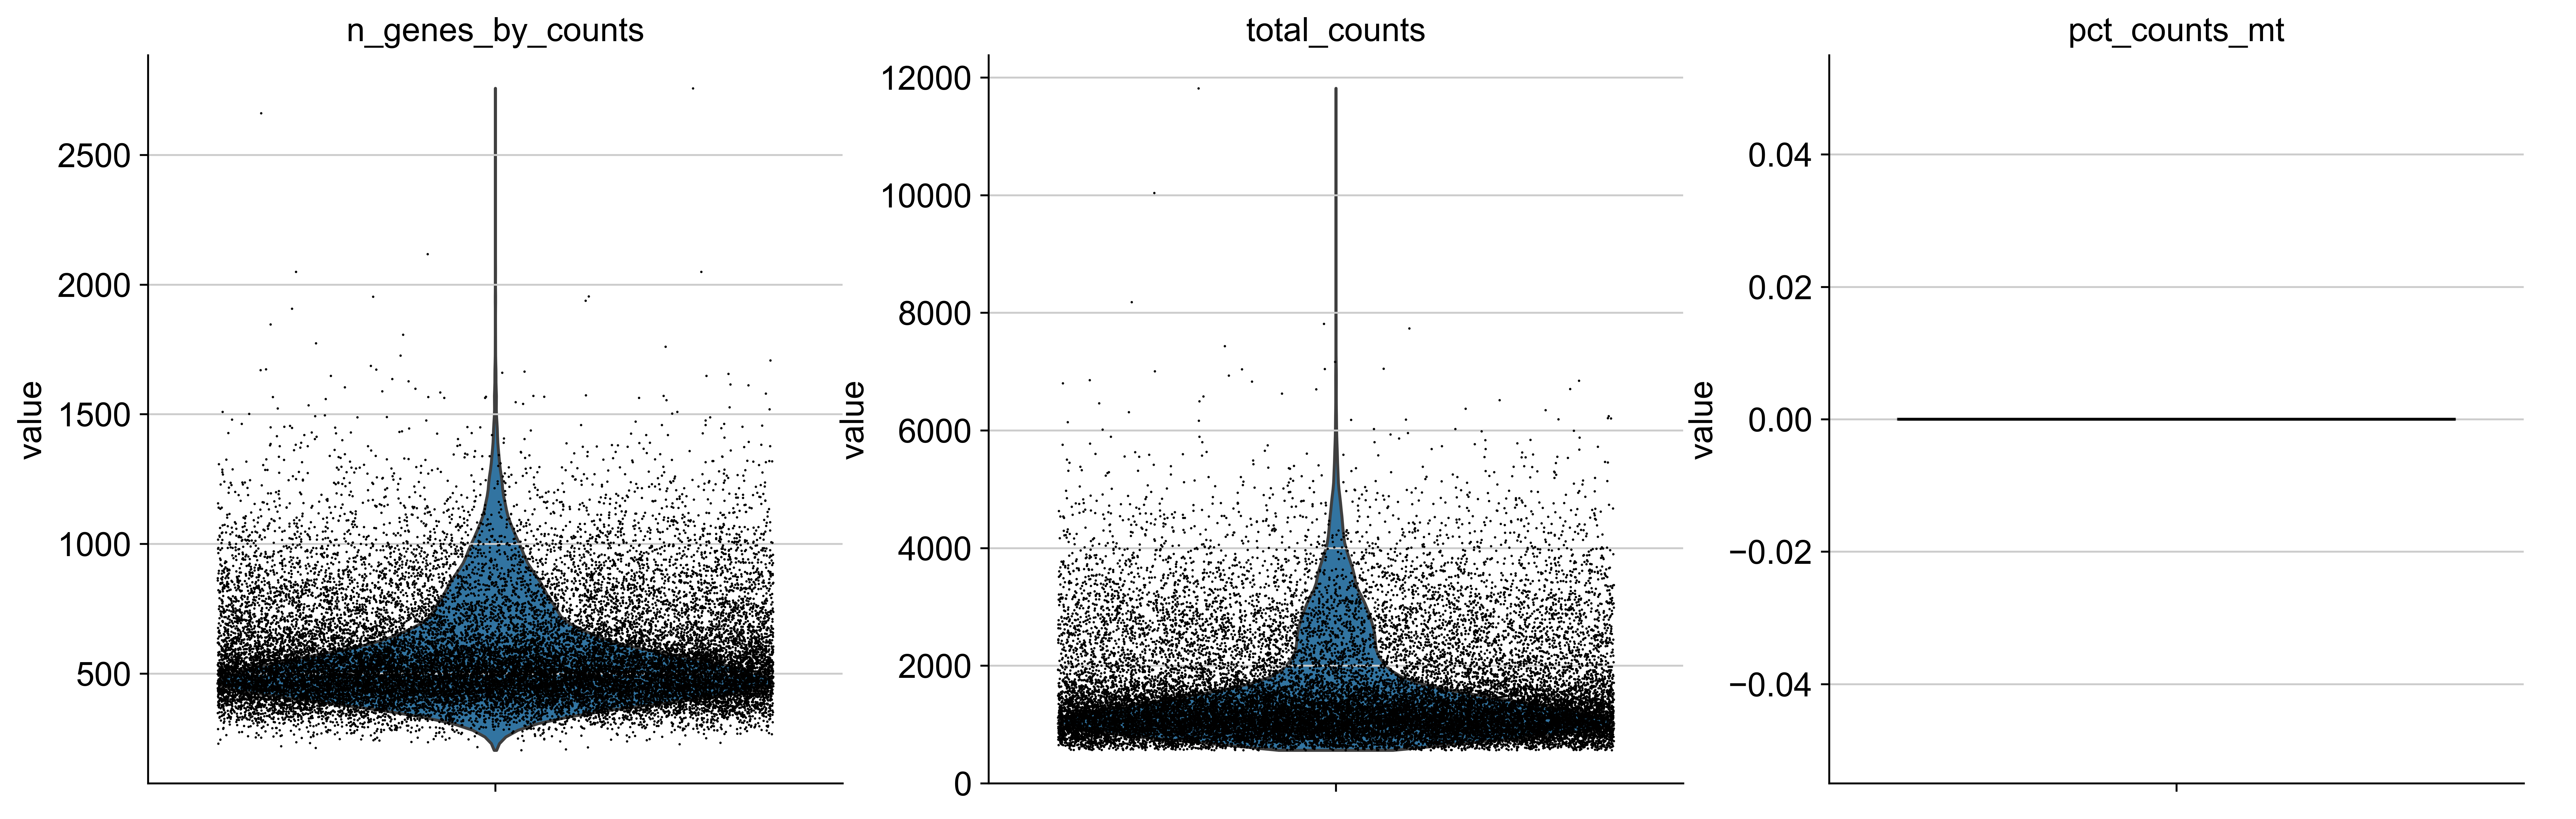

In [24]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

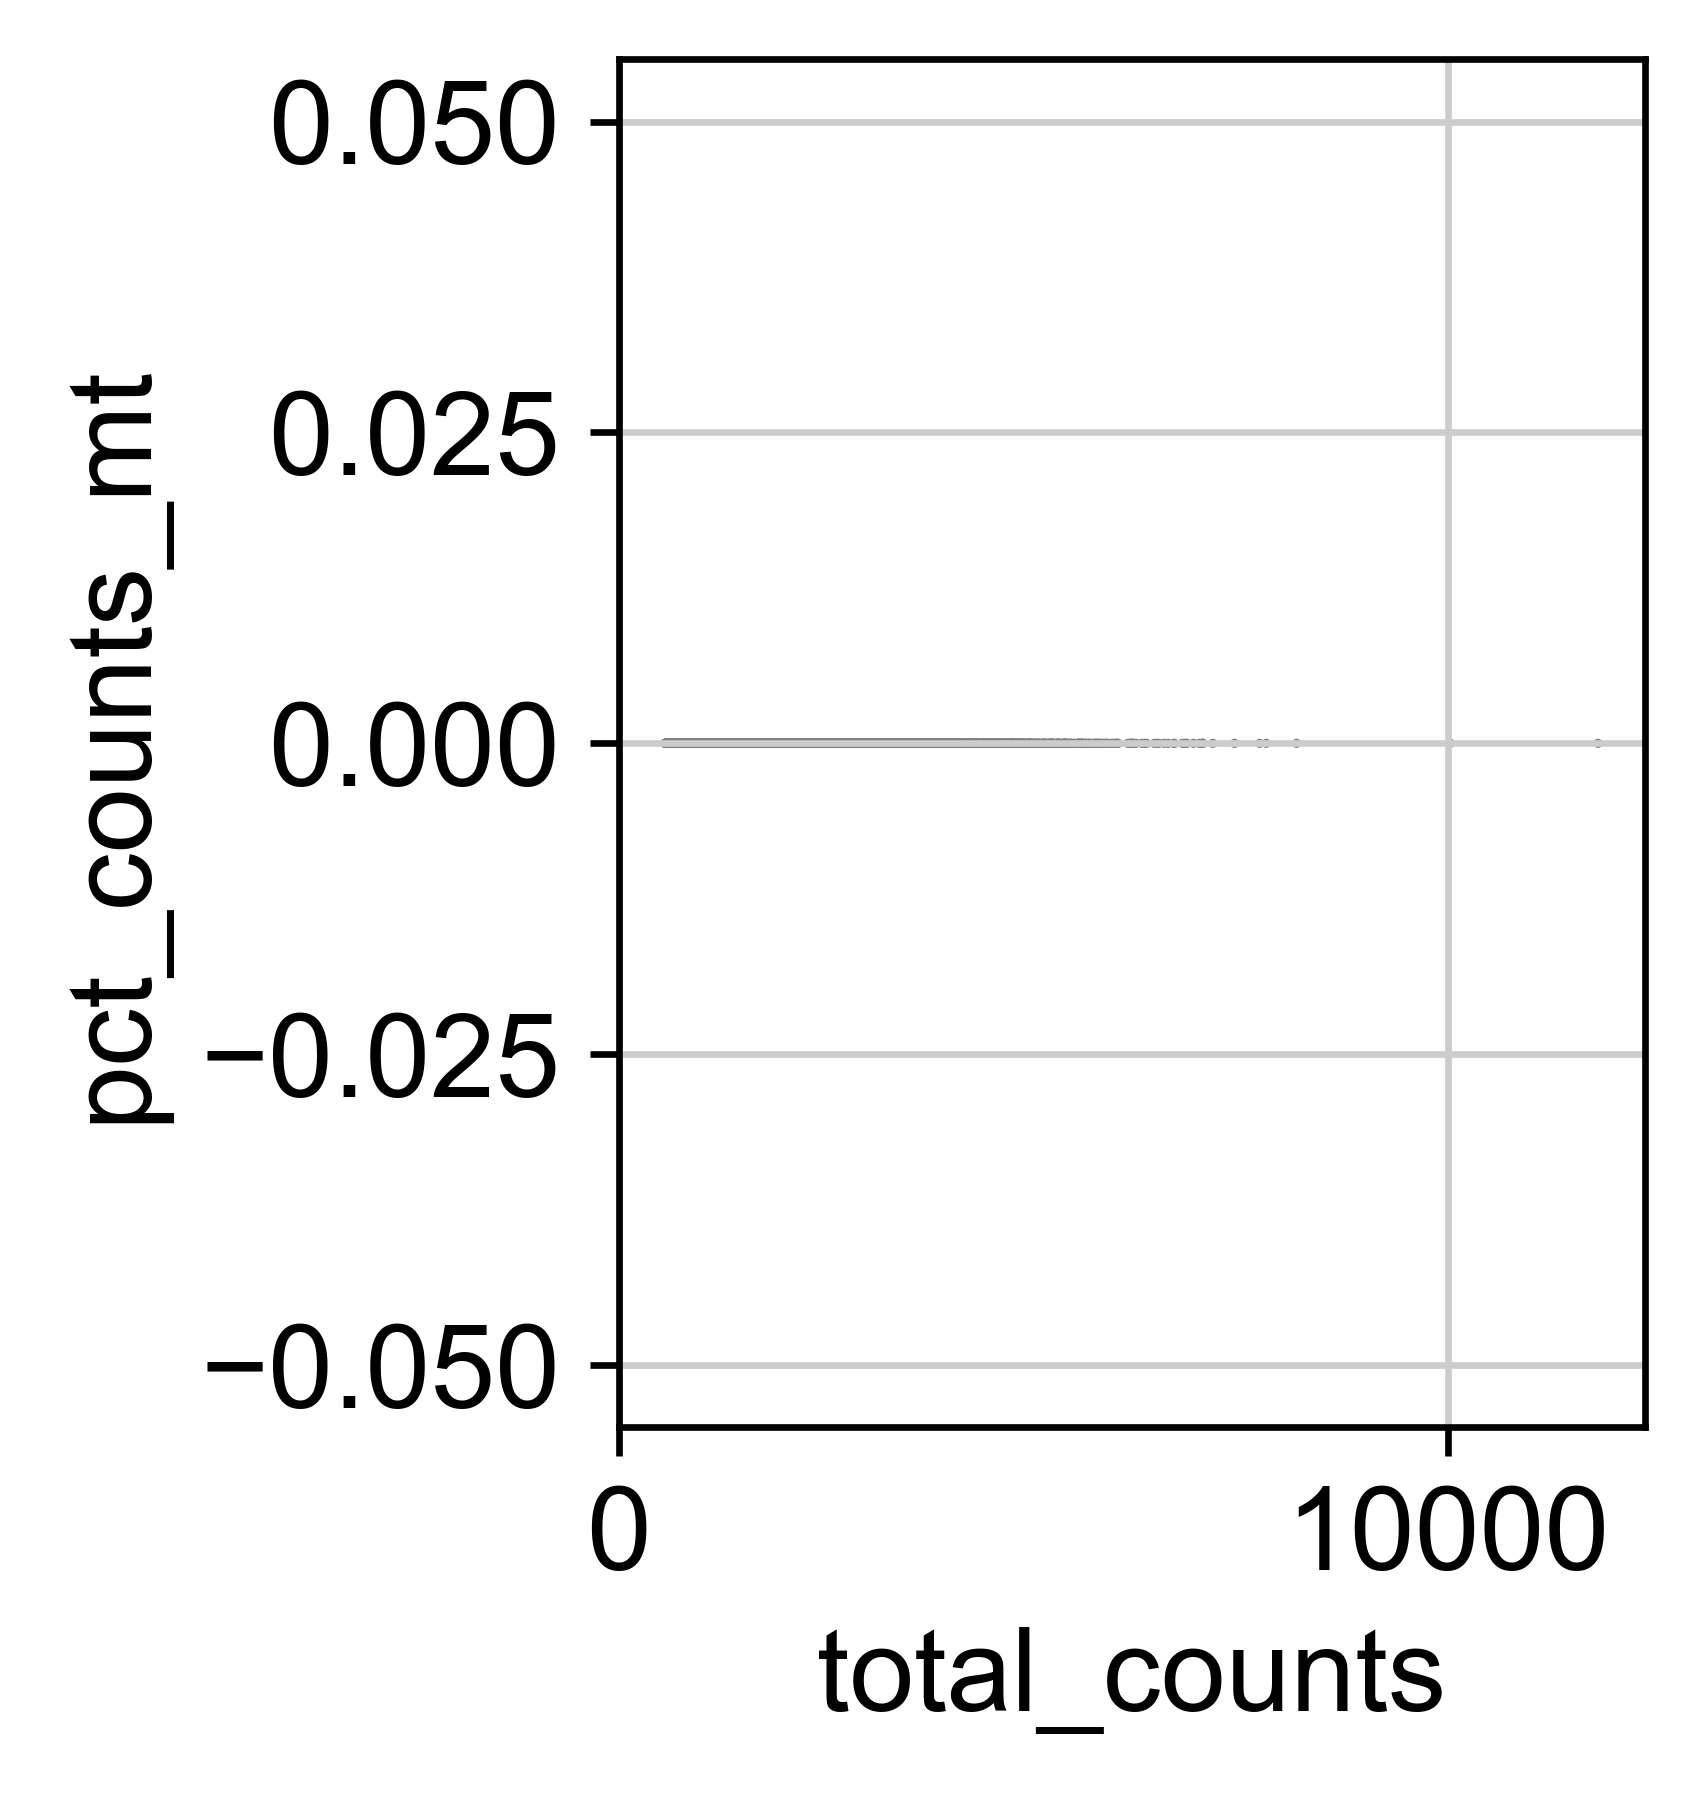

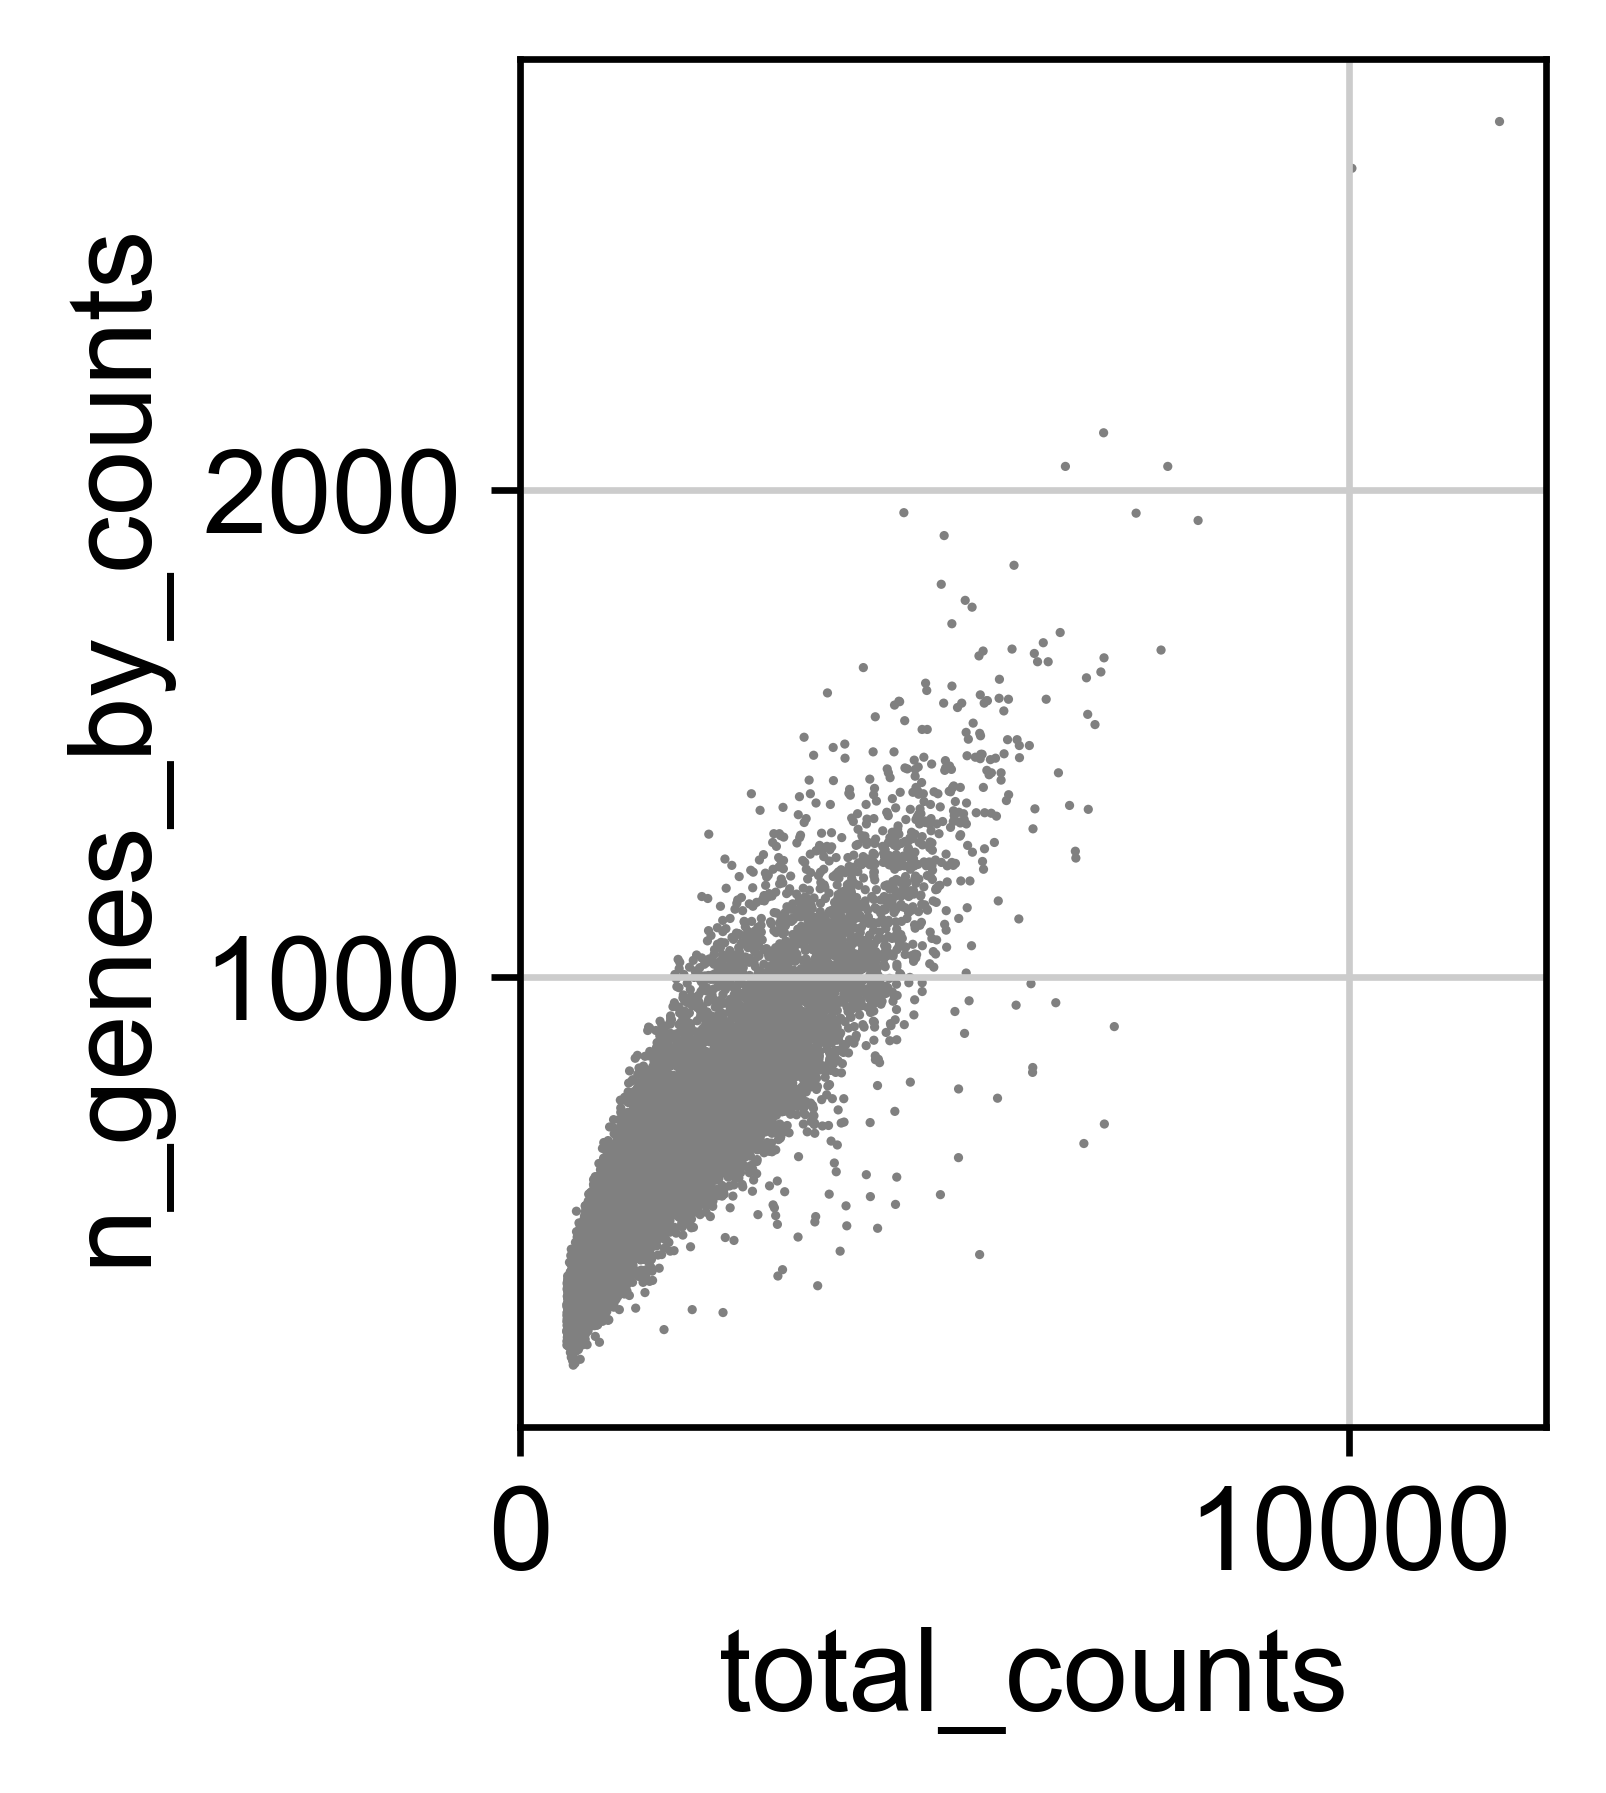

In [25]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [26]:
adata = adata[adata.obs.n_genes_by_counts < 1500, :]
adata = adata[adata.obs.pct_counts_mt < 8, :]

# adata_test = adata_test[adata_test.obs.n_genes_by_counts < 5000, :]
# adata_test = adata_test[adata_test.obs.pct_counts_mt < 8, :]

## Split the dataset into testing and training

In [27]:
# setup_seed(8)
# adata = adata[np.random.choice(165748, 10000, replace=False)]

In [28]:
adata

View of AnnData object with n_obs × n_vars = 24428 × 15694
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [32]:
sc.__version__

'1.10.2'

In [34]:
# flavor: seurat_v3, cell_ranger & log = false
def sub_data_preprocess(adata: sc.AnnData, n_top_genes: int = 5000, batch_key: str = None, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3) -> sc.AnnData:
#     sc.pp.filter_cells(adata, min_genes=min_genes)
#     sc.pp.filter_genes(adata, min_cells=min_cells)
    if flavor == 'seurat_v3':
# #         count data is expected when flavor=='seurat_v3'
#         sc.pp.highly_variable_genes(
#             adata, flavor=flavor, batch_key = batch_key)
        sc.pp.highly_variable_genes(
            adata, flavor=flavor, n_top_genes=n_top_genes)

#     if flavor != 'seurat_v3':.
#         # log-format data is expected when flavor!='seurat_v3'
#         sc.pp.highly_variable_genes(
#             adata, n_top_genes=n_top_genes, flavor=flavor)
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    return adata


def data_preprocess(adata: sc.AnnData, key: str = 'batch', n_top_genes: int = 2000, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3, n_batch: int = 2) -> sc.AnnData:
    print('Establishing Adata for Next Step...')
    hv_adata = sub_data_preprocess(adata, n_top_genes=n_top_genes, batch_key = key, flavor=flavor, min_genes=min_genes, min_cells=min_cells)
    if len(adata.var.index) > n_top_genes:
        hv_adata = hv_adata[:, hv_adata.var['highly_variable']]
#     hv_adata.X = np.expm1(hv_adata.X)
    print('PreProcess Done.')
    return hv_adata

In [35]:
# batch_str = "batch_num"

adata = data_preprocess(adata)
adata  # Output the basic information of the preprocessed data.

Establishing Adata for Next Step...


/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


PreProcess Done.


View of AnnData object with n_obs × n_vars = 24428 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

## EDA

Pairwise average correlation of the PCA embeddings of the control states between patients

In [36]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_between_matrices(matrix1, matrix2):
    """
    Compute the cosine similarity between the rows of two matrices.

    Parameters:
    - matrix1: numpy array, the first matrix
    - matrix2: numpy array, the second matrix

    Returns:
    - cosine_similarity_score: float, the cosine similarity between the rows of the matrices
    """
    if matrix1.shape[1] != matrix2.shape[1]:
        raise ValueError("Matrices must have the same number of columns.")

    # Compute cosine similarity between the rows
    cosine_similarity_matrix = cosine_similarity(matrix1, matrix2)
    
    # Take the mean cosine similarity score as a measure of overall similarity
    cosine_similarity_score = np.mean(np.diagonal(cosine_similarity_matrix))

    return np.round(cosine_similarity_score, 3)

# Example usage:
matrix1 = np.random.rand(50, 100)  # Replace with your actual matrix1
matrix2 = np.random.rand(10, 100)  # Replace with your actual matrix2

result = cosine_similarity_between_matrices(matrix1, matrix2)
print("Cosine Similarity Score:", result)

Cosine Similarity Score: 0.754


In [37]:
def get_mean_corr(A, B):
    feature_mean_corr = np.corrcoef(A.mean(0), B.mean(0))

    # Set the middle diagonal elements to zero
    np.fill_diagonal(feature_mean_corr, 0)

    feature_mean_corr = np.triu(feature_mean_corr)
    
    return np.round(np.nanmean(np.where(feature_mean_corr!=0,feature_mean_corr,np.nan)), 3)

In [38]:
# This is mainly for the EDA purpose and wiLl not be used for the projection

pca = PCA(n_components = 30, random_state = 8)
# pca.fit(adata.X.toarray())
pca.fit(adata.X)

# X_pca = pca.transform(adata.X.toarray())
X_pca = pca.transform(adata.X)

adata.obsm["X_pca"] = X_pca.copy()

/tmp/ipykernel_52281/904462510.py:10: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca.copy()


In [39]:
# corr_meta = "sample_id"
corr_meta = "cell_type"

sample_id_list = adata.obs[corr_meta].unique().to_list()

# store all array in dictionary data
sample_X_dict = {}

# iterate through each sample id
for each in sample_id_list:
    temp_array = adata[(adata.obs[corr_meta].isin([each])) & (adata.obs["condition"] == "ctrl")].obsm["X_pca"]
    sample_X_dict[each] = temp_array

# compute for correlation
cosine_list = []
sample_size = len(sample_X_dict)

# computing sample to sample similarity
for i in sample_id_list:
    for j in sample_id_list:
        cosine_list.append(cosine_similarity_between_matrices(sample_X_dict[i], sample_X_dict[j]))
        # print("done")

# reshape into sample by sample shape
cosine_list = np.array(cosine_list).reshape((sample_size, sample_size))

# check for the matrix
cosine_list

array([[ 1.   , -0.285,  0.463, -0.211, -0.248, -0.154,  0.034,  0.621],
       [-0.285,  1.   , -0.159,  0.336,  0.455,  0.35 ,  0.301, -0.304],
       [ 0.463, -0.159,  1.   , -0.12 , -0.124,  0.196,  0.049,  0.384],
       [-0.211,  0.336, -0.12 ,  1.   ,  0.586,  0.17 ,  0.195, -0.214],
       [-0.248,  0.455, -0.124,  0.586,  1.   ,  0.263,  0.258, -0.26 ],
       [-0.154,  0.35 ,  0.196,  0.17 ,  0.263,  1.   ,  0.239, -0.138],
       [ 0.034,  0.301,  0.049,  0.195,  0.258,  0.239,  1.   ,  0.008],
       [ 0.621, -0.304,  0.384, -0.214, -0.26 , -0.138,  0.008,  1.   ]])

In [40]:
# compute for correlation
corr_list = []
sample_size = len(sample_X_dict)

# computing sample to sample similarity
for i in sample_id_list:
    for j in sample_id_list:
        corr_list.append(get_mean_corr(sample_X_dict[i], sample_X_dict[j]))
        # print("done")

# reshape into sample by sample shape
corr_list = np.array(corr_list).reshape((sample_size, sample_size))

# check for the matrix
corr_list

array([[ 1.   , -0.402,  0.623, -0.335, -0.394, -0.207,  0.11 ,  0.831],
       [-0.402,  1.   , -0.246,  0.525,  0.717,  0.513,  0.606, -0.455],
       [ 0.623, -0.246,  1.   , -0.252, -0.235,  0.287,  0.129,  0.573],
       [-0.335,  0.525, -0.252,  1.   ,  0.886,  0.239,  0.334, -0.352],
       [-0.394,  0.717, -0.235,  0.886,  1.   ,  0.384,  0.489, -0.432],
       [-0.207,  0.513,  0.287,  0.239,  0.384,  1.   ,  0.437, -0.192],
       [ 0.11 ,  0.606,  0.129,  0.334,  0.489,  0.437,  1.   ,  0.03 ],
       [ 0.831, -0.455,  0.573, -0.352, -0.432, -0.192,  0.03 ,  1.   ]])

In [41]:
# Set scanpy to use Matplotlib
from IPython.display import display, HTML

def plot_save_svg():
    import scanpy as sc
    import matplotlib.pyplot as plt
    sc.settings.set_figure_params(format='svg', frameon=False, figsize=(3, 3), facecolor='white', vector_friendly=False)
    
    # output_filename
    output_filename = "fig.svg"
    plt.grid(False)
    # plt.tight_layout()
    plt.savefig(output_filename, format='svg', bbox_inches='tight', dpi=300, backend = "svg")
    display(HTML(f'<a href="{output_filename}" download>Download {output_filename}</a>'))

In [42]:
import seaborn as sns

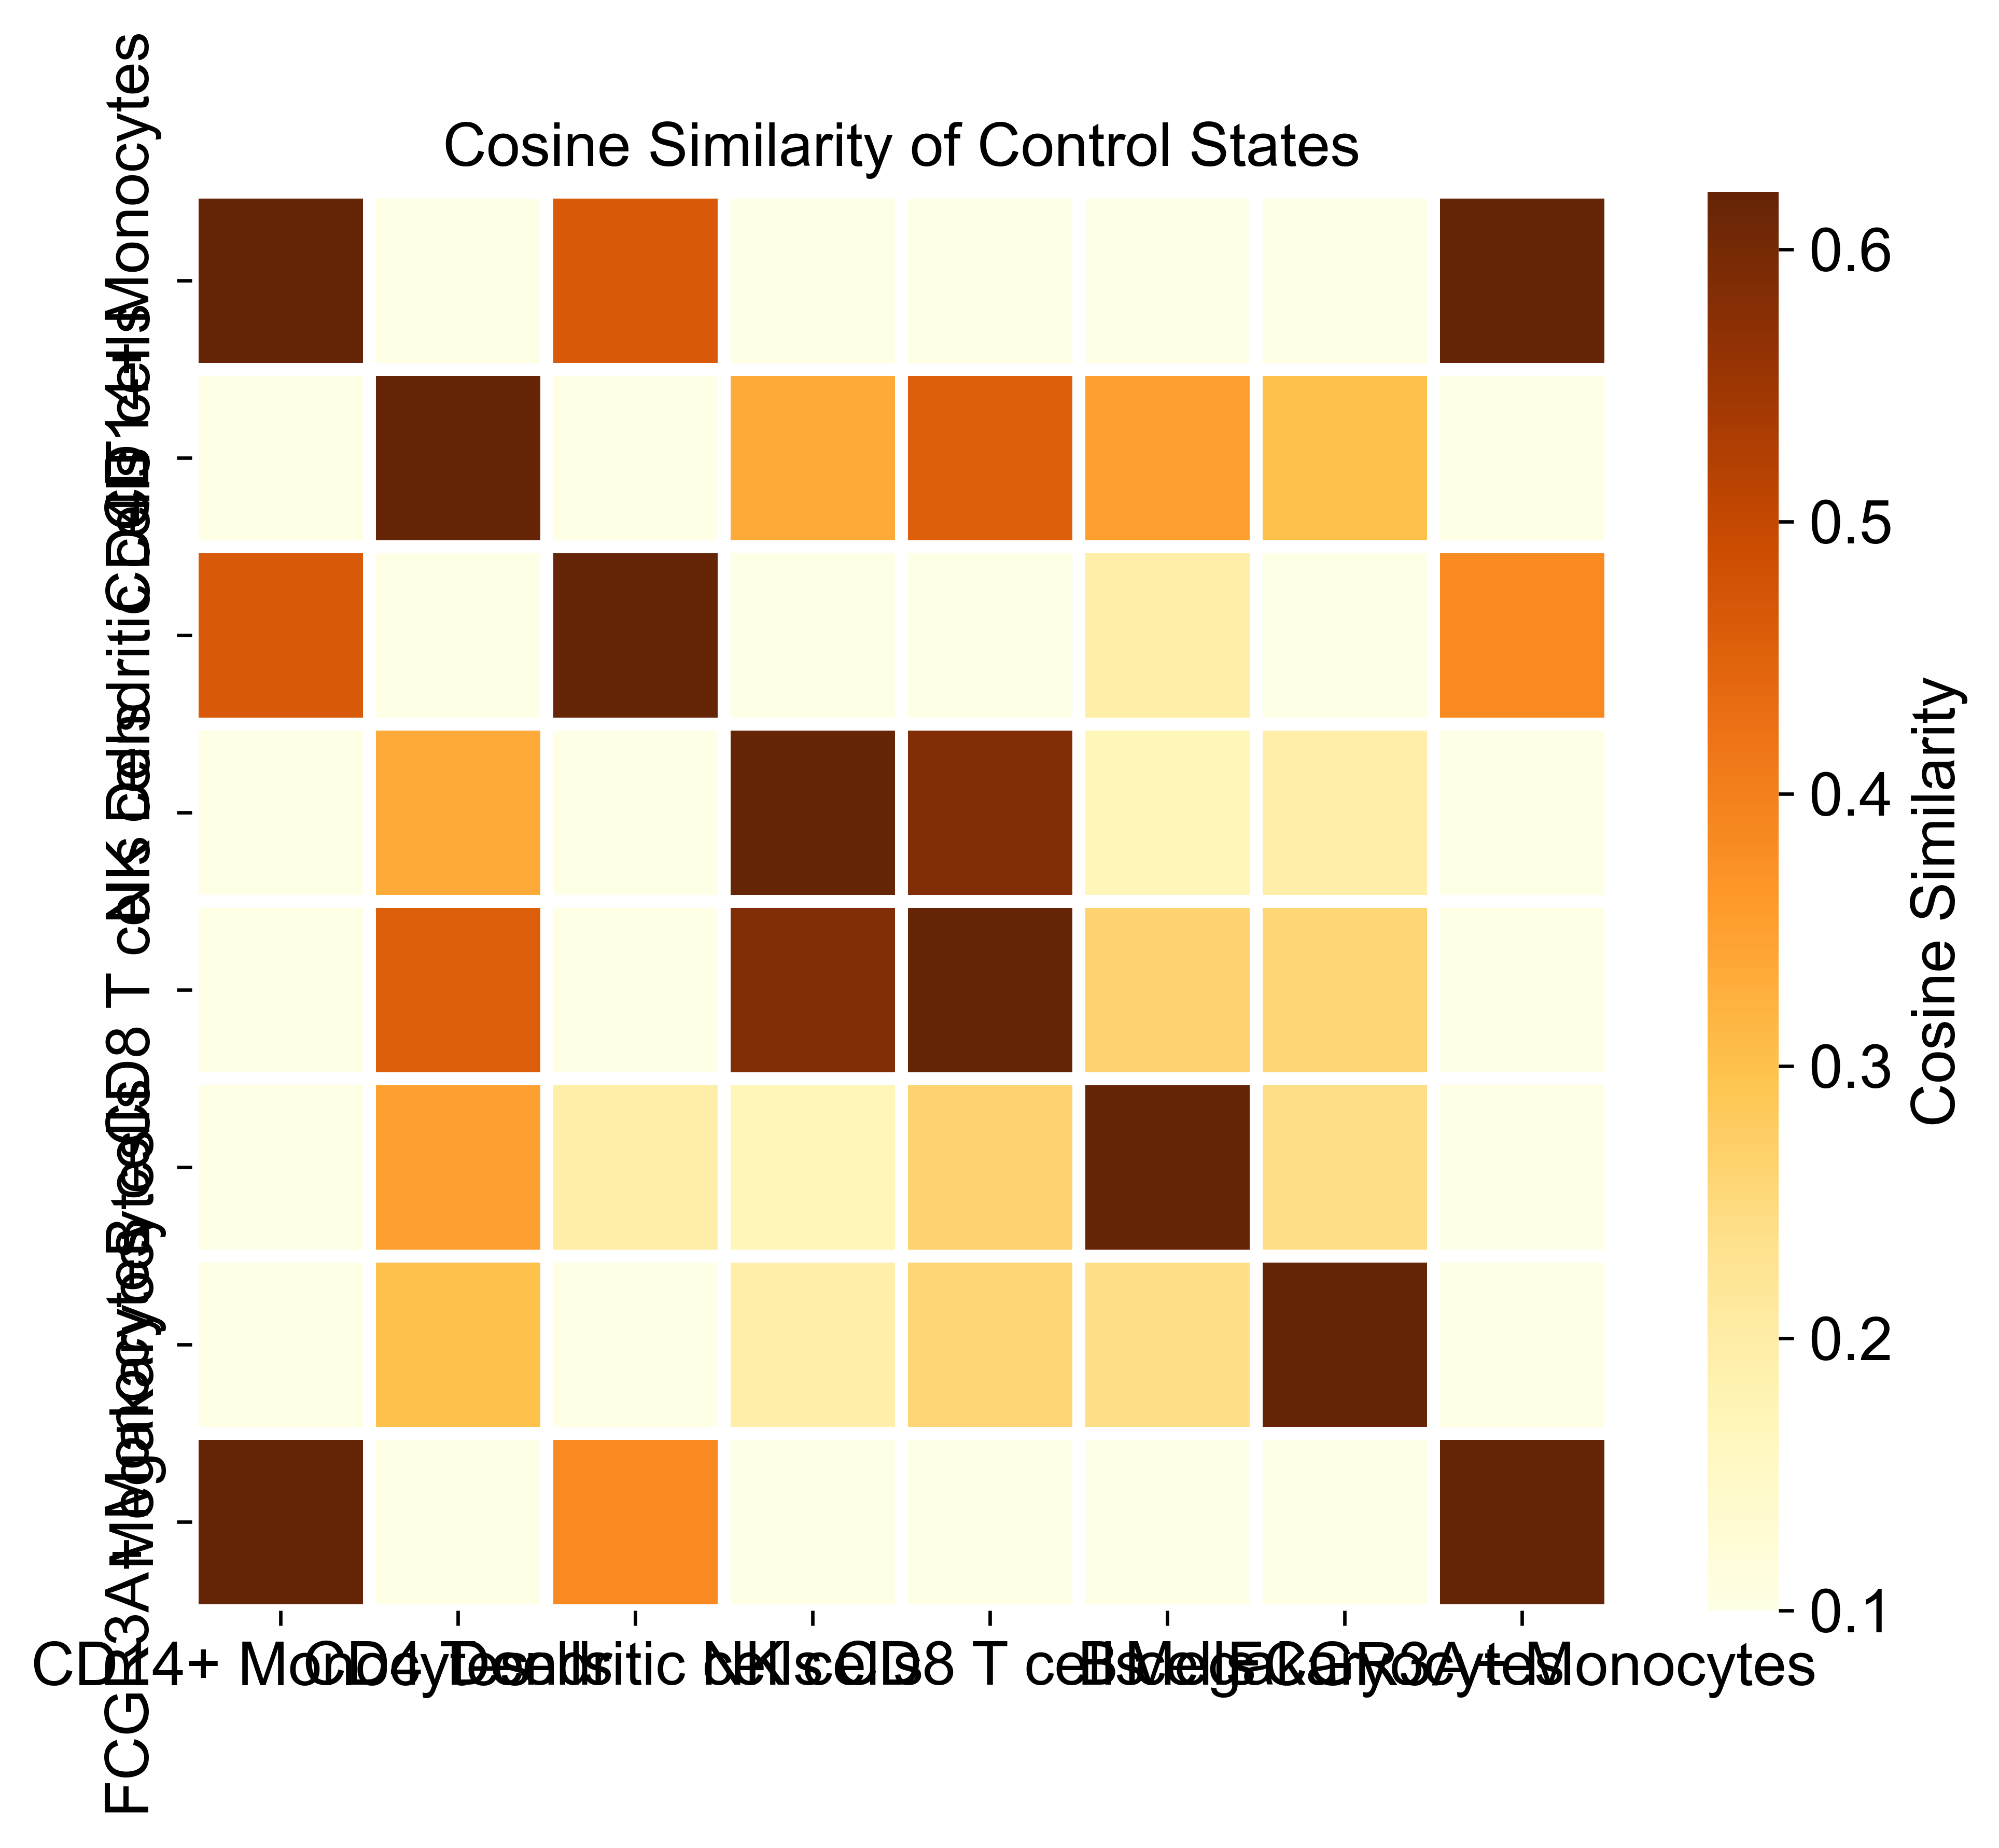

In [43]:
# heatmap plot for EDA
upper_triangle = np.triu(cosine_list, k=1) 
data = cosine_list
# Uncomment to get only the opper triangle
# data = np.triu(data)
data[data == 0] = np.nan 
plt.figure(figsize=(8, 6))

# get the max & min number
max_num = np.amax(upper_triangle)
min_num = np.amin(upper_triangle)

sns.heatmap(data, cmap='YlOrBr', vmin=0.1, vmax=max_num , annot=False, fmt='.2f',
            square=True, cbar=True, cbar_kws={'label': 'Cosine Similarity'},
            linewidths=3, linecolor='white') 

# plt.title("Heatmap with Custom Colormap and Range")

# Remove spines (Seaborn doesn't always remove them cleanly)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(False)
plt.title("Cosine Similarity of Control States")

plt.xticks(np.arange(0.5, len(sample_id_list) + 0.5, 1), [str(each) for each in sample_id_list], rotation = 35, ha = "right")
plt.yticks(np.arange(0.5, len(sample_id_list) + 0.5, 1), [str(each) for each in sample_id_list], rotation = 0)


plot_save_svg()

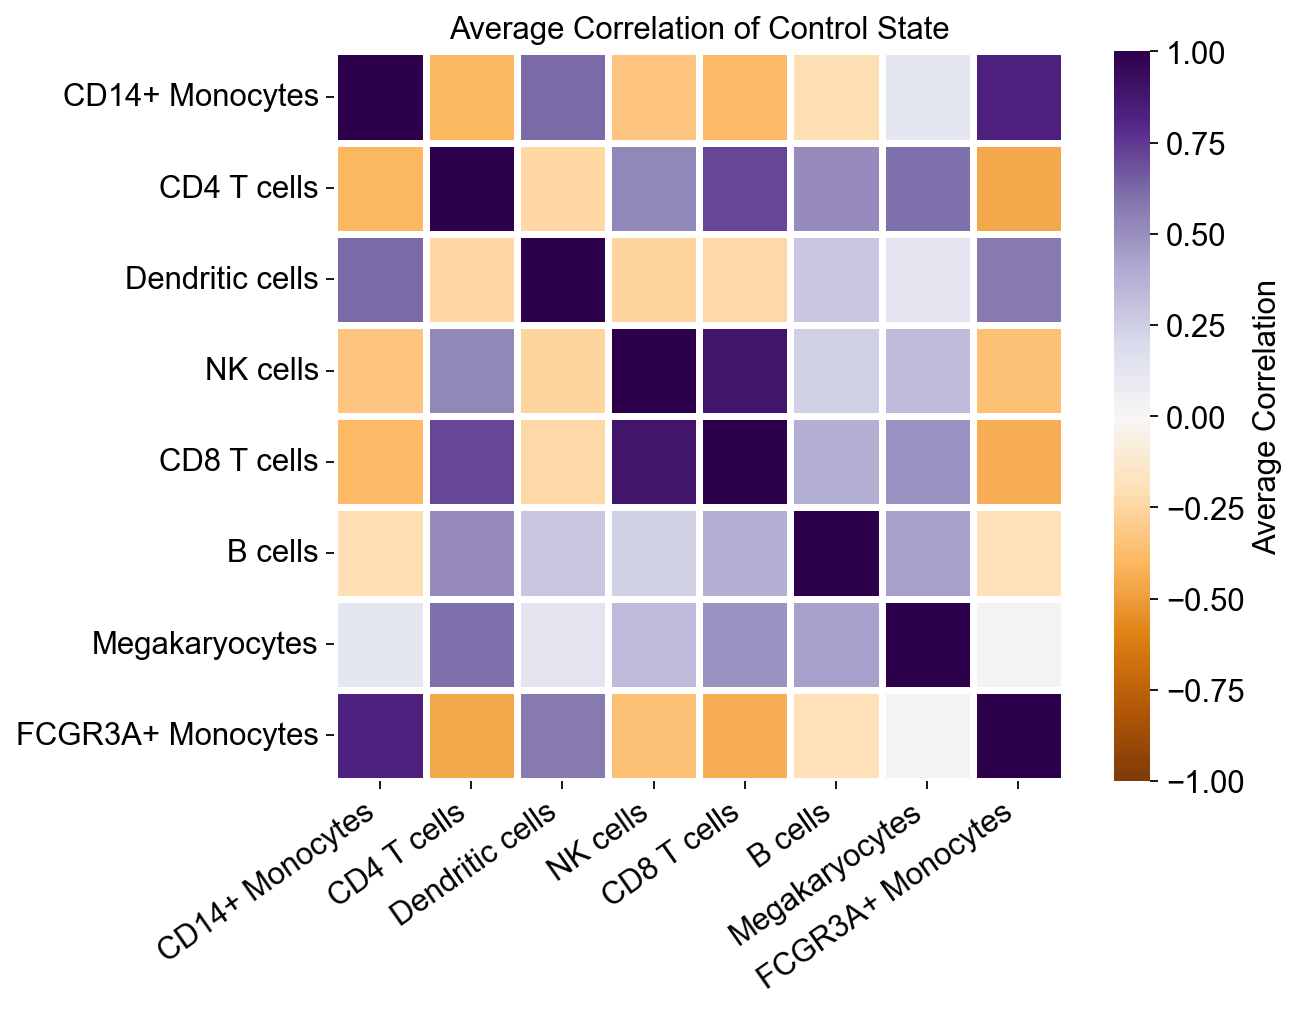

In [44]:
# heatmap plot for EDA
upper_triangle = np.triu(corr_list, k=1) 
data = corr_list
# Uncomment to get only the opper triangle
# data = np.triu(data)
data[data == 0] = np.nan 
plt.figure(figsize=(8, 6))

# get the max & min number
max_num = np.amax(upper_triangle)
min_num = np.amin(upper_triangle)

# sns.heatmap(data, cmap='YlOrBr', vmin=0.7, vmax=max_num , annot=False, fmt='.2f',
#             square=True, cbar=True, cbar_kws={'label': 'Average Correlation'},
#             linewidths=3, linecolor='white')

sns.heatmap(data, cmap='PuOr', vmin=-1, vmax=1 , annot=False, fmt='.2f',
            square=True, cbar=True, cbar_kws={'label': 'Average Correlation'},
            linewidths=3, linecolor='white') 

# plt.title("Heatmap with Custom Colormap and Range")

# Remove spines (Seaborn doesn't always remove them cleanly)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(False)
plt.title("Average Correlation of Control State")

plt.xticks(np.arange(0.5, len(sample_id_list) + 0.5, 1), [str(each) for each in sample_id_list], rotation = 35, ha = "right")
plt.yticks(np.arange(0.5, len(sample_id_list) + 0.5, 1), [str(each) for each in sample_id_list], rotation = 0)

plot_save_svg()

In [45]:
# creating a common PCA for all the model.
setup_seed(8)

# Create PCA object and fit it to the data
pca = PCA(n_components=50)
pca.fit(adata.X)

pca_matrix = pca.components_

# save the principle component
pd.DataFrame(pca.components_).to_csv("pca_component_2.csv", index = False)

In [46]:
adata.obsm["X_pca"]

array([[ 1.28298224e+01,  1.13121286e+01, -2.11218789e+00, ...,
         2.94376399e-01, -9.48990705e-01,  1.82374795e-01],
       [ 1.19445337e+01,  1.23320127e+01,  2.21809114e+00, ...,
         6.81212547e-01, -2.58500159e-01,  2.03274492e-03],
       [-6.84677778e+00,  2.87214612e+00, -4.67922220e-01, ...,
         1.28039838e+00,  5.06908269e-01,  5.45018494e-01],
       ...,
       [-5.17988295e+00, -3.36429448e+00, -7.36429101e-01, ...,
        -1.29317668e+00, -4.02562766e-01,  9.36340982e-01],
       [-6.49211253e+00, -2.11946755e+00, -1.31375644e+00, ...,
        -6.24228964e-01,  4.58317483e-01, -3.06564869e+00],
       [-6.91489432e+00, -1.41027214e+00, -1.00762452e-01, ...,
        -2.07909983e+00,  1.17095931e+00,  3.77227488e-01]])

In [47]:
custom_palette = cc.glasbey_hv
setup_seed(8)

X_pca = adata.X @ pca_matrix.T
adata.obsm["X_pca"] = X_pca.copy()

# adata.obs["condition"].replace("Control", "Control", inplace = True)
# adata.obs["condition"].replace("stim", "Perturbed", inplace = True)

print("done with PCA")

print(adata.obsm["X_pca"].shape)

done with PCA
(24428, 50)


In [50]:
adata

AnnData object with n_obs × n_vars = 24428 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca'

In [51]:
adata.obs["condition"] = adata.obs["condition"].astype("category").copy()

adata.obs.condition.replace("ctrl", "Control", inplace = True)
adata.obs.condition.replace("stim", "Perturbed", inplace = True)

In [54]:
adata_raw = adata.copy()

In [55]:
removed_cell = "NK cells"

# using the difference one to be the testing set
adata_test = adata[np.array(adata.obs["cell_type"].isin([removed_cell]))].copy()
adata_test

AnnData object with n_obs × n_vars = 1981 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca'

In [56]:
# remove the data from the training data
adata = adata[~np.array(adata.obs["cell_type"].isin([removed_cell]))].copy()
adata

AnnData object with n_obs × n_vars = 22447 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca'

In [57]:
setup_seed(8)
# held out a portion of control cells for making prediction in the evaluation phase
control_test = adata_test[adata_test.obs.condition == "Control"]
# control_test = control_test[np.random.choice(control_test.shape[0], 1000, replace=False)]
control_test

View of AnnData object with n_obs × n_vars = 934 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca'

In [61]:
adata.obs["batch"] = adata.obs["condition"]

le = preprocessing.LabelEncoder()
new_batch = le.fit_transform(adata.obs["batch"])
adata.obs["batch"] = new_batch

new_batch = [str(each) for each in new_batch]
adata.obs["batch_num"] = new_batch

In [62]:
adata.obs["batch"].unique()

array([0, 1])

## Split the data into training and testing

In [65]:
adata.layers["log_norm"] = adata.X.copy()

In [66]:
setup_seed(8)

In [67]:
import scanpy as sc
import pandas as pd
import seaborn as sns

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1
sc.settings.set_figure_params(
    dpi=300, frameon=False, figsize=(3, 3), facecolor='white')

In [71]:
import colorcet as cc

In [72]:
custom_palette = cc.glasbey_category10

In [84]:
from sklearn.preprocessing import OneHotEncoder

# le = preprocessing.LabelEncoder()
enc_batch = OneHotEncoder(handle_unknown='ignore')
# enc_group = OneHotEncoder(handle_unknown='ignore')

label_str = "batch"
# group_str = "condition"

enc_batch.fit(adata.obs[label_str].to_numpy().reshape(-1, 1))
# enc_group.fit(adata.obs[group_str].to_numpy().reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore')

In [85]:
########## CLASS SINGLE CELL DATASET ##########
class ScDataset(Dataset):
    def __init__(self, adata):
        self.variable = None
        self.labels = adata.obs[label_str].to_numpy()
        self.org_batch = adata.obs[label_str].to_numpy()
#         self.groups = adata.obs[group_str].to_numpy()
        self.one_hot_labels = enc_batch.transform(adata.obs[label_str].to_numpy().reshape(-1, 1)).toarray()
#         self.one_hot_groups = enc_group.transform(adata.obs[group_str].to_numpy().reshape(-1, 1)).toarray()
        try:
            self.X = adata.X.toarray()
#             self.hvg_X = adata[:, adata.var['highly_variable']].X.copy().toarray()
        except:
            self.X = adata.X
        
        self.min_val = np.amin(adata.X)
        self.max_val = np.amax(adata.X)
#         self.groups = adata.obs[group_str].to_numpy()
        self.transform = None
        self.sample = None
        self.adata = adata
#         self.random_target = np.eye(c_dim)[np.random.choice(c_dim, len(self.labels))]
        
#             self.hvg_X = adata[:, adata.var['highly_variable']].X.copy()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
#         random_index = random.randint(0, self.X.shape[0] - 1)

        return self.X[index], self.labels[index], self.one_hot_labels[index]

In [86]:
label_str = "batch"

# split per batch into new objects.
batches = list(set(adata.obs[label_str]))
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs[label_str] == batch,]

length_data = []

for batch in batches:
    length = len(alldata[batch])
    
    length_data.append(length)
anchor_index = np.argmax(length_data)

In [87]:
batches[anchor_index]

0

### pre processing step for normalise and scale the for each individual batch

In [88]:
# # apply the pre processing onto the anndata
# # first create layer for the anndata

adata.layers["X_raw"] = adata.layers["log_norm"]

In [89]:
adata.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 3.30619815, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.48287897, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.4044575 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [94]:
max_val = np.amax(adata.X)
min_val = np.amin(adata.X)

print("Upper bound of the gene expression: ", max_val)
print("Lower bound of the gene expression: ", min_val)

Upper bound of the gene expression:  8.730879067734016
Lower bound of the gene expression:  0.0


In [95]:
def calculate_div_gp(prob_real_data, prob_fake_data, real_data, fake_data, k=2, p=2):
# #     real_data = Variable(real_data, requires_grad=True)
#     prob_real_data, _, = D(real_data)

    real_grad_outputs = torch.ones(prob_real_data.size()).to(real_data.device) if cuda else torch.ones(prob_real_data.size())

    fake_data.requires_grad_(True)
#     prob_fake_data, _, = D(fake_data)

    fake_grad_outputs = torch.ones(prob_fake_data.size()).to(real_data.device) if cuda else torch.ones(prob_fake_data.size())

    real_gradient = torch.autograd.grad(
        outputs=prob_real_data,
        inputs=real_data,
        grad_outputs=real_grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    fake_gradient = torch.autograd.grad(
        outputs=prob_fake_data,
        inputs=fake_data,
        grad_outputs=fake_grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True, 
    )[0]

    real_gradient_norm = real_gradient.view(real_gradient.size(0), -1).pow(2).sum(1) ** (p / 2)
    fake_gradient_norm = fake_gradient.view(fake_gradient.size(0), -1).pow(2).sum(1) ** (p / 2)

    gradient_penalty = torch.mean(real_gradient_norm + fake_gradient_norm) * k / 2
     
    return gradient_penalty 

In [96]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        torch.nn.init.kaiming_normal_(m.weight.data, 0.2)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# def weights_init_normal(m):
#     classname = m.__class__.__name__
#     if classname.find("Conv") != -1:
#         torch.nn.init.normal_(m.weight, 0.0, 0.02)
#     elif classname.find("BatchNorm") != -1:
#         torch.nn.init.normal_(m.weight, 1.0, 0.02)
#         torch.nn.init.zeros_(m.bias)

In [97]:
class AFF(nn.Module):
    def __init__(self, dim):
        super(AFF, self).__init__()

        # attentional feature fusion layer
        self.sigmoid = nn.Sigmoid()

        self.attention = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(inplace=True),
            nn.Linear(dim, dim),
           # nn.BatchNorm1d(dim),
        )
        
    def forward(self, latent_data, style_latent):
        # fusion layer before decoder
        xa = latent_data + style_latent
        xl = self.attention(xa)
        wei = self.sigmoid(xl)

        data = latent_data * wei + style_latent * ((1 - wei))
        return data

In [98]:
def combine(a, b):
    return torch.cat((a, b), -1)

In [99]:
def multi_attention(q, k, v, attn_mask=None, dropout=0.0, n_heads = 4):
    """
    Computes scaled dot product attention over three tensors.
    
    Args:
        q (torch.Tensor): Query tensor of shape (batch_size, num_heads, seq_len, d_k).
        k (torch.Tensor): Key tensor of shape (batch_size, num_heads, seq_len, d_k).
        v (torch.Tensor): Value tensor of shape (batch_size, num_heads, seq_len, d_v).
        attn_mask (torch.Tensor, optional): Attention mask of shape (batch_size, num_heads, seq_len, seq_len).
        dropout (float, optional): Dropout probability.

    Returns:
        torch.Tensor: Output tensor of shape (batch_size, num_heads, seq_len, d_v).
    """

    batch_size, n_heads, seq_len, d_k = q.size()
#     attn = torch.bmm(q, k.transpose(1, 3))
    attn = q @ k.transpose(-2, -1)
    attn = attn / math.sqrt(d_k)
    
    if attn_mask is not None:
        attn = attn.masked_fill(attn_mask, float('-inf'))
        
    # before or after who know    
    attn = torch.nn.functional.dropout(attn, p=dropout)
    attn = torch.softmax(attn, dim=-1)
    
    output = attn @ v
    output = output.view(-1, seq_len * n_heads)    
    return output

class GeneExpressionAttention(nn.Module):
    def __init__(self, n_features, d_k, bias=True, bias_kv = False, n_heads=4):
        super(GeneExpressionAttention, self).__init__()
        self.d_k = d_k // n_heads
        self.bias = bias
        self.bias_kv = bias_kv
        self.n_heads = n_heads

        # Query representation
        self.W_Q = nn.Linear(n_features, self.d_k * n_heads, bias = self.bias)

        # Key and value pair to attend to
        self.W_K = nn.Linear(n_features, self.d_k * n_heads, bias = self.bias_kv)
        self.W_V = nn.Linear(n_features, self.d_k * n_heads, bias = self.bias_kv)

        # self.out = nn.Linear(d_k, d_k)

        # add non linearity to the attention
        # self.nonlin = nn.GELU()

    def forward(self, tabular_data):
        batch_size = tabular_data.shape[0]
        
        # Project tabular data into Q, K, and V matrices
        Q = self.W_Q(tabular_data)
        K = self.W_K(tabular_data)
        V = self.W_V(tabular_data)

        # Split Q, K, and V into n_heads and also include the seq_length
        Q = Q.view(batch_size, self.n_heads, self.d_k, 1)
        K = K.view(batch_size, self.n_heads, self.d_k, 1)
        V = V.view(batch_size, self.n_heads, self.d_k, 1)

        # Apply multi-head attention
        out = multi_attention(Q, K, V, None, 0.0, self.n_heads)
        # out = self.out(out)
        # out = self.nonlin(out)

        return out

In [100]:
class TrainableWeightedSum(nn.Module):
    def __init__(self):
        super(TrainableWeightedSum, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(2))  # Create learnable weights
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.weights)  # Initialize weights with uniform distribution

    def forward(self, tensor1, tensor2):
        # Apply element-wise multiplication to the input tensors
        weighted_tensor1 = torch.mul(tensor1, self.weights[0])
        weighted_tensor2 = torch.mul(tensor2, self.weights[1])

        # Sum the weighted tensors
        fused_tensor = torch.add(weighted_tensor1, weighted_tensor2)

        return fused_tensor

class LinearAttention(nn.Module):
    def __init__(self, in_features, out_features, bias = True):
        super(LinearAttention, self).__init__()
        
        self.feed_forward  = nn.Sequential(
            nn.Linear(in_features, in_features, bias),
            nn.ReLU(),
            nn.Linear(in_features, in_features, bias),
            nn.Dropout(0.1),
        )
        
        self.gamma = nn.Parameter(torch.zeros(1))  # Create learnable weights
        
        self.atten = GeneExpressionAttention(in_features, in_features, bias)
#         self.weighted_sum = TrainableWeightedSum()
#         self.weighted_sum.cuda()

        self.norm1 = nn.BatchNorm1d(in_features)
        self.norm2 = nn.BatchNorm1d(out_features)
        
        # Dropout
        self.dropout = nn.Dropout(0.1)
        
        # output layer
        
        self.out = nn.Linear(in_features, out_features, bias)

    def forward(self, x):
        atten_out = self.norm1(self.dropout(self.gamma * self.atten(x)) + x)
#         atten_out_2 = self.atten2(x)
        out = self.feed_forward(atten_out)
        out = atten_out + self.dropout(out)
        out = self.norm2(out)
        return self.out(out)

In [101]:
from utils.sophia import SophiaG
from utils.acprop import ACProp
# from pytorch_optimizer import *
from adabelief_pytorch import AdaBelief
from pytorch_optimizer import clip_grad_norm

In [102]:
# scaled_X, min_val, max_val = minmax_scale(adata.X)

In [103]:
# adata.X = scaled_X

In [104]:
initial_dropout_rate = 0.8
final_dropout_rate = 0.25
stabilization_epochs = 200
dropout_anneal_epochs = 500 - stabilization_epochs
dropout_decay = (initial_dropout_rate - final_dropout_rate) / dropout_anneal_epochs

# Function to anneal the dropout rate
def anneal_dropout_rate(epoch):
    if epoch < stabilization_epochs:
        return initial_dropout_rate
    else:
        return max(initial_dropout_rate - dropout_decay * (epoch - stabilization_epochs), final_dropout_rate)

In [105]:
from torch.nn.utils.parametrizations import orthogonal

In [106]:
def wasserstein1d(x, y):
    x1, _ = torch.sort(x, dim=0)
    y1, _ = torch.sort(y, dim=0)
    z = (x1-y1).view(-1)
    n = x.size(0)
    return torch.dot(z, z)/n

In [107]:
def normalize_gradient(net_D, x, **kwargs):
    """
                     f
    f_hat = --------------------
            || grad_f || + | f |
    """
    x.requires_grad_(True)
    f, c = net_D(x, **kwargs)
    grad = torch.autograd.grad(
        f, [x], torch.ones_like(f), create_graph=True, retain_graph=True)[0]
    grad_norm = torch.norm(torch.flatten(grad, start_dim=1), p=2, dim=1)
    grad_norm = grad_norm.view(-1, *[1 for _ in range(len(f.shape) - 1)])
    f_hat = (f / (grad_norm + torch.abs(f)))
    return f_hat, c

In [108]:
from dog import DoG, LDoG
from dog import PolynomialDecayAverager

In [109]:
def generate_one_hot_vectors(batch_size, num_classes):
    """
    Generates a batch of random one-hot encoded vectors.

    Args:
    batch_size (int): The number of samples in the batch.
    num_classes (int): The number of classes.

    Returns:
    one_hot_vectors (np.ndarray): A NumPy array of shape (batch_size, num_classes)
      containing the one-hot encoded vectors.
    """

    # Generate random integers between 0 and num_classes-1
    random_classes = np.random.randint(0, num_classes, size=(batch_size,))

    # Create a zero-filled array of the desired shape
    one_hot_vectors = np.zeros((batch_size, num_classes))

    # Set the element corresponding to the random class to 1 for each sample
    one_hot_vectors[np.arange(batch_size), random_classes] = 1

    return one_hot_vectors

In [110]:
def generate_random_one_hot(input_vectors):
    """Generates random one-hot encoded vectors with different indices than the input.

    Args:
    input_vectors: A torch tensor of one-hot encoded vectors with shape (batch_size, num_classes).

    Returns:
    A torch tensor of random one-hot encoded vectors with shape (batch_size, num_classes).
    """

    batch_size, num_classes = input_vectors.shape
    output_vectors = torch.zeros_like(input_vectors)

    for i in range(batch_size):
        # Get a list of valid indices (not equal to the input's index)
        valid_indices = torch.where(input_vectors[i] == 0)[0].tolist()

        # Randomly choose an index from the valid indices
        random_index = torch.tensor(random.choice(valid_indices), dtype=torch.long)

        # Set the chosen index to 1 in the output vector
        output_vectors[i, random_index] = 1

    return output_vectors

In [111]:
def corr_loss(vx, vy):
    """Trying out correlation loss as the cost function to optimise the model"""
    cost = vx * vy * torch.rsqrt(torch.sum(vx ** 2)) * torch.rsqrt(torch.sum(vy ** 2))
    return cost.mean()

In [112]:
def focal_binary_cross_entropy(logits, targets, gamma=2):
    l = logits.reshape(-1)
    t = targets.reshape(-1)
    p = torch.sigmoid(l)
    p = torch.where(t >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = targets.shape[1]*loss.mean()
    return loss

In [113]:
def fused_leaky_relu(input, bias, negative_slope=0.2, scale=2 ** 0.5):
    return F.leaky_relu(input + bias, negative_slope) * scale

class FusedLeakyReLU(nn.Module):
    def __init__(self, channel = 1, negative_slope=0.2, scale=2 ** 0.5):
        super().__init__()
        self.bias = nn.Parameter(torch.zeros(1, 1))
        self.negative_slope = negative_slope
        self.scale = scale

    def forward(self, input):
        # print("FusedLeakyReLU: ", input.abs().mean())
        out = fused_leaky_relu(input, self.bias,
                               self.negative_slope,
                               self.scale)
        
        # learnable negative slope parameter for fused leaky relu
        # out = torch.where((input + self.bias) >= 0, (input + self.bias), self.negative_slope * (input + self.bias)) * self.scale
        
        # print("FusedLeakyReLU: ", out.abs().mean())
        return out

class LearnableDropout(nn.Module):
    def __init__(self, initial_rate=0.2):
        super(LearnableDropout, self).__init__()
        self.dropout_rate = nn.Parameter(torch.tensor(initial_rate))
    
    def forward(self, x):
        if self.training:
            # Clamp dropout rate to be between 0 and 1
            dropout_rate = torch.clamp(self.dropout_rate, 0.0, 1.0)
            # Create a binary mask with dropout rate
            mask = (torch.rand_like(x) > dropout_rate).float()
            return mask * x / (1.0 - dropout_rate)
        else:
            return x

class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features,
    ):
        super(WSLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale = (2 / in_features)**0.5
        self.bias = self.linear.bias
        self.linear.bias = None

        # initialize linear layer
        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.linear(x * self.scale) + self.bias

class AdaLayer(nn.Module):
    def __init__(self, n_features, w_dim):
        super().__init__()
        self.instance_norm = nn.LayerNorm(n_features)
        self.style_scale = WSLinear(w_dim, n_features)
        self.style_bias = WSLinear(w_dim, n_features)

    def forward(self, x, w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w)
        style_bias = self.style_bias(w)
        return style_scale * x + style_bias

class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixelNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )

    def forward(self, x):
        return self.mapping(x)

class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

class InjectNoise(nn.Module):
    def __init__(self, channels = 1):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1), device=x.device)

        # print(self.weight.shape)
        # print(noise.shape)
        return x + self.weight * noise

# Define FiLM layer
class FiLM(nn.Module):
    def __init__(self, feature_dim, condition_dim):
        super(FiLM, self).__init__()
        self.gamma_fc = nn.Linear(condition_dim, feature_dim)
        self.beta_fc = nn.Linear(condition_dim, feature_dim)
        
    def forward(self, x, condition):
        gamma = self.gamma_fc(condition)
        beta = self.beta_fc(condition)
        return gamma * x + beta

In [114]:
def gradient_penalty(discriminator, real_data, fake_data, labels):
        batch_size = real_data.size(0)

        # adding epsilon error to the penalty as injecting the noise
        epsilon = torch.rand(batch_size, 1).to(device_ids[0])
        epsilon = epsilon.expand_as(real_data)

        interpolated = epsilon * real_data + (1 - epsilon) * fake_data
        interpolated = interpolated.to(device_ids[0])
        interpolated.requires_grad_(True)
        prob_interpolated = discriminator(interpolated, labels)
        
        gradients = torch.autograd.grad(
            outputs=prob_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones(prob_interpolated.size()).to(device_ids[0]),
            create_graph=True,
            retain_graph=True,
        )[0]
        gradients = gradients.view(batch_size, -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

In [115]:
def compute_covariance_matrix(x):
    """Computes the covariance matrix of a tensor."""
    x_mean = torch.mean(x, dim=0, keepdim=True)
    x_centered = x - x_mean
    covariance = torch.mm(x_centered.T, x_centered) / (x_centered.size(0) - 1)
    return covariance

def covariance_style_loss(real_data, generated_data):
    """
    Computes the style loss based on the covariance matrix.
    
    Arguments:
    - real_data: Tensor of shape (batch_size, n_features)
    - generated_data: Tensor of shape (batch_size, n_features)
    
    Returns:
    - loss: The computed style loss value.
    """
    # Compute covariance matrices for real and generated data
    cov_real = compute_covariance_matrix(real_data)
    cov_generated = compute_covariance_matrix(generated_data)
    
    # Compute the loss as the mean squared error between the covariance matrices
    loss = F.smooth_l1_loss(cov_real, cov_generated)
    return loss

In [116]:
class ScaledLeakyReLUSinTabular(nn.Module):
    def __init__(self, negative_slope=0.2):
        super().__init__()
        self.negative_slope = negative_slope

    def forward(self, input):
        # Apply Leaky ReLU to the first half of the features
        mid_point = input.size(1) // 2
        out_lr = F.leaky_relu(input[:, :mid_point], negative_slope=self.negative_slope)
        
        # Apply sin to the second half of the features
        out_sin = torch.sin(input[:, mid_point:])
        
        # Concatenate the outputs and scale
        out = torch.cat([out_lr, out_sin], dim=1)

        return out * (2 ** 0.5)

In [117]:
import time

def train(scd, n_epochs):
#     n_epochs = n_epochss
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_size = scd.X.shape[1]
    lr = 0.0004
    b1 = 0.5
    b2 = 0.999999
    latent_dim = 20
#     style_dim = latent_dim
    embedding_dim = 2
    n_dim = 800
#     proj_dim = 2000
    n_critic = 3
    global c_dim, ctype_dim
    global nn_emb
    c_dim = len(list(set(adata.obs[label_str])))
    # g_dim = len(list(set(adata.obs[group_str])))
    
    # early stopping function
    trigger_times = 0
    best_loss = 100.0
    
    # condition for when we don't have anything to preserve
    con_dim = c_dim
    
    act_func = nn.ReLU(inplace = True)

    # Define FiLM layer
    class FiLM(nn.Module):
        def __init__(self, feature_dim, condition_dim):
            super(FiLM, self).__init__()
            self.gamma_fc = nn.Sequential(
                nn.Linear(condition_dim, n_dim),
                nn.Dropout(0.2),
                FusedLeakyReLU(),
                nn.Linear(n_dim, feature_dim)
            )
            self.beta_fc = nn.Sequential(
                nn.Linear(condition_dim, n_dim),
                nn.Dropout(0.2),
                FusedLeakyReLU(),
                nn.Linear(n_dim, feature_dim)
            )
            
        def forward(self, x, condition):
            gamma = self.gamma_fc(condition)
            beta = self.beta_fc(condition)
            return gamma * x + beta

    class Generator(nn.Module):
        def __init__(self, dropout_rate = 0.2):
            super(Generator, self).__init__()
            # self.relu = nn.ReLU(inplace = True)
            self.dropout_rate = dropout_rate

            self.gamma = nn.Parameter(torch.full((1, 1), .5))

            self.input_atten_layer = nn.Sequential(
                GeneExpressionAttention(data_size, data_size, n_heads = 10, bias = True),
                # FusedLeakyReLU(),
            )

            # FILM
            self.film1 = FiLM(data_size, embedding_dim)
            
            # encoder for the gene expression
            self.encoder = nn.Sequential(
                FusedLeakyReLU(),
                nn.Linear(data_size, n_dim),
                # nn.BatchNorm1d(n_dim),
                nn.Dropout(self.dropout_rate),
                FusedLeakyReLU(),
                nn.Linear(n_dim, n_dim // 2),
                FusedLeakyReLU(),
                nn.Linear(n_dim // 2, latent_dim),
            )

            # FILM layer at the latent space

            # FILM
            self.film2 = FiLM(latent_dim, embedding_dim)
            
            # create a share decoder
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, n_dim // 2),
                FusedLeakyReLU(),
                nn.Linear(n_dim // 2, n_dim),
                nn.Dropout(self.dropout_rate),
                FusedLeakyReLU(),
                nn.Linear(n_dim, data_size),
            )

            self.decoder_beta = nn.Sequential(
                nn.Linear(latent_dim, n_dim // 2),
                FusedLeakyReLU(),
                nn.Linear(n_dim // 2, n_dim),
                nn.Dropout(self.dropout_rate),
                FusedLeakyReLU(),
                nn.Linear(n_dim, data_size),
            )

            # Create film 3 for final integration of the label to the generation

            self.film3 = FiLM(data_size, embedding_dim)
            
        def forward(self, x, c, test = False):
            batch_size = x.shape[0]
            
            atten_input = self.input_atten_layer(x)
            data = self.film1(atten_input, c)
            # data = torch.cat((atten_input,c_embeddings), -1)
        
            # content network
            latent_data = self.encoder(data)


            # adding film layer in the latent space
            latent_data = self.film2(latent_data, c)
#             latent_data = self.resnet(latent_data)
            corrected_gamma = self.decoder(latent_data)
            corrected_beta = self.decoder_beta(latent_data)
            
            return corrected_gamma, corrected_beta

    class Discriminator(nn.Module):
        def __init__(self, dropout_rate = 0.2):
            super(Discriminator, self).__init__()
            
            self.dropout_rate = dropout_rate

            self.relu_slope = 0.2
            self.gamma = nn.Parameter(torch.full((1, 1), .5))

            self.input_atten = nn.Sequential(
                GeneExpressionAttention(data_size, data_size, n_heads = 10, bias = True),
                # FusedLeakyReLU(),
            )

            # FILM
            self.film1 = FiLM(data_size, embedding_dim)
            
            self.model = nn.Sequential(
                FusedLeakyReLU(),
                # nn.Dropout(self.dropout_rate),
                nn.Linear(data_size, n_dim),
                nn.Dropout(self.dropout_rate),
                FusedLeakyReLU(),
                nn.Linear(n_dim, n_dim // 2),
                FusedLeakyReLU(),
                nn.Linear(n_dim // 2, latent_dim),
                # FusedLeakyReLU(),
            )

            # FILM
            # self.film2 = FiLM(latent_dim, embedding_dim)
            
            self.adv_layer = nn.Linear(latent_dim, 1)
            

        def forward(self, data, c):
            # c = torch.log(c + 1)
            data = self.input_atten(data)
            data = self.film1(data, c)
            # data = torch.cat((data, c), -1)
            out = self.model(data)

            # adding film in the latent space
            # out = self.film2(out, c)
            # validity = [adv(out) for adv in self.adv_layer]
            validity =  self.adv_layer(out)
    
            return validity
                
    ### End of define model        

    # Initialize generator and discriminator
    G_AB = Generator()

    D_B = Discriminator()

    global device_ids

    device_ids = [0, 1]

    G_AB = nn.DataParallel(G_AB, device_ids = device_ids)
    D_B = nn.DataParallel(D_B, device_ids = device_ids)

    G_AB.to(device_ids[0])
    D_B.to(device_ids[0])
    
    # nn_emb = NN_embed()
#     D_latent = Discriminator_latent()
    
    target = [int(x) for x in scd.org_batch]
    
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count

    samples_weight = np.array([weight[t] for t in target])

    samples_weight = torch.from_numpy(samples_weight)
    samples_weight = samples_weight.double()
    sampler = WeightedRandomSampler(samples_weight, 512 * n_critic)

    dataloader = DataLoader(
        dataset = scd,
        batch_size= 512,
        shuffle=False, drop_last = False, num_workers=10, sampler = sampler,
    )
    
#     def criterion_cycle(x_reconst, x_real):
#         return torch.mean(torch.abs(x_real - x_reconst))
    
    criterion_cycle = nn.SmoothL1Loss(reduction = "mean")
    
    def criterion_cls(logit, target):
        return F.binary_cross_entropy_with_logits(logit, target, size_average=False) / logit.size(0)
    
    # Define the loss function and optimizer
    criterion_c = nn.SmoothL1Loss(reduction = "mean")
    
    def l1_norm(x):
        return torch.mean(torch.abs(x))

    # Loss weights
    lambda_cls = 1
    lambda_rec = 10
    lambda_gp = 1
    
#     lambda_style = 5
    lambda_adv = 1
    
    if cuda:
        # G_AB.cuda()
        # D_B.cuda()
        # nn_emb.cuda()
#         D_latent.cuda()
        criterion_cycle.cuda()
        criterion_c.cuda()
        # criterion_iden.cuda()
        # criterion_g.cuda()
    
    # Initialize weights
#     G_AB.apply(weights_init_normal)
#     D_B.apply(weights_init_normal)
    
    # adding optimiser
    optimizer_G_AB = torch.optim.Adam(G_AB.parameters(), lr=lr, betas=(b1, b2), weight_decay = 1e-4) # can add W to adam
    optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2), weight_decay = 1e-4)
    
    # adding averager based on author recommendation
    global averager_G
    global averager_D
    averager_G = PolynomialDecayAverager(G_AB)
    averager_D = PolynomialDecayAverager(D_B)
    
    start_time = time.time()

    G_AB.train()
    D_B.train()
    # nn_emb.train()

    def generate_data(G_AB, imgs, sampled_c):
        fake_gamma, fake_beta = G_AB(imgs, sampled_c)
        fake_imgs = F.relu((imgs * fake_gamma) + fake_beta)
        return fake_imgs
    
    def get_adv_loss(valid):
        adv_loss = 0
        for i in range(1):
            adv_loss += torch.mean(valid[i])
        return adv_loss
    
    def get_adv(valid):
        adv_loss = 0
        for i in range(1):
            adv_loss += valid[i]
        return adv_loss
    
    # trying out pretraining for discriminator
    # lets say pre training for 100 epochs
    
    
    for epoch in range(n_epochs):
        
        for i, (X, labels, one_hot_labels) in enumerate(dataloader):
            batch_size = X.shape[0]
            # print(batch_size)

             # Model inputs
            imgs = Variable(X.type(FloatTensor), requires_grad=True).to(device_ids[0])
            one_hot_labels = Variable(one_hot_labels.type(FloatTensor)).to(device_ids[0])
            sampled_c = Variable(FloatTensor(generate_random_one_hot(one_hot_labels))).to(device_ids[0])

            # Generate fake batch of images
            # adding noise to the generated images
            fake_imgs = generate_data(G_AB, imgs, sampled_c).to(device_ids[0])
            # fake_imgs_emb = nn_emb(fake_imgs)
            
            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D_B.zero_grad()
            # print(labels)
            # real images
            real_validity = D_B(imgs, one_hot_labels)
            # Fake images
            fake_validity = D_B(fake_imgs, sampled_c)
            # gradient penalty
#             gradient_penalty = calculate_gradient_penalty(imgs.data, fake_imgs.data, D_B)
            gradient_penalty = calculate_div_gp(real_validity, fake_validity, imgs, fake_imgs)
            # gradient_penalty_gp = gradient_penalty(D_B, imgs, fake_imgs, one_hot_labels)
    
            # Adversarial loss
            loss_D_adv = torch.mean(real_validity) - torch.mean(fake_validity) + gradient_penalty

            # Classification loss
            # loss_D_cls = criterion_c(pred_c, labels) * 0.1
            
            # total Loss
            loss_D = lambda_adv * loss_D_adv
            
            loss_D.backward()
#             clip_grad_norm(loss_D)
            optimizer_D_B.step()
            
            # -----------------
            #  Train Generator
            # -----------------
            
            
            if i % n_critic == 0:
                
                optimizer_G_AB.zero_grad()
                
                # Translate and reconstruct image
                # adding noise again averager_G.averaged_model
                gen_imgs = generate_data(G_AB, imgs, sampled_c)
                # gen_imgs_emb = nn_emb(gen_imgs)
                recov_imgs = generate_data(G_AB, gen_imgs, one_hot_labels)
                
                # Discriminator evaluates translated image
                fake_validity = D_B(gen_imgs, sampled_c)
            
                loss_G_adv = torch.mean(fake_validity)
                
                loss_G_rec = criterion_cycle(recov_imgs, imgs)
                # loss_G_style = covariance_style_loss(imgs, recov_imgs)
                
                # total loss
                loss_G = lambda_adv * loss_G_adv + lambda_rec * loss_G_rec 
                loss_G.backward()
#                 clip_grad_norm(loss_G)
                optimizer_G_AB.step()
#                 averager_G.step()


                # --------------
                #  Log Progress
                # --------------

            # Determine approximate time left
            batches_done = epoch * len(dataloader) + i
            batches_left = n_epochs * len(dataloader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - start_time) / (batches_done + 1))

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D adv: %f] [G loss: %f, adv: %f, cycle: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(dataloader),
                loss_D_adv.item(),
                # loss_D_cls.item(),
                loss_G.item(),
                loss_G_adv.item(),
                # loss_G_cls.item(),
                loss_G_rec.item(),
#                 loss_G_mse.item(),
                time_left,
            )
        )
    gc.collect()
    torch.cuda.empty_cache()
        
    return G_AB, D_B

In [118]:
# torch.set_num_threads(1)

In [119]:
### Stage II

seed = 8
n_epochs = 400

adata.obs["batch"] = [int(each) for each in adata.obs["batch"]]
# adata.obs["organ_tissue"] = [int(each) for each in adata.obs["organ_tissue"]]

scd = ScDataset(adata)

# output_results, scd = integrate_data(adata, key = batch_str, i nc=True, n_epochs=5, n_batch = n_classes) #inc = True for multi-batch

setup_seed(seed)

print('Adata Info: ')
print(adata)

G_AB, D_B = train(scd, n_epochs=n_epochs)

Adata Info: 
AnnData object with n_obs × n_vars = 22447 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'batch', 'batch_num'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca'
    layers: 'log_norm', 'X_raw'


/tmp/ipykernel_52281/848275250.py:296: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  sampled_c = Variable(FloatTensor(generate_random_one_hot(one_hot_labels))).to(device_ids[0])


[Epoch 0/400] [Batch 2/3] [D adv: -0.134279] [G loss: 0.725450, adv: -0.199897, cycle: 0.092535] ETA: 0:50:31.088205
[Epoch 1/400] [Batch 2/3] [D adv: -4.511553] [G loss: 0.866640, adv: -0.063881, cycle: 0.093052] ETA: 0:37:39.787158
[Epoch 2/400] [Batch 2/3] [D adv: -10.277160] [G loss: 8.122973, adv: 7.193525, cycle: 0.092945] ETA: 0:33:42.972034
[Epoch 3/400] [Batch 2/3] [D adv: -0.598179] [G loss: -3.510421, adv: -4.317248, cycle: 0.080683] ETA: 0:31:39.037865
[Epoch 4/400] [Batch 2/3] [D adv: -2.314422] [G loss: 14.557854, adv: 13.644726, cycle: 0.091313] ETA: 0:30:28.410012
[Epoch 5/400] [Batch 2/3] [D adv: -3.151225] [G loss: 60.762554, adv: 58.948448, cycle: 0.181410] ETA: 0:29:37.100478
[Epoch 6/400] [Batch 2/3] [D adv: -12.171520] [G loss: 14.301640, adv: 13.634645, cycle: 0.066700] ETA: 0:29:38.555887
[Epoch 7/400] [Batch 2/3] [D adv: -17.145613] [G loss: 46.691044, adv: 45.973083, cycle: 0.071796] ETA: 0:28:58.014255
[Epoch 8/400] [Batch 2/3] [D adv: -11.789076] [G loss: 73

In [120]:
# count the number of unique condition
count_dict = {}

for each in adata_test.obs.condition:
    if each not in count_dict:
        count_dict[each] = 0
        
    count_dict[each] += 1
    
test_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse = True))
# test_dict

In [121]:
test_dict.keys()

dict_keys(['Perturbed', 'Control'])

In [122]:
test_dict

{'Perturbed': 1047, 'Control': 934}

In [123]:
# CEBPE_RUNX1T1

In [124]:
# count the number of unique condition
count_dict = {}

for each in adata.obs.condition:
    if each not in count_dict:
        count_dict[each] = 0
        
    count_dict[each] += 1
    
train_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse = True))
train_dict

{'Control': 11533, 'Perturbed': 10914}

In [125]:
# writer.close()

In [327]:
# for saving good model

# torch.save(G_AB.state_dict(), 'Generator_CellGen_lupus_OOD.pth')
# G_AB.load_state_dict(torch.load('Generator_CellGen_lupus_OOD.pth'))

# torch.save(D_B.state_dict(), 'Discriminator_rom_perturb.pth')
# torch.save(D_B.state_dict(), 'Discriminator_rom_simulation_1.pth')
# D_B.load_state_dict(torch.load('Discriminator_rom_pancreatic.pth'))


# transfer to GPU for Making prediction
# G_AB.cuda()
# D_B.cuda()

In [127]:
import scanpy as sc
import pandas as pd
import seaborn as sns

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1

sc.settings.set_figure_params(
    dpi=300, frameon=False, figsize=(3, 3), facecolor='white')

# new_groups = [str(each) for each in new_groups]
new_batch = [str(each) for each in new_batch]


In [134]:
G_AB.cuda()

DataParallel(
  (module): Generator(
    (input_atten_layer): Sequential(
      (0): GeneExpressionAttention(
        (W_Q): Linear(in_features=2000, out_features=2000, bias=True)
        (W_K): Linear(in_features=2000, out_features=2000, bias=False)
        (W_V): Linear(in_features=2000, out_features=2000, bias=False)
      )
    )
    (film1): FiLM(
      (gamma_fc): Sequential(
        (0): Linear(in_features=2, out_features=800, bias=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): FusedLeakyReLU()
        (3): Linear(in_features=800, out_features=2000, bias=True)
      )
      (beta_fc): Sequential(
        (0): Linear(in_features=2, out_features=800, bias=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): FusedLeakyReLU()
        (3): Linear(in_features=800, out_features=2000, bias=True)
      )
    )
    (encoder): Sequential(
      (0): FusedLeakyReLU()
      (1): Linear(in_features=2000, out_features=800, bias=True)
      (2): Dropout(p=0.2, inplace=Fa

In [136]:
enc_batch

OneHotEncoder(handle_unknown='ignore')

In [138]:
embedding_dim = 2

In [141]:
adata.obs["batch"] = [str(each) for each in adata.obs["batch"]]
# adata.obs["organ_tissue"] = [str(each) for each in adata.obs["organ_tissue"]]

In [143]:
adata.obs.batch

barcode
AAACATACATTTCC-1    0
AAACATACCAGAAA-1    0
AAACATACCATGCA-1    0
AAACATACCTCGCT-1    0
AAACATACCTGGTA-1    0
                   ..
TTTGCATGCCTGAA-1    1
TTTGCATGCCTGTC-1    1
TTTGCATGCTAAGC-1    1
TTTGCATGGGACGA-1    1
TTTGCATGTCTTAC-1    1
Name: batch, Length: 22447, dtype: object

In [144]:
custom_palette = cc.glasbey_category10

In [150]:
adata.obs

sample_id  condition  cluster        cell_type multiplets  \
barcode                                                                      
AAACATACATTTCC-1      1016    Control        9  CD14+ Monocytes    singlet   
AAACATACCAGAAA-1      1256    Control        9  CD14+ Monocytes    singlet   
AAACATACCATGCA-1      1488    Control        3      CD4 T cells    singlet   
AAACATACCTCGCT-1      1256    Control        9  CD14+ Monocytes    singlet   
AAACATACCTGGTA-1      1039    Control        4  Dendritic cells    singlet   
...                    ...        ...      ...              ...        ...   
TTTGCATGCCTGAA-1      1244  Perturbed        6      CD4 T cells    singlet   
TTTGCATGCCTGTC-1      1256  Perturbed        4          B cells    singlet   
TTTGCATGCTAAGC-1       107  Perturbed        6      CD4 T cells    singlet   
TTTGCATGGGACGA-1      1488  Perturbed        6      CD4 T cells    singlet   
TTTGCATGTCTTAC-1      1016  Perturbed        5      CD4 T cells    singlet   

                  n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
barcode                                                                       
AAACATACATTTCC-1      878                877        3017.0              0.0   
AAACATACCAGAAA-1      713                713        2481.0              0.0   
AAACATACCATGCA-1      337                337         703.0              0.0   
AAACATACCTCGCT-1      850                850        3420.0              0.0   
AAACATACCTGGTA-1     1111               1111        3158.0              0.0   
...                   ...                ...           ...              ...   
TTTGCATGCCTGAA-1      468                468        1033.0              0.0   
TTTGCATGCCTGTC-1      819                819        2116.0              0.0   
TTTGCATGCTAAGC-1      523                523        1522.0              0.0   
TTTGCATGGGACGA-1      503                503        1143.0              0.0   
TTTGCATGTCTTAC-1      421                421        1031.0              0.0   

                  pct_counts_mt  n_counts batch batch_num  
barcode                                                    
AAACATACATTTCC-1            0.0    3017.0     0         0  
AAACATACCAGAAA-1            0.0    2481.0     0         0  
AAACATACCATGCA-1            0.0     703.0     0         0  
AAACATACCTCGCT-1            0.0    3420.0     0         0  
AAACATACCTGGTA-1            0.0    3158.0     0         0  
...                         ...       ...   ...       ...  
TTTGCATGCCTGAA-1            0.0    1033.0     1         1  
TTTGCATGCCTGTC-1            0.0    2116.0     1         1  
TTTGCATGCTAAGC-1            0.0    1522.0     1         1  
TTTGCATGGGACGA-1            0.0    1143.0     1         1  
TTTGCATGTCTTAC-1            0.0    1031.0     1         1  

[22447 rows x 13 columns]

## Checking the overlapping for the testing data

In [151]:
def one_hot_encode_torch(batch_size, c_dim, indices):
    """
    Generates a batch of one-hot encoded vectors of shape (batch_size, c_dim) with 1s at the specified indices using PyTorch.

    Args:
    batch_size: The number of vectors to generate.
    c_dim: The number of dimensions in the one-hot encoding.
    indices: A list of indices to set to 1 in the one-hot encoding.

    Returns:
    A PyTorch tensor of shape (batch_size, c_dim) with the one-hot encoded vectors.
    """
    indices_tensor = torch.tensor(indices).unsqueeze(1)  # Convert indices to a tensor and add an extra dimension
    one_hot_batch = F.one_hot(indices_tensor, c_dim).sum(dim=0)  # Sum along the new dimension to get the final one-hot batch
    return one_hot_batch.repeat(batch_size, 1)  # Repeat the one-hot batch to match the batch size

In [152]:
def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

from sklearn.metrics.pairwise import pairwise_kernels

def mmd(X, Y, kernel='rbf', gamma=None):
    """Computes the Maximum Mean Discrepancy (MMD) between two samples.

    Args:
        X: Sample from the first distribution (numpy array).
        Y: Sample from the second distribution (numpy array).
        kernel: Kernel function to use (str or callable). Defaults to 'rbf'.
        gamma: Bandwidth for the RBF kernel. Defaults to None (computed automatically).

    Returns:
        The MMD value (float).
    """
    X, Y = downsample_matrices(X, Y)
    
    if kernel == 'rbf' and gamma is None:
        gamma = 1.0 / X.shape[1]  # Default gamma for RBF kernel

    K_XX = pairwise_kernels(X, metric=kernel, gamma=gamma)
    K_YY = pairwise_kernels(Y, metric=kernel, gamma=gamma)
    K_XY = pairwise_kernels(X, Y, metric=kernel, gamma=gamma)

    return np.mean(K_XX) + np.mean(K_YY) - 2 * np.mean(K_XY)

def mmcd(X, Y, kernel='rbf', gamma=1.0):
    """Computes the Maximum Mean and Covariance Discrepancy (MMCD) between two samples.

    Args:
        X: Sample from the first distribution (numpy array).
        Y: Sample from the second distribution (numpy array).
        kernel: Kernel function to use (str or callable). Defaults to 'rbf'.
        gamma: Bandwidth for the RBF kernel. Defaults to None (computed automatically).

    Returns:
        The MMCD value (float).
    """
    
    X, Y = downsample_matrices(X, Y)

    # Compute MMD (mean discrepancy)
    mmd_value = mmd(X, Y, kernel=kernel, gamma=gamma)

    # Compute CND (covariance discrepancy)
    H = np.concatenate((X, Y), axis=0)
    K_HH = pairwise_kernels(H, metric=kernel, gamma=gamma)
    K_XX = K_HH[:X.shape[0], :X.shape[0]]
    K_YY = K_HH[X.shape[0]:, X.shape[0]:]
    K_XY = K_HH[:X.shape[0], X.shape[0]:]
    cndd = np.trace(K_XX + K_YY - 2 * K_XY)

    # maybe scaled it to the number of features which is genes
    return (mmd_value + cndd) / X.shape[1]

def downsample_matrices(X, Y):
    """
    Downsamples the smaller matrix to match the size of the larger matrix.

    Args:
      X: First matrix (numpy array).
      Y: Second matrix (numpy array).

    Returns:
      X_downsampled: Downsampled version of X (numpy array).
      Y_downsampled: Downsampled version of Y (numpy array).
    """

    if X.shape[0] < Y.shape[0]:
        # Downsample Y
        indices = np.random.choice(Y.shape[0], size=X.shape[0], replace=False)
        Y_downsampled = Y[indices, :]
        X_downsampled = X
    elif X.shape[0] > Y.shape[0]:
        # Downsample X
        indices = np.random.choice(X.shape[0], size=Y.shape[0], replace=False)
        X_downsampled = X[indices, :]
        Y_downsampled = Y
    else:
        # No downsampling needed
        X_downsampled = X
        Y_downsampled = Y

    return X_downsampled, Y_downsampled

In [153]:
from scipy.stats.stats import pearsonr   

/tmp/ipykernel_52281/3318344175.py:1: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [154]:
adata.obs['batch']

barcode
AAACATACATTTCC-1    0
AAACATACCAGAAA-1    0
AAACATACCATGCA-1    0
AAACATACCTCGCT-1    0
AAACATACCTGGTA-1    0
                   ..
TTTGCATGCCTGAA-1    1
TTTGCATGCCTGTC-1    1
TTTGCATGCTAAGC-1    1
TTTGCATGGGACGA-1    1
TTTGCATGTCTTAC-1    1
Name: batch, Length: 22447, dtype: object

In [155]:
adata.obs['batch_num'] = pd.Categorical(adata.obs['batch_num'])

In [156]:
# helper function to see the index of the condition clearly
target_id = []

for each in zip(adata.obs['condition'].cat.categories.tolist(), adata.obs['batch_num'].cat.categories.tolist()):
    target_id.append(each)

# getting the dimension for the total number of the condition for generating one hot encoding vector
c_dim = len(list(set(adata.obs[label_str])))

In [157]:
target_id

[('Control', '0'), ('Perturbed', '1')]

In [158]:
targeted_label = "Perturbed"

In [159]:
# CEBPE_RUNX1T1
# find the above target label
def search_gene_index(target_id, gene_name):
    
    for each in target_id:
        if each[0] == gene_name:
            
            return int(each[1])
    return False
        
gene_1_index = search_gene_index(target_id, targeted_label)
# gene_2_index = search_gene_index(target_id, "RUNX1T1")

In [160]:
gene_1_index

1

In [162]:
test_data = control_test.X
test_data.shape

(934, 2000)

In [164]:
gene_1_index

1

In [165]:
adata_test

AnnData object with n_obs × n_vars = 1981 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca'

In [166]:
def generate_data(G_AB, imgs, sampled_c):
    fake_gamma, fake_beta, = G_AB(imgs, sampled_c)
    fake_imgs = F.relu((imgs * fake_gamma) + fake_beta)
    return fake_imgs

In [167]:
G_AB = G_AB.to(device_ids[0])

In [168]:
gene_1_index

1

  condition cell_type
0   Control  NK cells
1   Control  NK cells
2   Control  NK cells
3   Control  NK cells
4   Control  NK cells
(1981, 2000)


/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


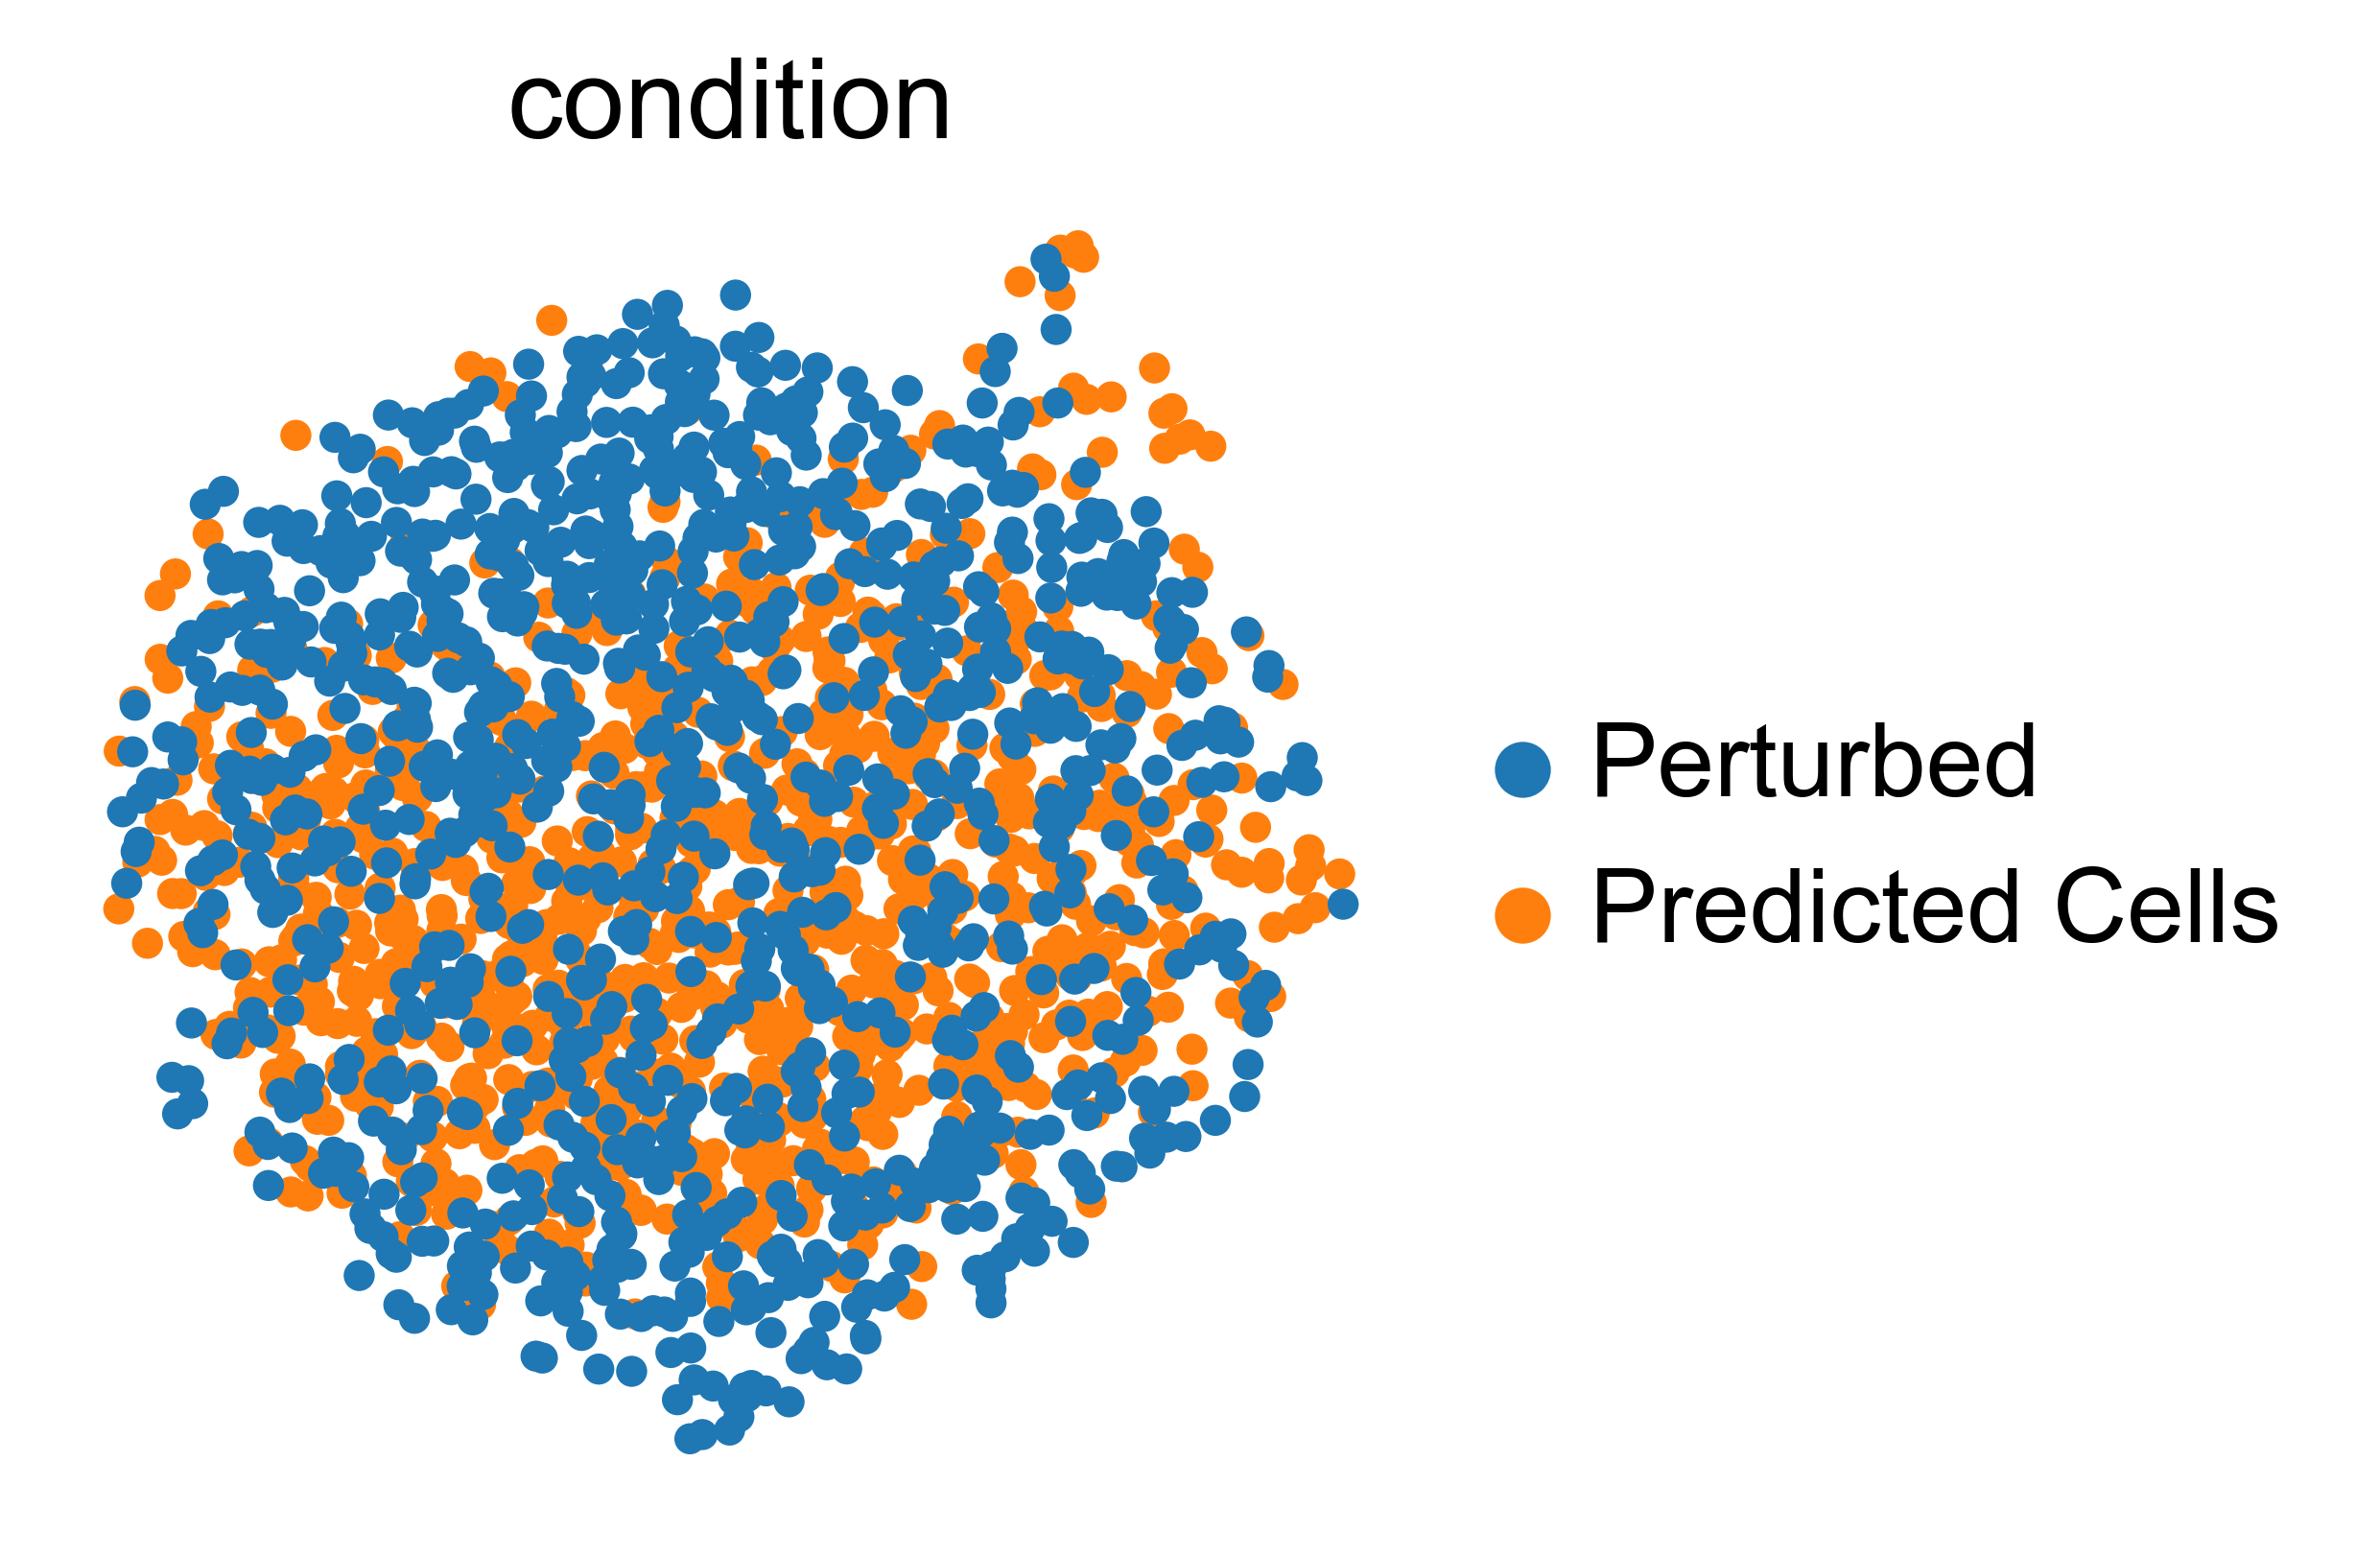

In [169]:
# create one hot encoding
batch_size = test_data.shape[0]
# index = 3 # index of the mapping cells

one_hot_encoded_vectors = one_hot_encode_torch(batch_size, c_dim, [gene_1_index])

# predicting section
G_AB.eval()
# anchor_index_oh = enc_batch.transform(np.array([batches[anchor_index]]).reshape(-1, 1)).toarray()[0].tolist().index(1.0)

with torch.no_grad():
    imgs = Variable(FloatTensor(test_data)).to(device_ids[0])
    src_labels = Variable(one_hot_encoded_vectors.type(FloatTensor)).to(device_ids[0])

    # torch.ones(imgs.size()[0]).long().cuda()
    static_sample = generate_data(G_AB, imgs, src_labels).cpu().detach().numpy()
    
output_results = static_sample

# creating the metadata for control cells
data = np.array(["Control"])
repeated_data = np.tile(data[np.newaxis, :], (batch_size, 1))
pred_meta = pd.DataFrame(repeated_data, columns=["condition"])
pred_meta["cell_type"] = np.array(control_test.obs["cell_type"])

# getting the true population and its metadata
true_perturb_pop = adata_test[adata_test.obs["condition"] == "%s" % (targeted_label)].X.toarray()
pop_meta = adata_test[adata_test.obs["condition"] == "%s" % (targeted_label)].obs

combine_meta = pd.concat([pred_meta[["condition", "cell_type"]], pop_meta[["condition", "cell_type"]]])
combine_gene_exp = np.concatenate([output_results, true_perturb_pop])

print(combine_meta.head())
print(combine_gene_exp.shape)

pred_adata = AnnData(
    X=combine_gene_exp,
    obs=combine_meta
)

# for reproducibility
setup_seed(8)

# pca = PCA(n_components = 50, random_state = 8)
# pca.fit(pred_adata.X)

pca = PCA(n_components = 50, random_state = 8)
pca.fit(adata.X)

pca_matrix = pca.components_

X_pca = pred_adata.X @ pca_matrix.T
pred_adata.obsm["X_pca"] = X_pca.copy()

# Sort by cell_type
# sorted_adata = pred_adata.obs.sort_values(by='condition')

# Apply the sorting to the AnnData object
# pred_adata = pred_adata[sorted_adata.index].copy()

# compute neighbor and plotting function
pred_adata.obs.condition.replace("Control", "Predicted Cells", inplace = True)

sc.pp.neighbors(pred_adata, use_rep='X_pca', n_neighbors=30)

# sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
sc.tl.umap(pred_adata)

custom_palette = cc.glasbey_category10

sc.pl.umap(pred_adata, color=["condition"],
           palette=custom_palette)

pred_adata.obs.condition.replace("Predicted Cells", "CellGen", inplace = True)

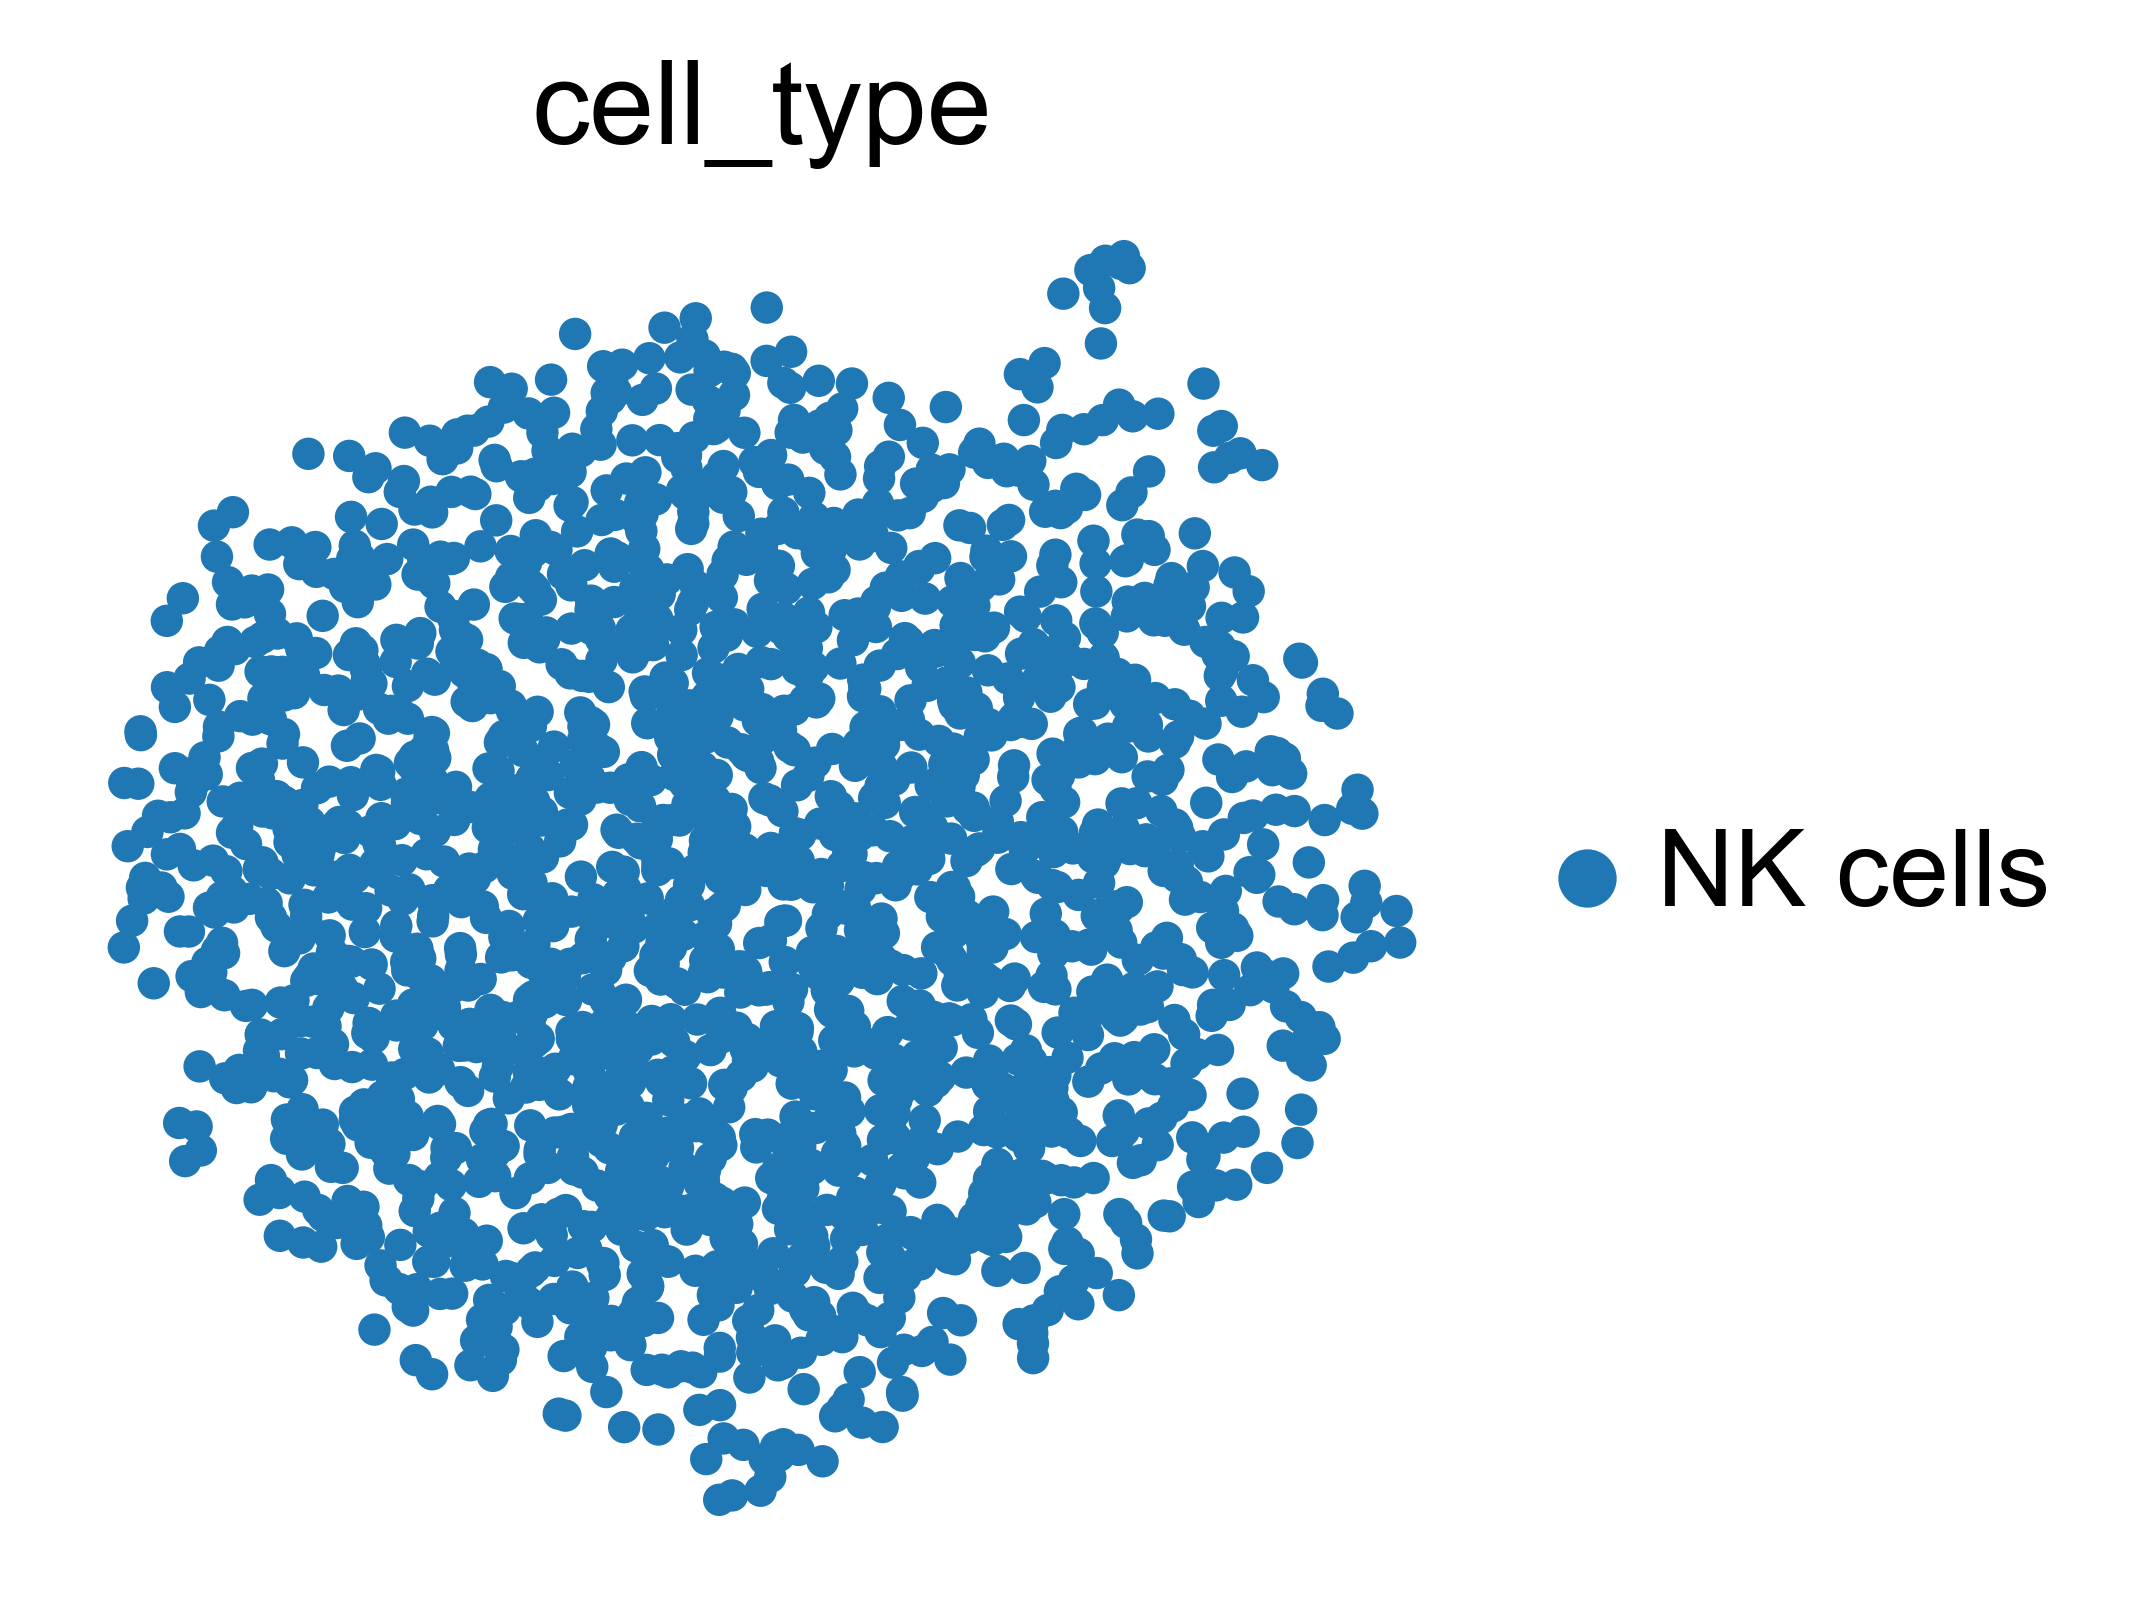

In [170]:
sc.pl.umap(pred_adata, color=["cell_type"],
           palette=custom_palette)

In [171]:
adata_test

AnnData object with n_obs × n_vars = 1981 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca'

In [173]:
output_results

array([[0.       , 4.191226 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 4.271616 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 4.0693383, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.676576 , 5.578546 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.3088227, 4.8231993, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [3.4213996, 6.2533298, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [174]:
true_perturb_pop

array([[0.        , 5.3170819 , 2.61551605, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.52219621, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 5.50674058, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 5.0604279 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.10538128, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.74464227, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [175]:
# pred_adata[pred_adata.obs.condition == "CellGen"].X.toarray()

In [176]:
# pred_adata.X

In [177]:
import ot

def sliced_wasserstein(pred, true, p = 200):
    return ot.sliced_wasserstein_distance(pred, true, n_projections = p)

def downsample_matrices(X, Y):
    """
    Downsamples the smaller matrix to match the size of the larger matrix.

    Args:
      X: First matrix (numpy array).
      Y: Second matrix (numpy array).

    Returns:
      X_downsampled: Downsampled version of X (numpy array).
      Y_downsampled: Downsampled version of Y (numpy array).
    """

    if X.shape[0] < Y.shape[0]:
        # Downsample Y
        indices = np.random.choice(Y.shape[0], size=X.shape[0], replace=False)
        Y_downsampled = Y[indices, :]
        X_downsampled = X
    elif X.shape[0] > Y.shape[0]:
        # Downsample X
        indices = np.random.choice(X.shape[0], size=Y.shape[0], replace=False)
        X_downsampled = X[indices, :]
        Y_downsampled = Y
    else:
        # No downsampling needed
        X_downsampled = X
        Y_downsampled = Y

    return X_downsampled, Y_downsampled

def get_mean_corr(A, B):
    feature_mean_corr = np.corrcoef(A.mean(0), B.mean(0))

    # Set the middle diagonal elements to zero
    np.fill_diagonal(feature_mean_corr, 0)

    feature_mean_corr = np.triu(feature_mean_corr)

    return np.nanmean(np.where(feature_mean_corr!=0,feature_mean_corr,np.nan))

In [178]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from typing import Iterable

def compute_lisi(
    X: np.array,
    metadata: pd.DataFrame,
    label_colnames: Iterable[str],
    perplexity: float=40
):
    """Compute the Local Inverse Simpson Index (LISI) for each column in metadata.
    LISI is a statistic computed for each item (row) in the data matrix X.
    The following example may help to interpret the LISI values.
    Suppose one of the columns in metadata is a categorical variable with 3 categories.
        - If LISI is approximately equal to 3 for an item in the data matrix,
          that means that the item is surrounded by neighbors from all 3
          categories.
        - If LISI is approximately equal to 1, then the item is surrounded by
          neighbors from 1 category.
    
    The LISI statistic is useful to evaluate whether multiple datasets are
    well-integrated by algorithms such as Harmony [1].
    [1]: Korsunsky et al. 2019 doi: 10.1038/s41592-019-0619-0
    """
    n_cells = metadata.shape[0]
    n_labels = len(label_colnames)
    # We need at least 3 * n_neigbhors to compute the perplexity
    knn = NearestNeighbors(n_neighbors = perplexity * 3, algorithm = 'kd_tree').fit(X)
    distances, indices = knn.kneighbors(X)
    # Don't count yourself
    indices = indices[:,1:]
    distances = distances[:,1:]
    # Save the result
    lisi_df = np.zeros((n_cells, n_labels))
    for i, label in enumerate(label_colnames):
        labels = pd.Categorical(metadata[label])
        n_categories = len(labels.categories)
        simpson = compute_simpson(distances.T, indices.T, labels, n_categories, perplexity)
        
#         print(simpson)
        lisi_df[:,i] = 1 / simpson
    return lisi_df

def compute_simpson(
    distances: np.ndarray,
    indices: np.ndarray,
    labels: pd.Categorical,
    n_categories: int,
    perplexity: float,
    tol: float=1e-5
):
    n = distances.shape[1]
    P = np.zeros(distances.shape[0])
    simpson = np.zeros(n)
    logU = np.log(perplexity)
    # Loop through each cell.
    for i in range(n):
        beta = 1
        betamin = -np.inf
        betamax = np.inf
        # Compute Hdiff
        P = np.exp(-distances[:,i] * beta)
        P_sum = np.sum(P)
        if P_sum == 0:
            H = 0
            P = np.zeros(distances.shape[0])
        else:
            H = np.log(P_sum) + beta * np.sum(distances[:,i] * P) / P_sum
            P = P / P_sum
        Hdiff = H - logU
        n_tries = 50
        for t in range(n_tries):
            # Stop when we reach the tolerance
            if abs(Hdiff) < tol:
                break
            # Update beta
            if Hdiff > 0:
                betamin = beta
                if not np.isfinite(betamax):
                    beta *= 2
                else:
                    beta = (beta + betamax) / 2
            else:
                betamax = beta
                if not np.isfinite(betamin):
                    beta /= 2
                else:
                    beta = (beta + betamin) / 2
            # Compute Hdiff
            P = np.exp(-distances[:,i] * beta)
            P_sum = np.sum(P)
            if P_sum == 0:
                H = 0
                P = np.zeros(distances.shape[0])
            else:
                H = np.log(P_sum) + beta * np.sum(distances[:,i] * P) / P_sum
                P = P / P_sum
            Hdiff = H - logU
        # distancesefault value
        if H == 0:
            simpson[i] = -1
        # Simpson's index
        for label_category in labels.categories:
            ix = indices[:,i]
            q = labels[ix] == label_category
            if np.any(q):
                P_sum = np.sum(P[q])
                simpson[i] += P_sum * P_sum
    return simpson

In [181]:
output_results

array([[0.       , 4.191226 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 4.271616 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 4.0693383, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.676576 , 5.578546 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.3088227, 4.8231993, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [3.4213996, 6.2533298, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [182]:
print(sliced_wasserstein(output_results, true_perturb_pop))
print(get_mean_corr(output_results, true_perturb_pop))

0.10336535781041073
0.9699230389115856


In [183]:
metric_data = {}

metric_data["CellGen"] = {"sliced_wasserstein": sliced_wasserstein(output_results, true_perturb_pop), "corr mean": get_mean_corr(output_results, true_perturb_pop)}

# Checking for density function of the gene

In [184]:
def uniform_downsample_array(input_array, target_size):
    """
    Perform uniform downsampling of the input array to a target size.

    Parameters:
    - input_array: numpy array to be downsampled.
    - target_size: size of the downsampled array.

    Returns:
    - downsampled_array: numpy array after uniform downsampling.
    """
    # Check if target size is greater than the length of the input array
    if target_size >= len(input_array):
        return input_array

    # Randomly choose indices without replacement
    chosen_indices = np.random.choice(np.arange(len(input_array)), size=target_size, replace=False)

    # Create the downsampled array
    downsampled_array = input_array[chosen_indices]

    return downsampled_array

In [185]:
targeted_label

'Perturbed'

In [186]:
# true_perturb_pop
dataset_name = "OOD"

In [187]:
# adding scGen as benchmarking analysis
scGen = pd.read_csv(f"scGen_{dataset_name}.csv")
CellOT = pd.read_csv(f"CellOT_{dataset_name}.csv")
Biolord = pd.read_csv(f"Biolord_{dataset_name}.csv")

metric_data["scGen"] = {"sliced_wasserstein": sliced_wasserstein(scGen.values, true_perturb_pop), "corr mean": get_mean_corr(scGen.values, true_perturb_pop)}
metric_data["CellOT"] = {"sliced_wasserstein": sliced_wasserstein(CellOT.values, true_perturb_pop), "corr mean": get_mean_corr(CellOT.values, true_perturb_pop)}
metric_data["Biolord"] = {"sliced_wasserstein": sliced_wasserstein(Biolord.values, true_perturb_pop), "corr mean": get_mean_corr(Biolord.values, true_perturb_pop)}

In [188]:
true_perturb_pop

array([[0.        , 5.3170819 , 2.61551605, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.52219621, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 5.50674058, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 5.0604279 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.10538128, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.74464227, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [189]:
metric_data

{'CellGen': {'sliced_wasserstein': 0.0973378097990052,
  'corr mean': 0.9699230389115856},
 'scGen': {'sliced_wasserstein': 0.28216630707695795,
  'corr mean': 0.9634466648519786},
 'CellOT': {'sliced_wasserstein': 0.2467904473512385,
  'corr mean': 0.9094563574568558},
 'Biolord': {'sliced_wasserstein': 0.5142263381645038,
  'corr mean': 0.7532426178584543}}

In [190]:
np.__version__

'1.24.3'

In [191]:
# setup_seed(8)
# plot_gene(gene_name = "VCAN")

In [192]:
# setup_seed(8)
# plot_gene(gene_name = "GPR160")

In [193]:
# setup_seed(8)
# plot_gene(gene_name = "MS4A6A")

In [194]:
# setup_seed(8)
# plot_gene(gene_name = "SERPINB2")

## Before mapping

In [195]:
# index = 3

In [196]:
adata_test.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.36317574, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 5.0604279 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.10538128, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.74464227, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [197]:
# adata[adata.obs.condition.isin([groups[gene_1_index]])].X.toarray()

In [198]:
control_test.var

ensg       symbol  n_cells     mt  n_cells_by_counts  \
40     ENSG00000188290         HES4     2308  False               2308   
42     ENSG00000187608        ISG15    14717  False              14717   
51     ENSG00000186891     TNFRSF18     1181  False               1181   
52     ENSG00000186827      TNFRSF4     1073  False               1073   
93     ENSG00000008130         NADK     1300  False               1300   
...                ...          ...      ...    ...                ...   
32597  ENSG00000215458  AP001053.11       22  False                 22   
32645  ENSG00000160255        ITGB2     1435  False               1435   
32647  ENSG00000183250     C21orf67        7  False                  7   
32667  ENSG00000173638      SLC19A1       62  False                 62   
32694  ENSG00000160307        S100B      179  False                179   

       mean_counts  pct_dropout_by_counts  total_counts  highly_variable  \
40        0.201119              90.573051        4924.0             True   
42       19.384553              39.888903      474592.0             True   
51        0.067720              95.176245        1658.0             True   
52        0.070580              95.617367        1728.0             True   
93        0.066454              94.690193        1627.0             True   
...            ...                    ...           ...              ...   
32597     0.001021              99.910142          25.0             True   
32645     0.070212              94.138790        1719.0             True   
32647     0.000327              99.971409           8.0             True   
32667     0.002859              99.746763          70.0             True   
32694     0.010742              99.268880         263.0             True   

       highly_variable_rank      means    variances  variances_norm  
40                    153.0   0.199484     0.709334        2.443036  
42                     30.0  19.284018  1997.603041        6.337730  
51                    812.0   0.067423     0.118719        1.402039  
52                    212.0   0.069715     0.186035        2.120175  
93                   1713.0   0.065867     0.096411        1.167216  
...                     ...        ...          ...             ...  
32597                1711.0   0.001023     0.001350        1.167305  
32645                1800.0   0.069551     0.101479        1.159425  
32647                1752.0   0.000327     0.000409        1.161625  
32667                1750.0   0.002866     0.003840        1.161985  
32694                 302.0   0.010766     0.023178        1.839301  

[2000 rows x 13 columns]

In [199]:
try:
    control_test.var.set_index("symbol", inplace = True)
except:
    control_test

In [200]:
try:
    adata_test.var.set_index("symbol", inplace = True)
except:
    adata_test

/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


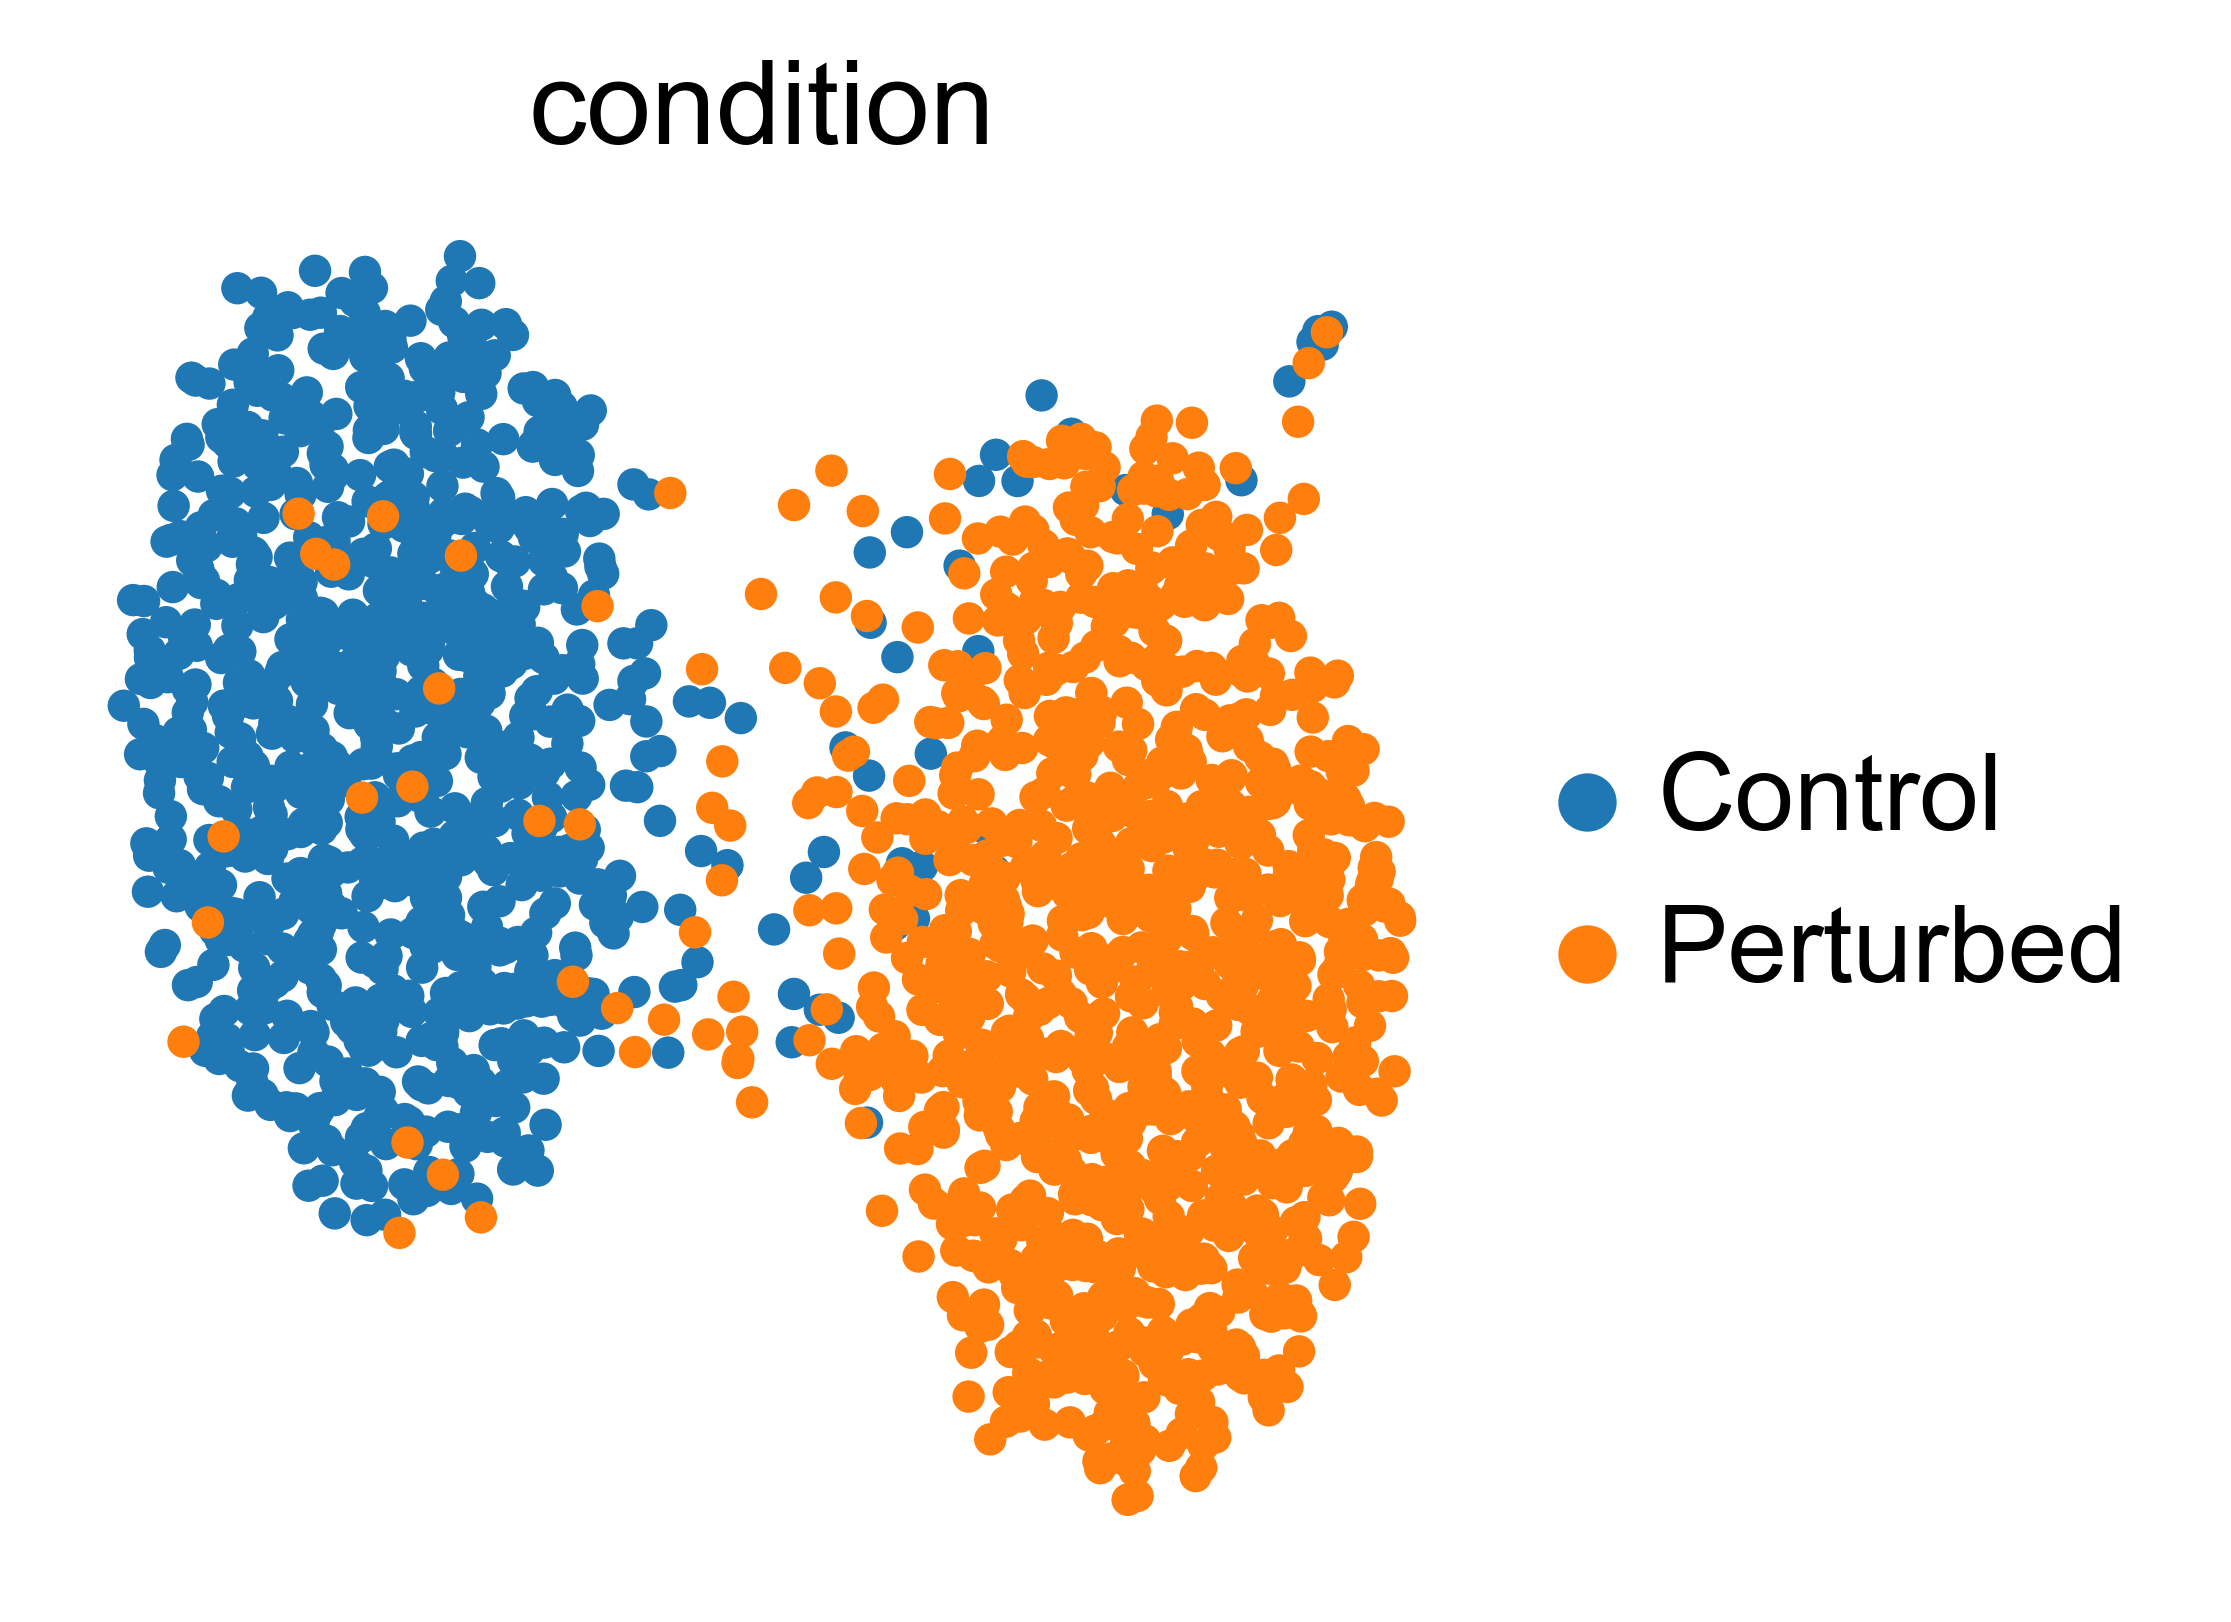

In [201]:
# get the categorical of the condition in aligning with the index and batch number properly
groups = adata.obs['condition'].cat.categories.tolist()

bef_adata = control_test.concatenate(adata_test[adata_test.obs.condition == targeted_label]).copy()
# bef_adata = bef_adata.concatenate(adata[adata.obs.condition.isin([groups[gene_1_index], groups[gene_2_index]])])
# bef_adata = bef_adata.concatenate(adata[adata.obs.condition.isin([groups[gene_1_index]])])

subadata = bef_adata
# plot the raw adata in the training sample
setup_seed(8)

# pca = PCA(n_components = 50, random_state = 8)
# pca.fit(subadata.X)

X_pca = subadata.X @ pca_matrix.T
subadata.obsm["X_pca"] = X_pca.copy()

sc.pp.neighbors(subadata, use_rep='X_pca', n_neighbors=30)
# sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
sc.tl.umap(subadata)

custom_palette = cc.glasbey_category10

sc.pl.umap(subadata, color=["condition"],
           palette=custom_palette)

In [202]:
# for the Control
control_expr = subadata[subadata.obs["condition"] == "Control"].copy().X
perturbed_expr = subadata[subadata.obs["condition"] == targeted_label].copy().X

print(sliced_wasserstein(control_expr, perturbed_expr))
print(get_mean_corr(control_expr, perturbed_expr))

0.23059715208951442
0.8144762939747537


In [203]:
metric_data["Control"] = {"sliced_wasserstein": sliced_wasserstein(control_expr, perturbed_expr), "corr mean": get_mean_corr(control_expr, perturbed_expr)}

In [204]:
# for observed data
perturbed_expr = subadata[subadata.obs["condition"] == targeted_label].copy().X

print(sliced_wasserstein(perturbed_expr, perturbed_expr))
print(get_mean_corr(perturbed_expr, perturbed_expr))

0.0
1.0


In [205]:
metric_data["Measured"] = {"sliced_wasserstein": sliced_wasserstein(perturbed_expr, perturbed_expr), "corr mean": get_mean_corr(perturbed_expr, perturbed_expr)}

In [206]:
# we can add data from other model later on when we can run the CellOT or GEAR or CPA
metric_data

{'CellGen': {'sliced_wasserstein': 0.0973378097990052,
  'corr mean': 0.9699230389115856},
 'scGen': {'sliced_wasserstein': 0.28216630707695795,
  'corr mean': 0.9634466648519786},
 'CellOT': {'sliced_wasserstein': 0.2467904473512385,
  'corr mean': 0.9094563574568558},
 'Biolord': {'sliced_wasserstein': 0.5142263381645038,
  'corr mean': 0.7532426178584543},
 'Control': {'sliced_wasserstein': 0.2217727684653394,
  'corr mean': 0.8144762939747537},
 'Measured': {'sliced_wasserstein': 0.0, 'corr mean': 1.0}}

In [207]:
data

array(['Control'], dtype='<U7')

In [208]:
sns.set_theme(style="whitegrid")
sc.settings.verbosity = 1

sc.settings.set_figure_params(
    dpi=300, frameon=False, figsize=(3, 3), facecolor='white')

/tmp/ipykernel_52281/3460883631.py:9: UserWarning: The palette list has more values (256) than needed (6), which may not be intended.
  sns.barplot(x = data.index, y = "sliced_wasserstein", data = data, palette = colors_list)


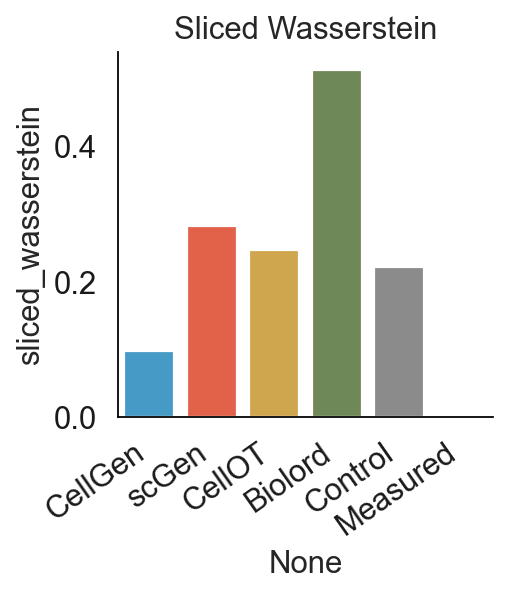

In [328]:
metric_data_df = pd.DataFrame(metric_data).transpose()

colors_list = cc.glasbey_hv

data = metric_data_df[["sliced_wasserstein"]]

# create desirable order of the x axis
data = data.loc[["CellGen", "scGen", "CellOT", "Biolord", "Control", "Measured"]]
sns.barplot(x = data.index, y = "sliced_wasserstein", data = data, palette = colors_list)

plt.grid(False)
# plt.xlabel('')
# plt.ylabel('Log-Scaled')
plt.xticks(rotation = 35, ha='right')
plt.title("Sliced Wasserstein")
sns.despine()

plot_save_svg()

In [210]:
# # Change to the iLISI metric

# metric_data_df = pd.DataFrame(metric_data).transpose()

# data = metric_data_df[["corr mean"]]
# sns.barplot(x = data.index, y = "corr mean", data = data, palette = colors_list)

# plt.grid(False)
# # plt.xlabel('')
# plt.ylabel('')
# plt.xticks(rotation = 90)
# plt.title("Average Correlation of feature mean")
# sns.despine()

## UMAP of all the models mapping from control to the perturb space

In [211]:
targeted_label

'Perturbed'

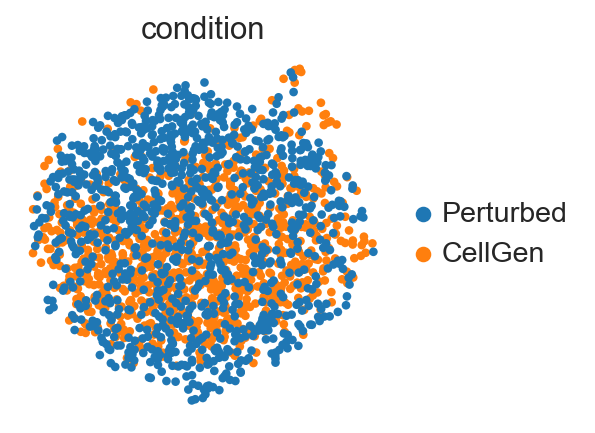

In [212]:
pred_adata.obs.condition = pred_adata.obs.condition.astype("category")
sc.pl.umap(pred_adata, color = "condition")

In [213]:
pred_adata.var = control_test.var

/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [215]:
# adding benchmarking models into the UMAP

model_name = "scGen"
model = pd.read_csv(f"{model_name}_{dataset_name}.csv")
new_temp = AnnData(model.values, obs = control_test.obs[["cell_type"]].copy())
new_temp.obs["condition"] = f"{model_name}"
# new_temp.obsm["X_pca"] = (model.values @ pca_matrix.T).copy()
new_temp.var = control_test.var

# # adding model predicted gene expression
full_adata = pred_adata.concatenate(new_temp)
full_adata

/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


AnnData object with n_obs × n_vars = 2915 × 2000
    obs: 'condition', 'cell_type', 'batch'
    var: 'ensg', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'

In [216]:
# adding benchmarking models into the UMAP
# Copy more for other benchmarking model

model_name = "CellOT"
model = pd.read_csv(f"{model_name}_{dataset_name}.csv")
model_pca = pd.read_csv(f"{model_name}_{dataset_name}_pca.csv") # using the PCA output from the cellot model
new_temp = AnnData(model.values, obs = control_test.obs[["cell_type"]].copy())
new_temp.obs["condition"] = f"{model_name}"
new_temp.obsm["X_pca"] = model_pca.values
new_temp.var = control_test.var

# adding model predicted gene expression
full_adata = full_adata.concatenate(new_temp) # change from pred_adata to full_adata as appending function
full_adata

/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


AnnData object with n_obs × n_vars = 3849 × 2000
    obs: 'condition', 'cell_type', 'batch'
    var: 'ensg', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'

In [217]:
# adding benchmarking models into the UMAP
# Copy more for other benchmarking model

model_name = "Biolord"
model = pd.read_csv(f"{model_name}_{dataset_name}.csv")
new_temp = AnnData(model.values, obs = control_test.obs[["cell_type"]].copy())
new_temp.obs["condition"] = f"{model_name}"
new_temp.obsm["X_pca"] = model.values @ pca_matrix.T
new_temp.var = control_test.var

# adding model predicted gene expression
full_adata = full_adata.concatenate(new_temp) # change from pred_adata to full_adata as appending function
full_adata

/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


AnnData object with n_obs × n_vars = 4783 × 2000
    obs: 'condition', 'cell_type', 'batch'
    var: 'ensg', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'

In [218]:
control_test.obsm["X_pca"] = control_test.X @ pca_matrix.T

/tmp/ipykernel_52281/3684797102.py:1: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  control_test.obsm["X_pca"] = control_test.X @ pca_matrix.T


In [219]:
observed_test = adata_test[adata_test.obs["condition"] == "Perturbed"].copy()
observed_test.obsm["X_pca"] = observed_test.X @ pca_matrix.T

observed_test.obs.condition.replace("Perturbed", "Measured", inplace = True)

In [220]:
# adata_test.var.reset_index(inplace = True)

full_adata.var = control_test.var.copy()
full_adata = full_adata.concatenate(control_test).copy()

# adding this to the fulladata for evaluating purpose
full_adata = full_adata.concatenate(observed_test).copy()


full_adata.obs.condition = full_adata.obs.condition.astype("category")

/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'NADK']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packag

In [221]:
full_adata.obs.condition

0-0-0-0-0-0            CellGen
1-0-0-0-0-0            CellGen
2-0-0-0-0-0            CellGen
3-0-0-0-0-0            CellGen
4-0-0-0-0-0            CellGen
                        ...   
TTTCAGTGAGCATC-1-1    Measured
TTTCAGTGCGAGAG-1-1    Measured
TTTCAGTGTCCGTC-1-1    Measured
TTTCCAGAGTCGAT-1-1    Measured
TTTCTACTTCAGAC-1-1    Measured
Name: condition, Length: 6764, dtype: category
Categories (7, object): ['Biolord', 'CellGen', 'CellOT', 'Control', 'Measured', 'Perturbed', 'scGen']

/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


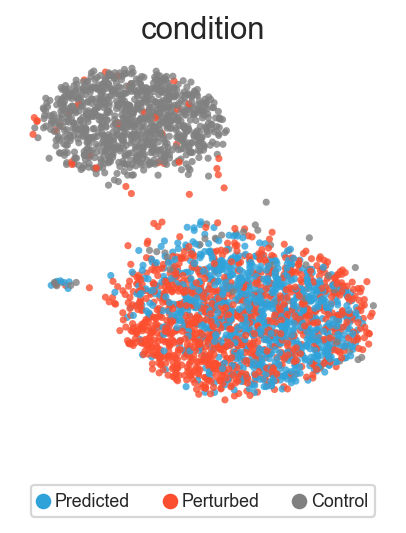

In [326]:
# model to plot
model_name = "CellGen"

model_list = [targeted_label, "Control", model_name]
plot_adata = full_adata[full_adata.obs["condition"].isin(model_list)].copy()

X_pca = plot_adata.X @ pca_matrix.T
plot_adata.obsm["X_pca"] = X_pca.copy()

sc.pp.neighbors(plot_adata, use_rep='X_pca', n_neighbors=30)
# sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
sc.tl.umap(plot_adata)

# comment it out for raw data
plot_adata.obs.condition.replace(model_name, "Predicted", inplace = True)

desired_order = ["Predicted", "Perturbed", "Control"]
plot_adata.obs['condition'] = plot_adata.obs['condition'].cat.reorder_categories(desired_order)

# random ordering to better see the mixing and seperation of the cells.
custom_palette = cc.glasbey_hv

customed_color = custom_palette[:2]
customed_color.append("grey")

setup_seed(8)
random_indices=np.random.permutation(list(range(plot_adata.shape[0])))
sc.pl.umap(plot_adata[random_indices, :], color=["condition"], alpha = 0.8, legend_fontsize = 9, return_fig = True,
           palette=customed_color)

plot_adata.obs['condition'] = plot_adata.obs['condition'].cat.reorder_categories(desired_order)

plt.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.3), fontsize = 8, ncol = 8)
plot_save_svg()

In [223]:
# sc.pl.umap(plot_adata[random_indices, :], color=["cell_type"], alpha = 0.8, legend_fontsize = 9, return_fig = True,
#            palette=custom_palette)

# plt.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.3), fontsize = 8, ncol = 8)
# plot_save_svg()

In [224]:
# full_adata = full_adata[full_adata.obs["condition"].isin(["KLF1", "CellGen"])]

In [225]:
# full_adata[full_adata.obs["condition"].isin(sub_model)].copy()

## compute for the iLISI metric

In [226]:
# define model to compute for the ilisi score

def compute_ilisi(model_name, full_adata):

    # subset to the model of interest
    sub_model = [targeted_label, model_name]
    
    metric_adata = full_adata[full_adata.obs["condition"].isin(sub_model)].copy()
    
    X_array_test = metric_adata.X @ pca_matrix.T
    metadata = metric_adata.obs
    
    # computing the ilisi score
    batch_str = "condition"
    ilisi = compute_lisi(X_array_test, metadata, [batch_str])
    
    # for scaling purpose
    # ilisi = (ilisi - 1) / (n_batch - 1)
    
    temp_df = pd.DataFrame({"score": ilisi.transpose().reshape(-1),
                  "meta": metadata[batch_str].values})
    
    gp_temp_df_raw = temp_df.groupby("meta")
    
    # Calculate the median and IQR for each group
    summary_stats = gp_temp_df_raw['score'].agg(
        median = np.nanmedian,
        q1 = lambda x: np.percentile(x, 25),
        q3 = lambda x: np.percentile(x, 75)
    )
    
    # Calculate the IQR
    summary_stats['iqr'] = summary_stats['q3'] - summary_stats['q1']
    
    # Display the summary statistics
    summary_stats[["median", "iqr"]].round(5)

    # return the average of the median lisi score for each condition
    return summary_stats["median"].mean().round(3)

compute_ilisi("Measured", full_adata)

1.769

In [227]:
metric_data.keys()

dict_keys(['CellGen', 'scGen', 'CellOT', 'Biolord', 'Control', 'Measured'])

In [228]:
full_adata.obs["condition"].unique()

['CellGen', 'Perturbed', 'scGen', 'CellOT', 'Biolord', 'Control', 'Measured']
Categories (7, object): ['Biolord', 'CellGen', 'CellOT', 'Control', 'Measured', 'Perturbed', 'scGen']

In [229]:
metric_data["scGen"]["iLISI"] = compute_ilisi("scGen", full_adata)
metric_data["CellGen"]["iLISI"] = compute_ilisi("CellGen", full_adata)
metric_data["Biolord"]["iLISI"] = compute_ilisi("Biolord", full_adata)
metric_data["CellOT"]["iLISI"] = compute_ilisi("CellOT", full_adata)
metric_data["Control"]["iLISI"] = compute_ilisi("Control", full_adata)
metric_data["Measured"]["iLISI"] = compute_ilisi("Measured", full_adata)

In [230]:
metric_data

{'CellGen': {'sliced_wasserstein': 0.0973378097990052,
  'corr mean': 0.9699230389115856,
  'iLISI': 1.691},
 'scGen': {'sliced_wasserstein': 0.28216630707695795,
  'corr mean': 0.9634466648519786,
  'iLISI': 1.081},
 'CellOT': {'sliced_wasserstein': 0.2467904473512385,
  'corr mean': 0.9094563574568558,
  'iLISI': 1.739},
 'Biolord': {'sliced_wasserstein': 0.5142263381645038,
  'corr mean': 0.7532426178584543,
  'iLISI': 1.0},
 'Control': {'sliced_wasserstein': 0.2217727684653394,
  'corr mean': 0.8144762939747537,
  'iLISI': 1.008},
 'Measured': {'sliced_wasserstein': 0.0, 'corr mean': 1.0, 'iLISI': 1.769}}

/tmp/ipykernel_52281/3505838014.py:9: UserWarning: The palette list has more values (256) than needed (6), which may not be intended.
  sns.barplot(x = data.index, y = "iLISI", data = data, palette = colors_list)


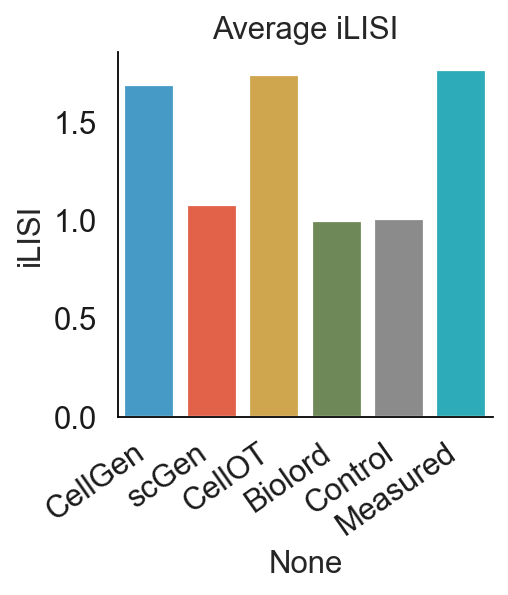

In [231]:
metric_data_df = pd.DataFrame(metric_data).transpose()

colors_list = cc.glasbey_hv

data = metric_data_df[["iLISI"]]

# create desirable order of the x axis
data = data.loc[["CellGen", "scGen", "CellOT", "Biolord", "Control", "Measured"]]
sns.barplot(x = data.index, y = "iLISI", data = data, palette = colors_list)

plt.grid(False)
# plt.xlabel('')
# plt.ylabel('Log-Scaled')
plt.xticks(rotation = 35, ha = "right")
plt.title("Average iLISI")
sns.despine()

In [232]:
from sklearn.metrics.pairwise import rbf_kernel

def mmd_distance(x, y, gamma):
    xx = rbf_kernel(x, x, gamma)
    xy = rbf_kernel(x, y, gamma)
    yy = rbf_kernel(y, y, gamma)

    return xx.mean() + yy.mean() - 2 * xy.mean()
    
def compute_mmd_loss(lhs, rhs, gammas):
    return np.mean([mmd_distance(lhs, rhs, g) for g in gammas])

def compute_scalar_mmd(target, transport, gammas=None):
    if gammas is None:
        gammas = [2, 1, 0.5, 0.1, 0.01, 0.005]

    def safe_mmd(*args):
        try:
            mmd = mmd_distance(*args)
        except ValueError:
            mmd = np.nan
        return mmd

    return np.mean(list(map(lambda x: safe_mmd(target, transport, x), gammas)))

In [233]:
def compute_mmd_metric(model_name, full_adata):
    
    pred_adata = full_adata[full_adata.obs["condition"].isin([model_name])].copy()
    X_pred = pred_adata.X.copy()
    # print(X_pred)
    
    obs_adata = full_adata[full_adata.obs["condition"].isin([targeted_label])].copy()
    X_true = obs_adata.X.copy()
    
    return compute_scalar_mmd(X_true, X_pred).round(4)

In [234]:
metric_data["scGen"]["MMD"] = compute_mmd_metric("scGen", full_adata)
metric_data["CellGen"]["MMD"] = compute_mmd_metric("CellGen", full_adata)
metric_data["Biolord"]["MMD"] = compute_mmd_metric("Biolord", full_adata)
metric_data["CellOT"]["MMD"] = compute_mmd_metric("CellOT", full_adata)
metric_data["Control"]["MMD"] = compute_mmd_metric("Control", full_adata)
metric_data["Measured"]["MMD"] = compute_mmd_metric("Measured", full_adata)

In [235]:
compute_mmd_metric("CellGen", full_adata)

0.0038

In [236]:
full_adata.obs.condition

0-0-0-0-0-0            CellGen
1-0-0-0-0-0            CellGen
2-0-0-0-0-0            CellGen
3-0-0-0-0-0            CellGen
4-0-0-0-0-0            CellGen
                        ...   
TTTCAGTGAGCATC-1-1    Measured
TTTCAGTGCGAGAG-1-1    Measured
TTTCAGTGTCCGTC-1-1    Measured
TTTCCAGAGTCGAT-1-1    Measured
TTTCTACTTCAGAC-1-1    Measured
Name: condition, Length: 6764, dtype: category
Categories (7, object): ['Biolord', 'CellGen', 'CellOT', 'Control', 'Measured', 'Perturbed', 'scGen']

In [237]:
full_adata.obs["condition"].isin(["CellGen"])

0-0-0-0-0-0            True
1-0-0-0-0-0            True
2-0-0-0-0-0            True
3-0-0-0-0-0            True
4-0-0-0-0-0            True
                      ...  
TTTCAGTGAGCATC-1-1    False
TTTCAGTGCGAGAG-1-1    False
TTTCAGTGTCCGTC-1-1    False
TTTCCAGAGTCGAT-1-1    False
TTTCTACTTCAGAC-1-1    False
Name: condition, Length: 6764, dtype: bool

In [238]:
pd.DataFrame(metric_data)

CellGen     scGen    CellOT   Biolord   Control  Measured
sliced_wasserstein  0.097338  0.282166  0.246790  0.514226  0.221773     0.000
corr mean           0.969923  0.963447  0.909456  0.753243  0.814476     1.000
iLISI               1.691000  1.081000  1.739000  1.000000  1.008000     1.769
MMD                 0.003800  0.146700  0.073400  0.383100  0.008700     0.000

/tmp/ipykernel_52281/240030257.py:9: UserWarning: The palette list has more values (256) than needed (6), which may not be intended.
  sns.barplot(x = data.index, y = "MMD", data = data, palette = colors_list)


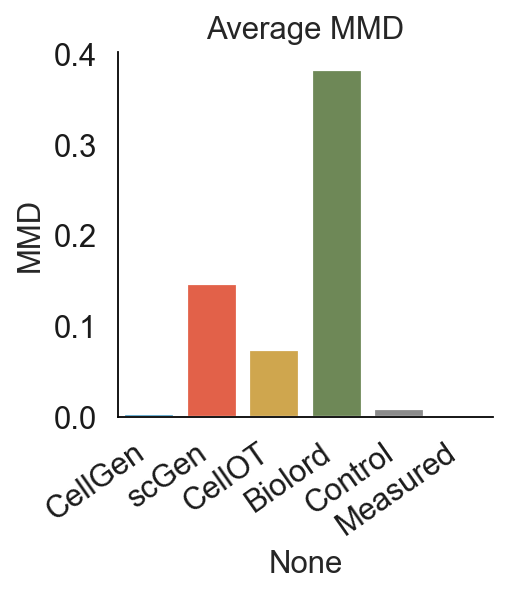

In [329]:
metric_data_df = pd.DataFrame(metric_data).transpose()

colors_list = cc.glasbey_hv

data = metric_data_df[["MMD"]]

# create desirable order of the x axis
data = data.loc[["CellGen", "scGen", "CellOT", "Biolord", "Control", "Measured"]]
sns.barplot(x = data.index, y = "MMD", data = data, palette = colors_list)

plt.grid(False)
# plt.xlabel('')
# plt.ylabel('Log-Scaled')
plt.xticks(rotation = 35, ha = "right")
plt.title("Average MMD")
sns.despine()

plot_save_svg()

In [240]:
def compute_pairwise_corrs(df):
    corr = df.corr().rename_axis(index='lhs', columns='rhs')
    return (
        corr
        .where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .reset_index()
        .set_index(['lhs', 'rhs'])
        .squeeze()
        .rename()
    )

# def compute_mmd_metric(model_name, full_adata):


def compute_r2_feature(model_name, full_adata):
    
    pred_adata = full_adata[full_adata.obs["condition"].isin([model_name])].copy()
    X_pred = pred_adata.X
    
    obs_adata = full_adata[full_adata.obs["condition"].isin([targeted_label])].copy()
    X_true = obs_adata.X
    
    pwct = compute_pairwise_corrs(pd.DataFrame(X_true))
    pwci = compute_pairwise_corrs(pd.DataFrame(X_pred))
    
    return pd.Series.corr(pwct, pwci).round(4)

def compute_r2_mean(model_name, full_adata):
    
    pred_adata = full_adata[full_adata.obs["condition"].isin([model_name])].copy()
    X_pred = pred_adata.X
    
    obs_adata = full_adata[full_adata.obs["condition"].isin([targeted_label])].copy()
    X_true = obs_adata.X
    
    return pd.Series.corr(pd.Series(X_true.mean(0)), pd.Series(X_pred.mean(0))).round(4)

In [241]:
metric_data["scGen"]["r2"] = compute_r2_feature("scGen", full_adata)
metric_data["CellGen"]["r2"] = compute_r2_feature("CellGen", full_adata)
metric_data["Biolord"]["r2"] = compute_r2_feature("Biolord", full_adata)
metric_data["CellOT"]["r2"] = compute_r2_feature("CellOT", full_adata)
metric_data["Control"]["r2"] = compute_r2_feature("Control", full_adata)
metric_data["Measured"]["r2"] = compute_r2_feature("Measured", full_adata)

/tmp/ipykernel_52281/2404897297.py:9: UserWarning: The palette list has more values (256) than needed (6), which may not be intended.
  sns.barplot(x = data.index, y = "r2", data = data, palette = colors_list)


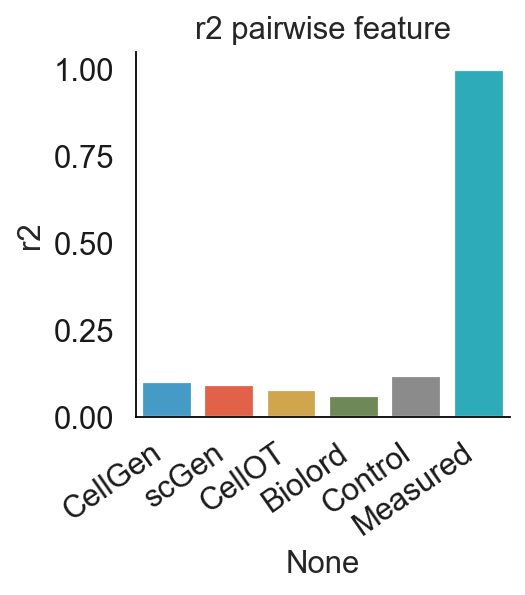

In [330]:
metric_data_df = pd.DataFrame(metric_data).transpose()

colors_list = cc.glasbey_hv

data = metric_data_df[["r2"]]

# create desirable order of the x axis
data = data.loc[["CellGen", "scGen", "CellOT", "Biolord", "Control", "Measured"]]
sns.barplot(x = data.index, y = "r2", data = data, palette = colors_list)

plt.grid(False)
# plt.xlabel('')
# plt.ylabel('Log-Scaled')
plt.xticks(rotation = 35, ha = "right")
plt.title("r2 pairwise feature")
sns.despine()
plot_save_svg()

## Computing for the nearest neighbor

In [243]:
def find_mutual_nearest_neighbors(data1, data2, k=1):
    # Find nearest neighbors
    nn1 = NearestNeighbors(n_neighbors=k).fit(data1)
    nn2 = NearestNeighbors(n_neighbors=k).fit(data2)
    dist1, ind1 = nn1.kneighbors(data2)  
    dist2, ind2 = nn2.kneighbors(data1) 

    # Identify MNN pairs
    mnn_pairs = []
    for i in range(len(data1)):
        for j in ind2[i]:
            if i in ind1[j]:
                mnn_pairs.append([i, j])  # Store as (index in data1, index in data2)
    return np.array(mnn_pairs)

In [244]:
def compute_pairwise_corr_MNN(model_name, full_adata):
    pred_adata = full_adata[full_adata.obs["condition"].isin([model_name])].copy()
    X_pred = pred_adata.X
    # with relu activation for all
    # X_pred = np.maximum(0, pred_adata.X)
    
    obs_adata = full_adata[full_adata.obs["condition"].isin([targeted_label])].copy()
    X_true = obs_adata.X

    corr_score_list = []

    # find the correlation for each of the genes
    for i in range(X_pred.shape[1]):
        corr_score = pd.Series.corr(pd.Series(X_true[:, i]), pd.Series(X_pred[:, i])).round(4)
        if math.isnan(corr_score):
            # corr_score_list.append(1.0)
            continue
        corr_score_list.append(corr_score)

    return corr_score_list

In [245]:
# compute for number of MNN pairs and its r2 metric
def compute_mnn_r2(model_name, full_adata, degs = None):    
    model_list = [targeted_label, model_name]
    
    mnn_adata = full_adata[full_adata.obs["condition"].isin(model_list)].copy()
    
    # seperate matrix into pred and observed
    stim_data = mnn_adata[mnn_adata.obs["condition"].isin([targeted_label])].copy().X @ pca_matrix.T
    stim_index_list = mnn_adata[mnn_adata.obs["condition"].isin([targeted_label])].copy().obs.index
    pred_data = mnn_adata[mnn_adata.obs["condition"].isin([model_name])].copy().X @ pca_matrix.T
    pred_index_list = mnn_adata[mnn_adata.obs["condition"].isin([model_name])].copy().obs.index
    
    mnn_pairs = find_mutual_nearest_neighbors(pred_data, stim_data)
    n_mnn_pairs = len(mnn_pairs)

    # get the concatenated index
    mnn_stim = list(stim_index_list[mnn_pairs[:, 1]])
    mnn_pred = list(pred_index_list[mnn_pairs[:, 0]])
    mnn_total_index =  np.array(mnn_pred + mnn_stim)
    
    mnn_adata = mnn_adata[mnn_total_index].copy()

    if degs:
        mnn_adata = mnn_adata[:, degs].copy()
    
    return n_mnn_pairs, compute_pairwise_corr_MNN(model_name, mnn_adata)

# compute_mnn_r2("CellGen", full_adata)

In [246]:
metric_data["CellGen"]["MNN_Pairs"], metric_data["CellGen"]["MNN_corr"] = compute_mnn_r2("CellGen", full_adata)
metric_data["scGen"]["MNN_Pairs"], metric_data["scGen"]["MNN_corr"] = compute_mnn_r2("scGen", full_adata)
metric_data["Biolord"]["MNN_Pairs"], metric_data["Biolord"]["MNN_corr"] = compute_mnn_r2("Biolord", full_adata)
metric_data["CellOT"]["MNN_Pairs"], metric_data["CellOT"]["MNN_corr"] = compute_mnn_r2("CellOT", full_adata)
metric_data["Control"]["MNN_Pairs"], metric_data["Control"]["MNN_corr"] = compute_mnn_r2("Control", full_adata)
metric_data["Measured"]["MNN_Pairs"], metric_data["Measured"]["MNN_corr"] = compute_mnn_r2("Measured", full_adata)

/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rom/miniforge3/envs/genex/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= st

/tmp/ipykernel_52281/276222778.py:9: UserWarning: The palette list has more values (256) than needed (5), which may not be intended.
  sns.barplot(x = data.index, y = "MNN_Pairs", data = data, palette = colors_list)


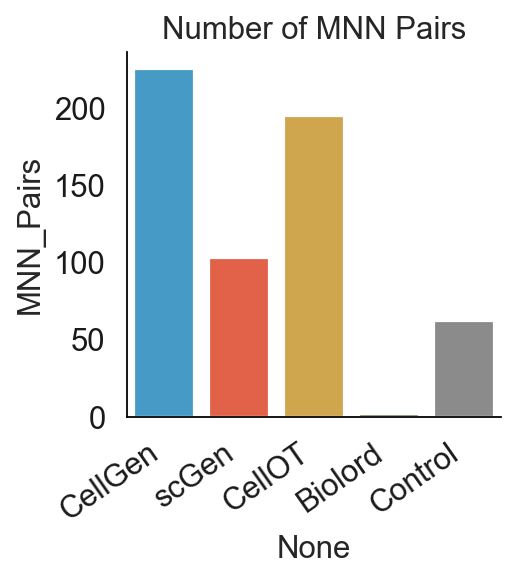

In [332]:
metric_data_df = pd.DataFrame(metric_data).transpose()

colors_list = cc.glasbey_hv

data = metric_data_df[["MNN_Pairs"]]

# create desirable order of the x axis
data = data.loc[["CellGen", "scGen", "CellOT", "Biolord", "Control"]]
sns.barplot(x = data.index, y = "MNN_Pairs", data = data, palette = colors_list)

plt.grid(False)
# plt.xlabel('')
# plt.ylabel('Log-Scaled')
plt.xticks(rotation = 35, ha = "right")
plt.title("Number of MNN Pairs")
sns.despine()
plot_save_svg()

In [248]:
try:
    full_adata.var.set_index("symbol", inplace = True)
except:
    full_adata

In [249]:
# metric_data_df = pd.DataFrame(metric_data).transpose()

# colors_list = cc.glasbey_hv

# data = metric_data_df[["MNN_corr"]]
# data = data.loc[["CellGen", "scGen", "CellOT", "Control"]]
# data = data.explode("MNN_corr")
# data.reset_index(inplace = True)
# data.columns = ["model", "MNN_corr"]
# data["MNN_corr"] = pd.to_numeric(data["MNN_corr"])
# # data

# # # create desirable order of the x axis

# sns.boxplot(x = "model", y = "MNN_corr", data = data, palette = colors_list, orient = "v")

# plt.grid(False)
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks(rotation = 35, ha = "right")
# plt.title("Correlation of MNN pairs")
# sns.despine()

## Correlation based on the DEGs

In [250]:
def compute_logfc(cell_adata, group, group_name, layer):
#     cell_adata = deg_adata[deg_adata.obs["CellType"] == cell_type_name]
    group_list = sorted(list(set(cell_adata.obs[group_name])))
    
    pseudocount = 1

    group_A = cell_adata[cell_adata.obs[group_name] == group] #BMA
    group_A_log = np.log2(np.mean(np.expm1(group_A.layers[layer].toarray()), axis = 0) + pseudocount)
    
    list_logfc = []
    
    for each in group_list:
        if each != group:
            group_B = cell_adata[cell_adata.obs[group_name] == each] #LLN
            group_B_log = np.log2(np.mean(np.expm1(group_B.layers[layer].toarray()), axis = 0) + pseudocount)

    #         logfc = pd.DataFrame(np.around(group_A_log - group_B_log, 4), index = cell_adata.var.index, columns = ["logfc"])
            logfc = np.around(group_A_log - group_B_log, 4)
            list_logfc.append(logfc)
    if len(list_logfc) == 1:
        return pd.DataFrame(list_logfc[0], index = cell_adata.var.index, columns = ["logfc"])
    else:
        return pd.DataFrame(np.mean(list_logfc, axis = 0), index = cell_adata.var.index, columns = ["logfc"])

In [252]:
try:
    adata_test.var.set_index("symbol", inplace = True)
except:
    adata_test

adata_test_deg = adata_test.copy()

adata_test_deg

AnnData object with n_obs × n_vars = 1981 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca'

In [256]:
from scipy import stats
from sklearn.metrics import r2_score
def plot_gene_pair(gene_name, model_name, full_adata):

    model_list = [targeted_label, model_name]
    
    mnn_adata = full_adata[full_adata.obs["condition"].isin(model_list)].copy()
    
    # seperate matrix into pred and observed
    stim_data = mnn_adata[mnn_adata.obs["condition"].isin([targeted_label])].copy().X @ pca_matrix.T
    stim_index_list = mnn_adata[mnn_adata.obs["condition"].isin([targeted_label])].copy().obs.index
    pred_data = mnn_adata[mnn_adata.obs["condition"].isin([model_name])].copy().X @ pca_matrix.T
    pred_index_list = mnn_adata[mnn_adata.obs["condition"].isin([model_name])].copy().obs.index
    
    mnn_pairs = find_mutual_nearest_neighbors(pred_data, stim_data)
    n_mnn_pairs = len(mnn_pairs)

    # get the concatenated index
    mnn_stim = list(stim_index_list[mnn_pairs[:, 1]])
    mnn_pred = list(pred_index_list[mnn_pairs[:, 0]])
    mnn_total_index =  np.array(mnn_pred + mnn_stim)
    
    mnn_adata = mnn_adata[mnn_total_index].copy()

    # first get list of the genes index
    all_genes = mnn_adata.var.index.values

    # supply gene name to find the index for predicted and observed gene expression
#     gene_name = "PSMB8"
    gene_index = np.where(all_genes == gene_name)[0][0]

    # align the cell to its neighbour cells by subsetting
    output_results = mnn_adata[mnn_adata.obs["condition"] == model_name].copy()[np.array(mnn_pred)].X
    true_perturb_pop = mnn_adata[mnn_adata.obs["condition"].isin([targeted_label])].copy()[np.array(mnn_stim)].X
    gene_pred = output_results[:, gene_index]
    gene_obs = true_perturb_pop[:, gene_index]

    # pearson correlation
    gene_corr = pd.Series.corr(pd.Series(gene_pred), pd.Series(gene_obs)).round(4)
    # print(gene_corr)

    sns.set_palette(colors_list)
    
    # adding plotting data
    alpha = 1.
    
    # sns.kdeplot(gene_control, label = "Control", alpha = alpha, common_norm=False, color = "#b1d1fc")
    # sns.scatterplot(x = gene_pred, y = gene_obs, alpha = 0.8)

    # # 2. Linear Regression 
    slope, intercept, r_value, p_value, std_err = stats.linregress(gene_pred, gene_obs)
    # line = slope * gene_pred + intercept

    # Calculate R-squared
    # y_true = gene_obs
    # y_pred = gene_pred
    # SS_tot = np.sum((y_true - y_true.mean())**2)  # Total sum of squares
    # SS_res = np.sum((y_true - y_pred)**2)          # Residual sum of squares
    # r2 = 1 - (SS_res / SS_tot)
    # print("R-squared:", r2)
    
    # Calculate Adjusted R-squared
    # n = len(y_true)
    # p = 1  # Number of independent variables in your model
    # adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    # print("Adjusted R-squared:", adjusted_r2)
    
    # # 3. Plot the Regression Line
    # plt.plot(gene_pred, line, 'black', label='Fitted line', alpha = 0.8)

    sns.regplot(x = gene_pred, y = gene_obs, line_kws=dict(color="black", alpha=0.8), scatter_kws=dict(alpha=0.8))
    
    # adding legend
    # plt.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.3), fontsize = 8, ncol = 4)
    plt.xlabel('Predicted')
    plt.ylabel('Observed')
    plt.grid(False)

    plt.text(1.05, 1.05, f'R-2: {r_value**2:.3f}', fontsize = 11, bbox=dict(facecolor='lightgrey', alpha=0.8, edgecolor='grey'),
         ha='right', va='top', transform=plt.gca().transAxes)

    sns.despine()

    plt.show()

In [257]:
# plot_gene_pair("CXCL10", "CellGen", full_adata)

In [258]:
# plot_gene_pair("CXCL10", "CellOT", full_adata)

In [259]:
group_name = "condition"
groups = sorted(list(set(adata_test_deg.obs[group_name])))
# groups = sorted(list(set(adata_int.obs["Group"])))

groups

['Control', 'Perturbed']

In [260]:
# get the maximum number of DEGs in the dataset
# len(get_deg(adata_test_deg, top = 50))

In [261]:
celltype_list = list(adata_test.obs["cell_type"].unique())
celltype_list

['NK cells']

In [262]:
def get_deg(adata_test_deg, layer_name = "X_raw", top = 20):

    '''
    layer_name must be either X_raw or X_pred
    '''
    adata_test_deg.layers[layer_name] = adata_test_deg.X.copy()
    
    # uncomment for raw data degs
    adata_test_deg.obsm[f'{layer_name}_pca'] = adata_test_deg.layers[layer_name] @ pca_matrix.T
    sc.tl.dendrogram(adata_test_deg, use_rep = f'{layer_name}_pca', groupby = group_name, optimal_ordering=False)
    
    group_index = 1
    adata_test_deg.X = adata_test_deg.layers[layer_name]
    adata_test_deg.X[adata_test_deg.X < 1] = 0
    adata_test_deg.layers[layer_name] = adata_test_deg.X.copy()
    sc.tl.rank_genes_groups(adata_test_deg, group_name, method='wilcoxon', use_raw = False, corr_method='benjamini-hochberg', layer = layer_name, pts = True)

    deg_fc = compute_logfc(adata_test_deg, groups[group_index], group_name, layer_name)

    
    deg_df = sc.get.rank_genes_groups_df(adata_test_deg, group = groups[group_index], key='rank_genes_groups')
    deg_df.set_index("names", inplace = True)
    # deg_df = deg_df.loc[genes]
    deg_df["logfoldchanges"] = deg_fc

    # setting the filter parameters
    # deg_df = deg_df[(deg_df["pct_nz_group"] >= 0.5) & (deg_df["pct_nz_reference"] >= 0.05) & (deg_df["pvals_adj"] < 0.05)]

    deg_df = deg_df[(deg_df["pvals_adj"] < 0.05)]
    
    filtered_deg = deg_df.sort_values("logfoldchanges", ascending = False)
    
    raw_deg = list(filtered_deg.index.values)

    # we only want to get top 20
    return raw_deg[:top]

In [263]:
from sklearn.metrics import ndcg_score

def compute_jaccard_index(real_top_k, generated_top_k):
    set_real = set(real_top_k)
    set_generated = set(generated_top_k)
    intersection = len(set_real & set_generated)
    union = len(set_real | set_generated)
    return intersection / union

def compute_mrr(real_rankings, generated_rankings):
    reciprocal_rank = 0
    for rank, item in enumerate(generated_rankings):
        if item in real_rankings:
            reciprocal_rank = 1 / (rank + 1)
            break
    return reciprocal_rank

from scipy.stats import kendalltau

def compute_kendall_tau(real_rankings, generated_rankings):
    tau, _ = kendalltau(real_rankings, generated_rankings)
    return tau

def top_k_precision_recall(real_top_k, generated_top_k, k):
    """
    Computes the precision and recall at top-K.
    
    Arguments:
    - real_top_k: List or tensor of the top-K items in the ground truth.
    - generated_top_k: List or tensor of the top-K items in the predicted ranking.
    - k: The number of top elements to consider.
    
    Returns:
    - precision: Precision at top-K.
    - recall: Recall at top-K.
    """
    set_real = set(real_top_k[:k])
    set_generated = set(generated_top_k[:k])
    
    true_positives = len(set_real & set_generated)
    
    precision = true_positives / k
    recall = true_positives / len(set_real)
    
    return precision, recall

def top_k_f1_score(real_top_k, generated_top_k, k):
    """
    Computes the F1 score at top-K.
    
    Arguments:
    - real_top_k: List or tensor of the top-K items in the ground truth.
    - generated_top_k: List or tensor of the top-K items in the predicted ranking.
    - k: The number of top elements to consider.
    
    Returns:
    - f1_score: The F1 score at top-K.
    """
    precision, recall = top_k_precision_recall(real_top_k, generated_top_k, k)
    
    if precision + recall == 0:
        return 0.0
    
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [264]:
import rbo

def compute_rbo(adata_test_deg, full_adata, model_name, celltype):
    rbo_list = []
    
    # define the number of deg to test
    top_deg_num = [10, 20, 30, 40, 50]

    adata_test_deg = adata_test_deg[adata_test_deg.obs["cell_type"] == celltype].copy()

    # print(adata_test_deg.obs.cell_type)
    # print(adata_test_deg[adata_test_deg.obs.condition.isin(["Control"])].X.shape)

    for top_num in top_deg_num:
        # get the ground truth DEGs
        observed_deg = get_deg(adata_test_deg, top = top_num)
    
        # get the DEGs from the predicted gene expressions
        adata_pred_deg = full_adata[full_adata.obs.condition.isin(["Control", model_name])].copy()

        # subset to the given cell type for the DEGs
        adata_pred_deg = adata_pred_deg[adata_pred_deg.obs["cell_type"] == celltype].copy()

        # print(adata_pred_deg[adata_pred_deg.obs.condition.isin(["Control"])].X.shape)

        # print(adata_pred_deg.obs.cell_type)
        adata_pred_deg.obs.condition.replace(model_name, "Perturbed", inplace = True)
        adata_pred_deg.obs["condition"] = adata_pred_deg.obs["condition"].astype('category')
        pred_deg = get_deg(adata_pred_deg, "X_pred", top = top_num)

        # cut_off_deg = min(len(pred_deg), len(observed_deg))
    
        rbo_score = round(top_k_f1_score(pred_deg, observed_deg, top_num), 4)
        rbo_list.append(rbo_score)

    return rbo_list

compute_rbo(adata_test_deg, full_adata, model_name = "CellGen", celltype = celltype_list[0])

[0.6, 0.85, 0.7, 0.55, 0.4848]

In [265]:
sc.settings.verbosity = 1

sc.settings.set_figure_params(
    dpi=300, frameon=False, figsize=(3, 3), facecolor='white')

In [266]:
celltype_list

['NK cells']

NK cells


/tmp/ipykernel_52281/1017827189.py:53: UserWarning: The palette list has more values (256) than needed (4), which may not be intended.
  sns.pointplot(x = "DEGs", y = "RBO", data = data, palette = colors_list, hue = "model", scale = 0.85, ax= ax)
/tmp/ipykernel_52281/1017827189.py:53: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x = "DEGs", y = "RBO", data = data, palette = colors_list, hue = "model", scale = 0.85, ax= ax)


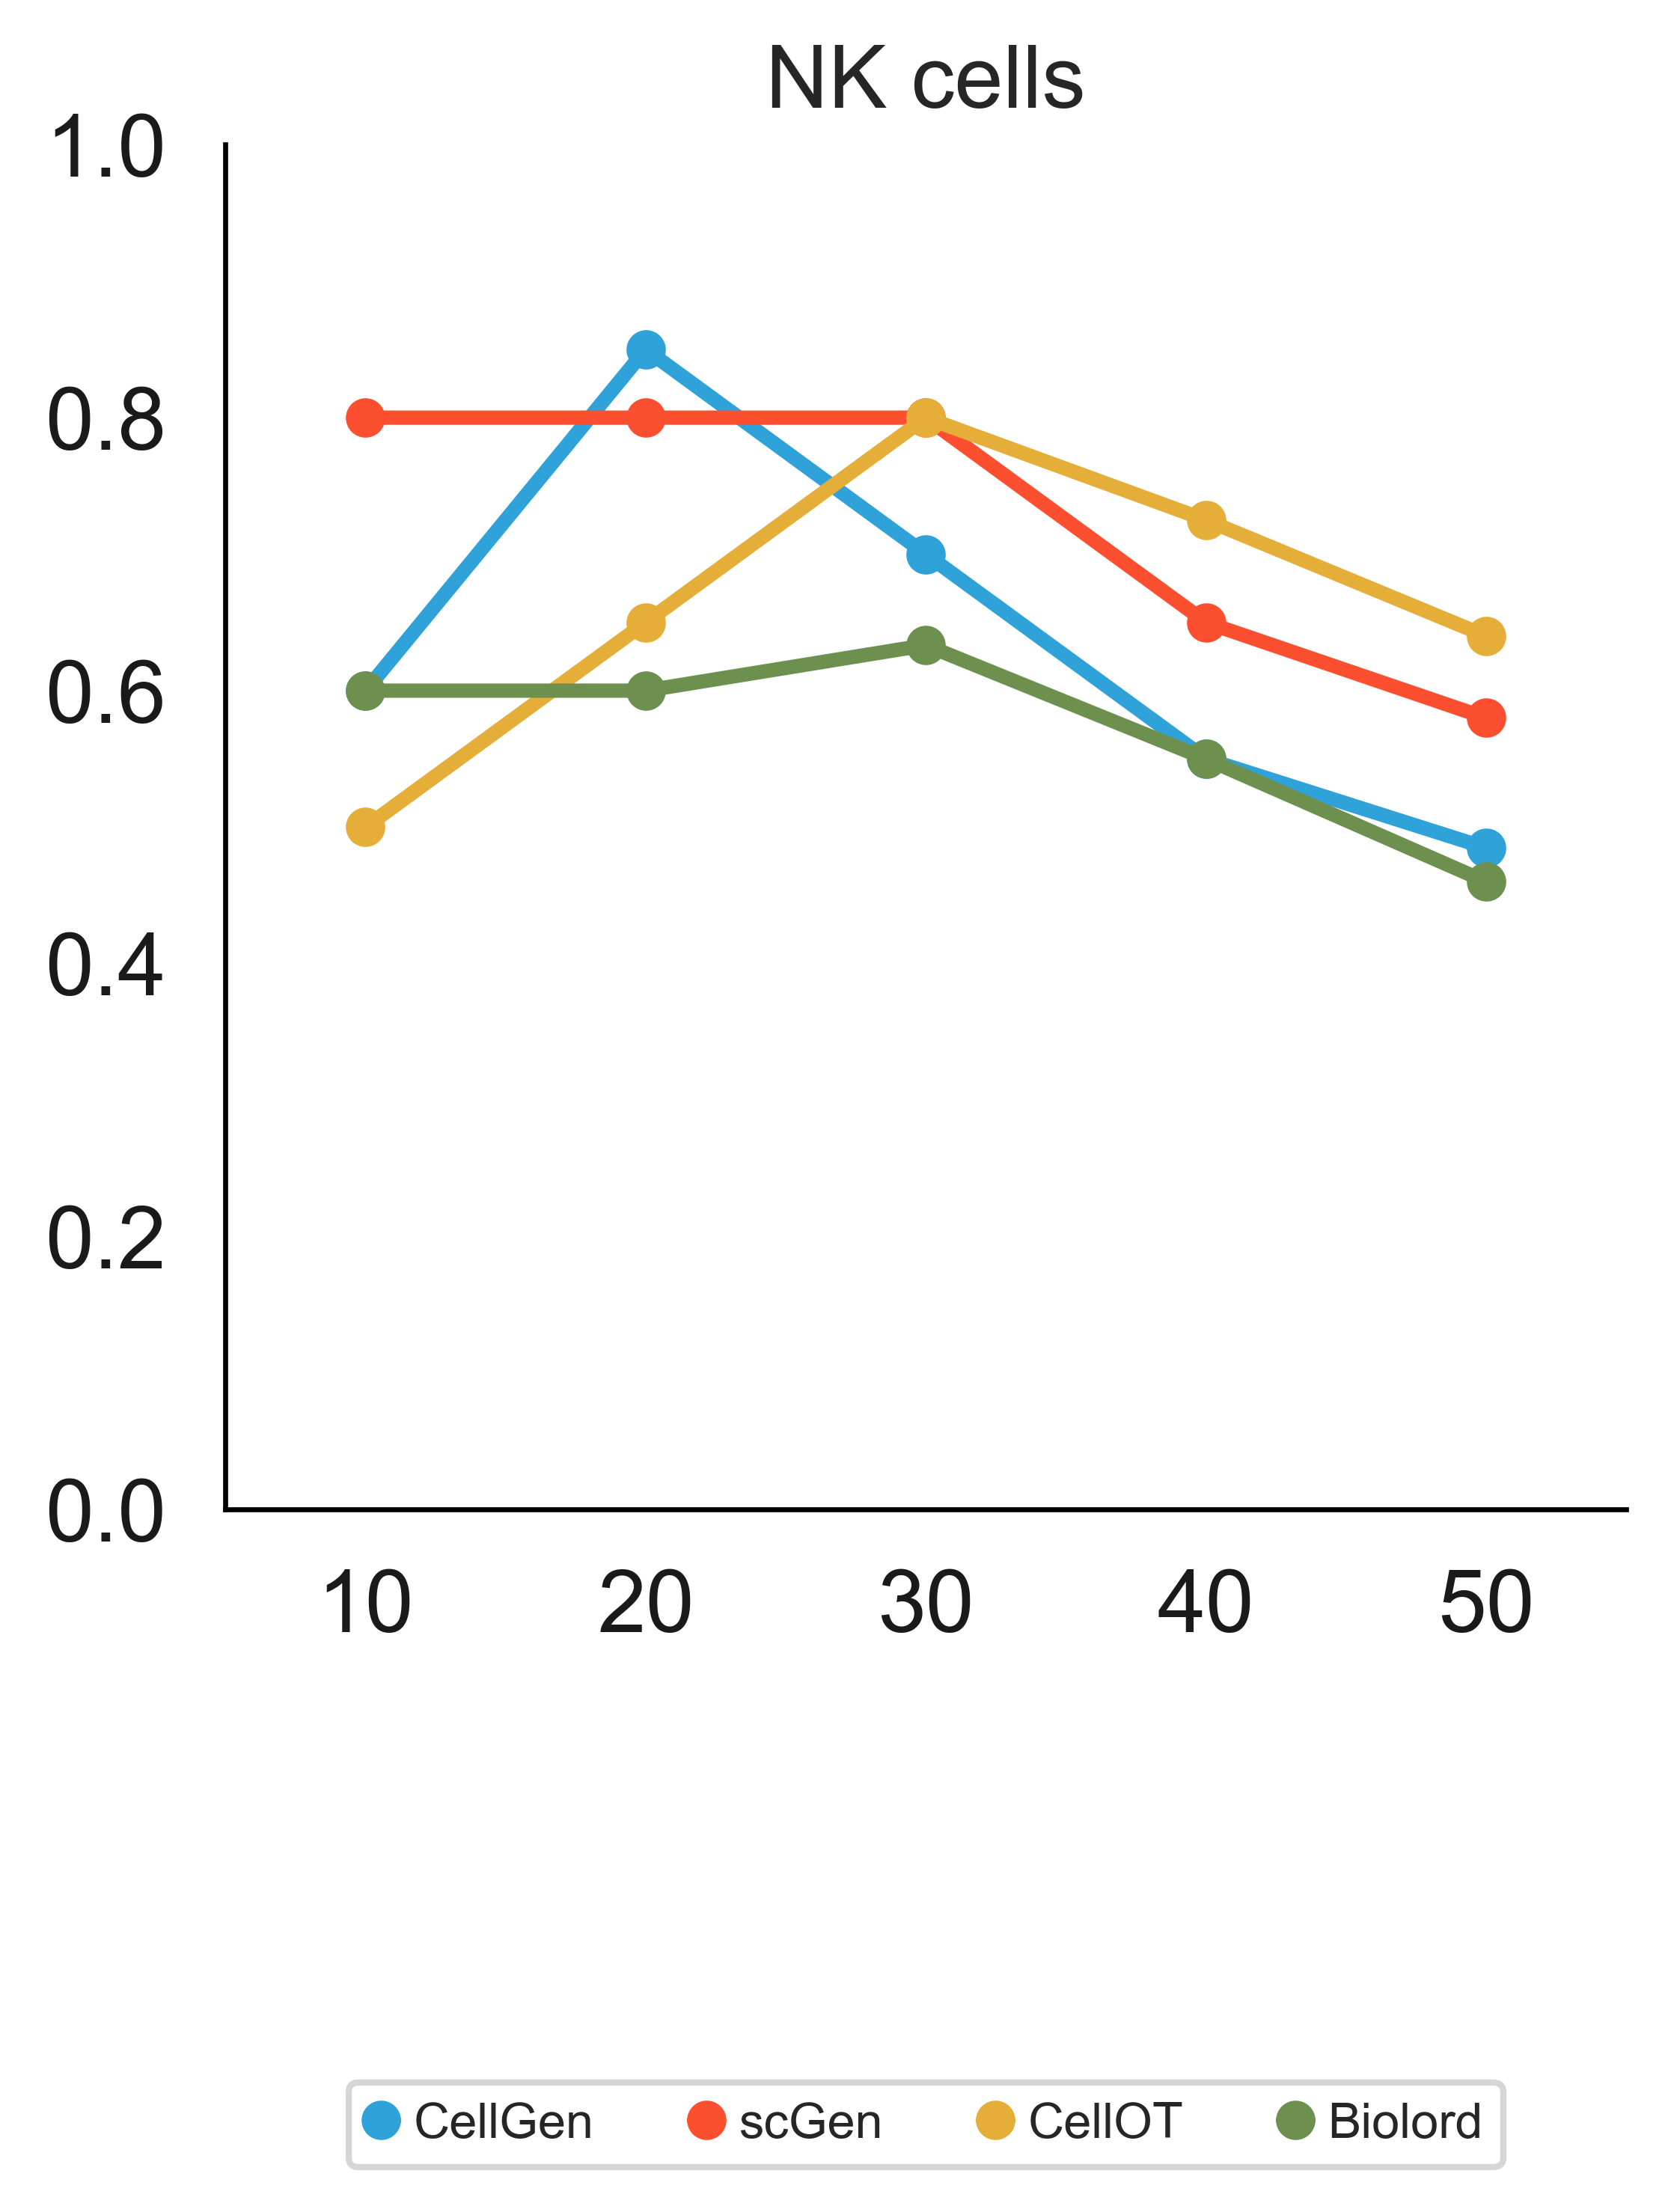

In [267]:
index  = 0

# Create a single row of subplots with one column for each cell type
fig, ax = plt.subplots(1, len(celltype_list), figsize=(4, 4))

# for ax, index in zip(axes, range(len(celltype_list))):
    
print(celltype_list[index])

# comment out when it is only one cell type
# if celltype_list[index] in ["Megakaryocytes", "Dendritic cells"]:
#     continue

# init for storing all the RBO score
if index == 0:
    metric_data["scGen"]["RBO_total"] = []
    metric_data["CellGen"]["RBO_total"] = []
    metric_data["Biolord"]["RBO_total"] = []
    metric_data["CellOT"]["RBO_total"] = []
    metric_data["Measured"]["RBO_total"] = []

metric_data["scGen"]["RBO"] = compute_rbo(adata_test_deg, full_adata, "scGen", celltype = celltype_list[index])
metric_data["CellGen"]["RBO"] = compute_rbo(adata_test_deg, full_adata, "CellGen", celltype = celltype_list[index])
metric_data["Biolord"]["RBO"] = compute_rbo(adata_test_deg, full_adata, "Biolord", celltype = celltype_list[index])
metric_data["CellOT"]["RBO"] = compute_rbo(adata_test_deg, full_adata, "CellOT", celltype = celltype_list[index])
# metric_data["Control"]["RBO"] = compute_rbo(adata_test_deg, full_adata, "Control")
metric_data["Measured"]["RBO"] = compute_rbo(adata_test_deg, full_adata, "Measured", celltype = celltype_list[index])

# append the results
#### Add condition to ignore the low number of celltypes
# if celltype_list[index] not in ["Megakaryocytes", "Dendritic cells"]:
metric_data["scGen"]["RBO_total"].append(metric_data["scGen"]["RBO"])
metric_data["CellGen"]["RBO_total"].append(metric_data["CellGen"]["RBO"])
metric_data["Biolord"]["RBO_total"].append(metric_data["Biolord"]["RBO"])
metric_data["CellOT"]["RBO_total"].append(metric_data["CellOT"]["RBO"])
metric_data["Measured"]["RBO_total"].append(metric_data["Measured"]["RBO"])

metric_data_df = pd.DataFrame(metric_data).transpose()

colors_list = cc.glasbey_hv

data = metric_data_df[["RBO"]]
data = data.loc[["CellGen", "scGen", "CellOT", "Biolord"]]
data = data.explode("RBO")
data.reset_index(inplace = True)
data.columns = ["model", "RBO"]
data["RBO"] = pd.to_numeric(data["RBO"])
data["DEGs"] = pd.to_numeric([10, 20, 30, 40, 50] * 4)
# data

# # create desirable order of the x axis
    
sns.pointplot(x = "DEGs", y = "RBO", data = data, palette = colors_list, hue = "model", scale = 0.85, ax= ax)
ax.set_ylim(0, 1)

ax.grid(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_legend().remove() 
# ax.set_xticks(rotation = 35, ha = "right")
ax.set_title(celltype_list[index])
    
plt.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.5), fontsize = 8, ncol = 4)
sns.despine()
plot_save_svg()

/tmp/ipykernel_52281/318198364.py:19: UserWarning: The palette list has more values (256) than needed (4), which may not be intended.
  sns.pointplot(x = "DEGs", y = "RBO_avg", data = data, palette = colors_list, hue = "model", scale = 0.85)
/tmp/ipykernel_52281/318198364.py:19: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x = "DEGs", y = "RBO_avg", data = data, palette = colors_list, hue = "model", scale = 0.85)


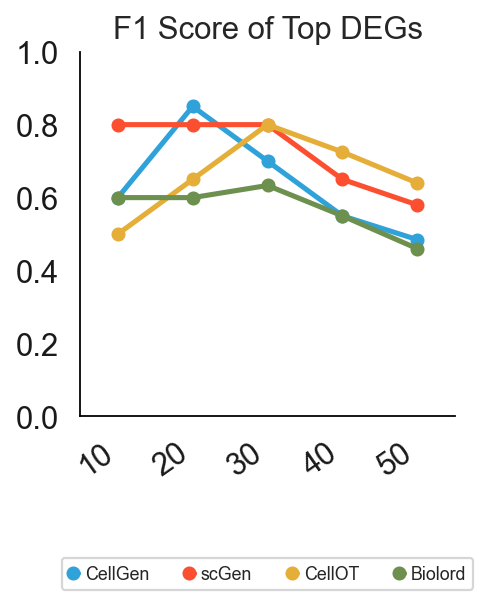

In [333]:
metric_data["scGen"]["RBO_avg"] = list(np.array(metric_data["scGen"]["RBO_total"]).mean(0).round(4))
metric_data["CellGen"]["RBO_avg"] = list(np.array(metric_data["CellGen"]["RBO_total"]).mean(0).round(4))
metric_data["Biolord"]["RBO_avg"] = list(np.array(metric_data["Biolord"]["RBO_total"]).mean(0).round(4))
metric_data["CellOT"]["RBO_avg"] = list(np.array(metric_data["CellOT"]["RBO_total"]).mean(0).round(4))

metric_data_df = pd.DataFrame(metric_data).transpose()

data = metric_data_df[["RBO_avg"]]
data = data.loc[["CellGen", "scGen", "CellOT", "Biolord"]]
data = data.explode("RBO_avg")
data.reset_index(inplace = True)
data.columns = ["model", "RBO_avg"]
data["RBO_avg"] = pd.to_numeric(data["RBO_avg"])
data["DEGs"] = pd.to_numeric([10, 20, 30, 40, 50] * 4)
# data

# # create desirable order of the x axis

sns.pointplot(x = "DEGs", y = "RBO_avg", data = data, palette = colors_list, hue = "model", scale = 0.85)

plt.grid(False)
plt.xlabel('')
plt.ylabel('')
plt.ylim(0, 1)
plt.xticks(rotation = 35, ha = "right")
plt.title("F1 Score of Top DEGs")
plt.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.5), fontsize = 8, ncol = 4)
sns.despine()
plot_save_svg()

In [269]:
metric_data_df

sliced_wasserstein corr mean  iLISI     MMD      r2 MNN_Pairs  \
CellGen            0.097338  0.969923  1.691  0.0038  0.1007       225   
scGen              0.282166  0.963447  1.081  0.1467  0.0916       103   
CellOT              0.24679  0.909456  1.739  0.0734   0.079       195   
Biolord            0.514226  0.753243    1.0  0.3831  0.0596         2   
Control            0.221773  0.814476  1.008  0.0087  0.1184        62   
Measured                0.0       1.0  1.769     0.0     1.0      1047   

                                                   MNN_corr  \
CellGen   [0.0935, 0.1586, 0.157, 0.006, -0.0262, -0.026...   
scGen     [0.5426, 0.4554, 0.3182, 0.235, -0.0637, -0.07...   
CellOT    [0.2694, 0.3972, 0.1762, 0.012, 0.0269, 0.0885...   
Biolord   [1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0...   
Control   [0.5821, 0.5697, 0.1292, -0.0587, 1.0, 0.1064,...   
Measured  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                 RBO_total                             RBO  \
CellGen   [[0.6, 0.85, 0.7, 0.55, 0.4848]]  [0.6, 0.85, 0.7, 0.55, 0.4848]   
scGen        [[0.8, 0.8, 0.8, 0.65, 0.58]]     [0.8, 0.8, 0.8, 0.65, 0.58]   
CellOT     [[0.5, 0.65, 0.8, 0.725, 0.64]]   [0.5, 0.65, 0.8, 0.725, 0.64]   
Biolord   [[0.6, 0.6, 0.6333, 0.55, 0.46]]  [0.6, 0.6, 0.6333, 0.55, 0.46]   
Control                                NaN                             NaN   
Measured       [[1.0, 1.0, 1.0, 1.0, 1.0]]       [1.0, 1.0, 1.0, 1.0, 1.0]   

                                 RBO_avg  
CellGen   [0.6, 0.85, 0.7, 0.55, 0.4848]  
scGen        [0.8, 0.8, 0.8, 0.65, 0.58]  
CellOT     [0.5, 0.65, 0.8, 0.725, 0.64]  
Biolord   [0.6, 0.6, 0.6333, 0.55, 0.46]  
Control                              NaN  
Measured                             NaN

In [270]:
# define model to compute for the ilisi score

def compute_ilisi(model_name, full_adata):

    # subset to the model of interest
    sub_model = [targeted_label, model_name]
    
    metric_adata = full_adata[full_adata.obs["condition"].isin(sub_model)].copy()
    
    X_array_test = metric_adata.X @ pca_matrix.T
    metadata = metric_adata.obs
    
    # computing the ilisi score
    batch_str = "condition"
    ilisi = compute_lisi(X_array_test, metadata, [batch_str], perplexity = 20)
    
    # for scaling purpose
    # ilisi = (ilisi - 1) / (n_batch - 1)
    
    temp_df = pd.DataFrame({"score": ilisi.transpose().reshape(-1),
                  "meta": metadata[batch_str].values})

    print()
    
    # gp_temp_df_raw = temp_df.groupby("meta")
    
    # # Calculate the median and IQR for each group
    # summary_stats = gp_temp_df_raw['score'].agg(
    #     median = np.nanmedian,
    #     q1 = lambda x: np.percentile(x, 25),
    #     q3 = lambda x: np.percentile(x, 75)
    # )
    
    # # Calculate the IQR
    # summary_stats['iqr'] = summary_stats['q3'] - summary_stats['q1']
    
    # # Display the summary statistics
    # summary_stats[["median", "iqr"]].round(5)

    # print(summary_stats)
    
    # return the average of the median lisi score for each condition
    return temp_df[temp_df["meta"] == model_name].round(3)["score"].values

compute_ilisi("CellGen", full_adata)

array([1.956, 1.691, 1.633, 1.614, 1.774, 1.97 , 1.455, 1.926, 1.665,
       1.949, 1.533, 1.298, 1.04 , 1.809, 1.623, 1.396, 1.853, 1.286,
       1.317, 1.423, 1.616, 1.371, 1.663, 1.285, 1.596, 1.189, 1.61 ,
       1.436, 1.855, 1.198, 1.4  , 1.982, 1.508, 1.173, 1.157, 1.497,
       1.251, 1.988, 1.321, 1.355, 1.362, 1.336, 1.308, 1.63 , 2.   ,
       1.974, 1.993, 1.507, 1.161, 1.152, 1.785, 1.902, 1.278, 1.806,
       1.363, 1.447, 1.995, 1.991, 1.435, 1.124, 1.929, 1.634, 1.738,
       1.429, 1.447, 1.762, 1.323, 1.599, 1.829, 1.078, 1.285, 1.186,
       1.989, 1.99 , 1.163, 1.073, 1.243, 1.846, 1.783, 1.958, 1.884,
       1.981, 1.282, 1.996, 2.   , 1.985, 1.551, 1.157, 1.567, 1.654,
       1.998, 1.494, 1.108, 1.326, 1.897, 1.144, 1.425, 1.999, 1.412,
       1.995, 1.273, 1.991, 1.406, 1.427, 1.667, 1.996, 1.261, 1.528,
       1.794, 1.278, 1.739, 1.13 , 1.435, 1.352, 1.583, 1.55 , 1.995,
       1.958, 1.1  , 1.166, 1.791, 1.391, 1.335, 1.644, 1.64 , 1.884,
       1.172, 1.96 ,

In [271]:
metric_data.keys()

dict_keys(['CellGen', 'scGen', 'CellOT', 'Biolord', 'Control', 'Measured'])

In [272]:
metric_data["scGen"]["iLISI"] = compute_ilisi("scGen", full_adata)
metric_data["CellGen"]["iLISI"] = compute_ilisi("CellGen", full_adata)
metric_data["Biolord"]["iLISI"] = compute_ilisi("Biolord", full_adata)
metric_data["CellOT"]["iLISI"] = compute_ilisi("CellOT", full_adata)
metric_data["Control"]["iLISI"] = compute_ilisi("Control", full_adata)
metric_data["Measured"]["iLISI"] = compute_ilisi("Measured", full_adata)

In [273]:
# metric_data

/tmp/ipykernel_52281/4147808923.py:15: UserWarning: The palette list has more values (256) than needed (6), which may not be intended.
  sns.boxplot(x = "model", y = "iLISI", data = data, palette = colors_list, orient = "v")


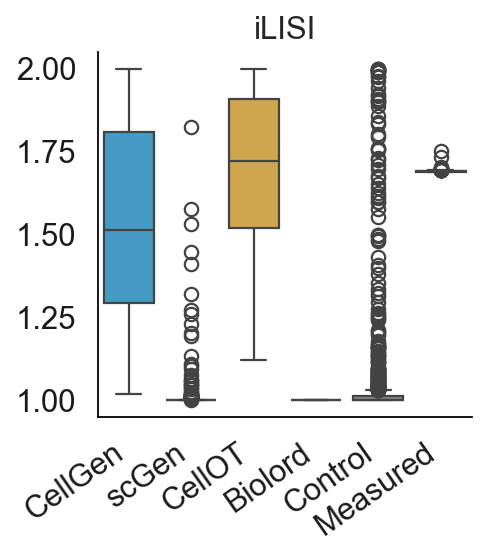

In [331]:
metric_data_df = pd.DataFrame(metric_data).transpose()

colors_list = cc.glasbey_hv

data = metric_data_df[["iLISI"]]
data = data.loc[["CellGen", "scGen", "CellOT", "Biolord", "Control", "Measured"]]
data = data.explode("iLISI")
data.reset_index(inplace = True)
data.columns = ["model", "iLISI"]
data["iLISI"] = pd.to_numeric(data["iLISI"])
# data

# # create desirable order of the x axis

sns.boxplot(x = "model", y = "iLISI", data = data, palette = colors_list, orient = "v")

plt.grid(False)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation = 35, ha = "right")
plt.title("iLISI")
sns.despine()
plot_save_svg()

## DEGs for each cell types

In [275]:
from utils import venn4py

NK cells
Unique elements in Measured: {'CCL8', 'IFIH1', 'RABGAP1L', 'TYMP', 'LAP3', 'S100A6', 'SEC61B', 'LGALS9', 'HERPUD1', 'CARD16', 'CMPK2', 'HSPA5', 'GBP4', 'HLA-DPB1'}
Unique elements in scGen: {'RGS2', 'KLRB1', 'GSTO1', 'ATP1B3', 'DUSP1', 'ATP6V1F', 'MRPL18', 'CACYBP', 'RGS1', 'CTSC', 'CPNE3', 'HSPE1', 'CEBPD', 'SSB', 'RHOC', 'IL32', 'ZEB2', 'GPR97', 'PLAC8', 'NFKBIA', 'GTF3C1', 'PKM', 'SERPINB1', 'LGALS3', 'DDIT4', 'JUNB', 'TCP1', 'CEBPB', 'TALDO1', 'CTSW', 'GATA3', 'GPX1', 'SLC16A3', 'KLRC1', 'CTSD', 'CCL5', 'TSC22D3', 'CCL4', 'CSTB', 'PSAP', 'FEZ1', 'CKLF', 'ANXA5', 'BID', 'HSPD1', 'AP1S2', 'WTAP', 'HIST1H2AC', 'TIGIT', 'CLIC1', 'C1orf162', 'CD8A', 'DOK2', 'CLK1', 'ITGB2', 'GLRX', 'GZMH', 'SDCBP', 'PLEK', 'SRSF2', 'CCDC28A', 'TUBA1B', 'KLF6', 'IDI1', 'XCL2', 'VAMP5', 'TXN', 'C12orf75', 'RSRC2', 'ACTG1', 'DYNLL1', 'CCR7', 'PLA2G16', 'AKR1C3', 'ATP6V0B', 'IGFBP7', 'RALA', 'CCL3', 'ADA', 'GADD45B'}


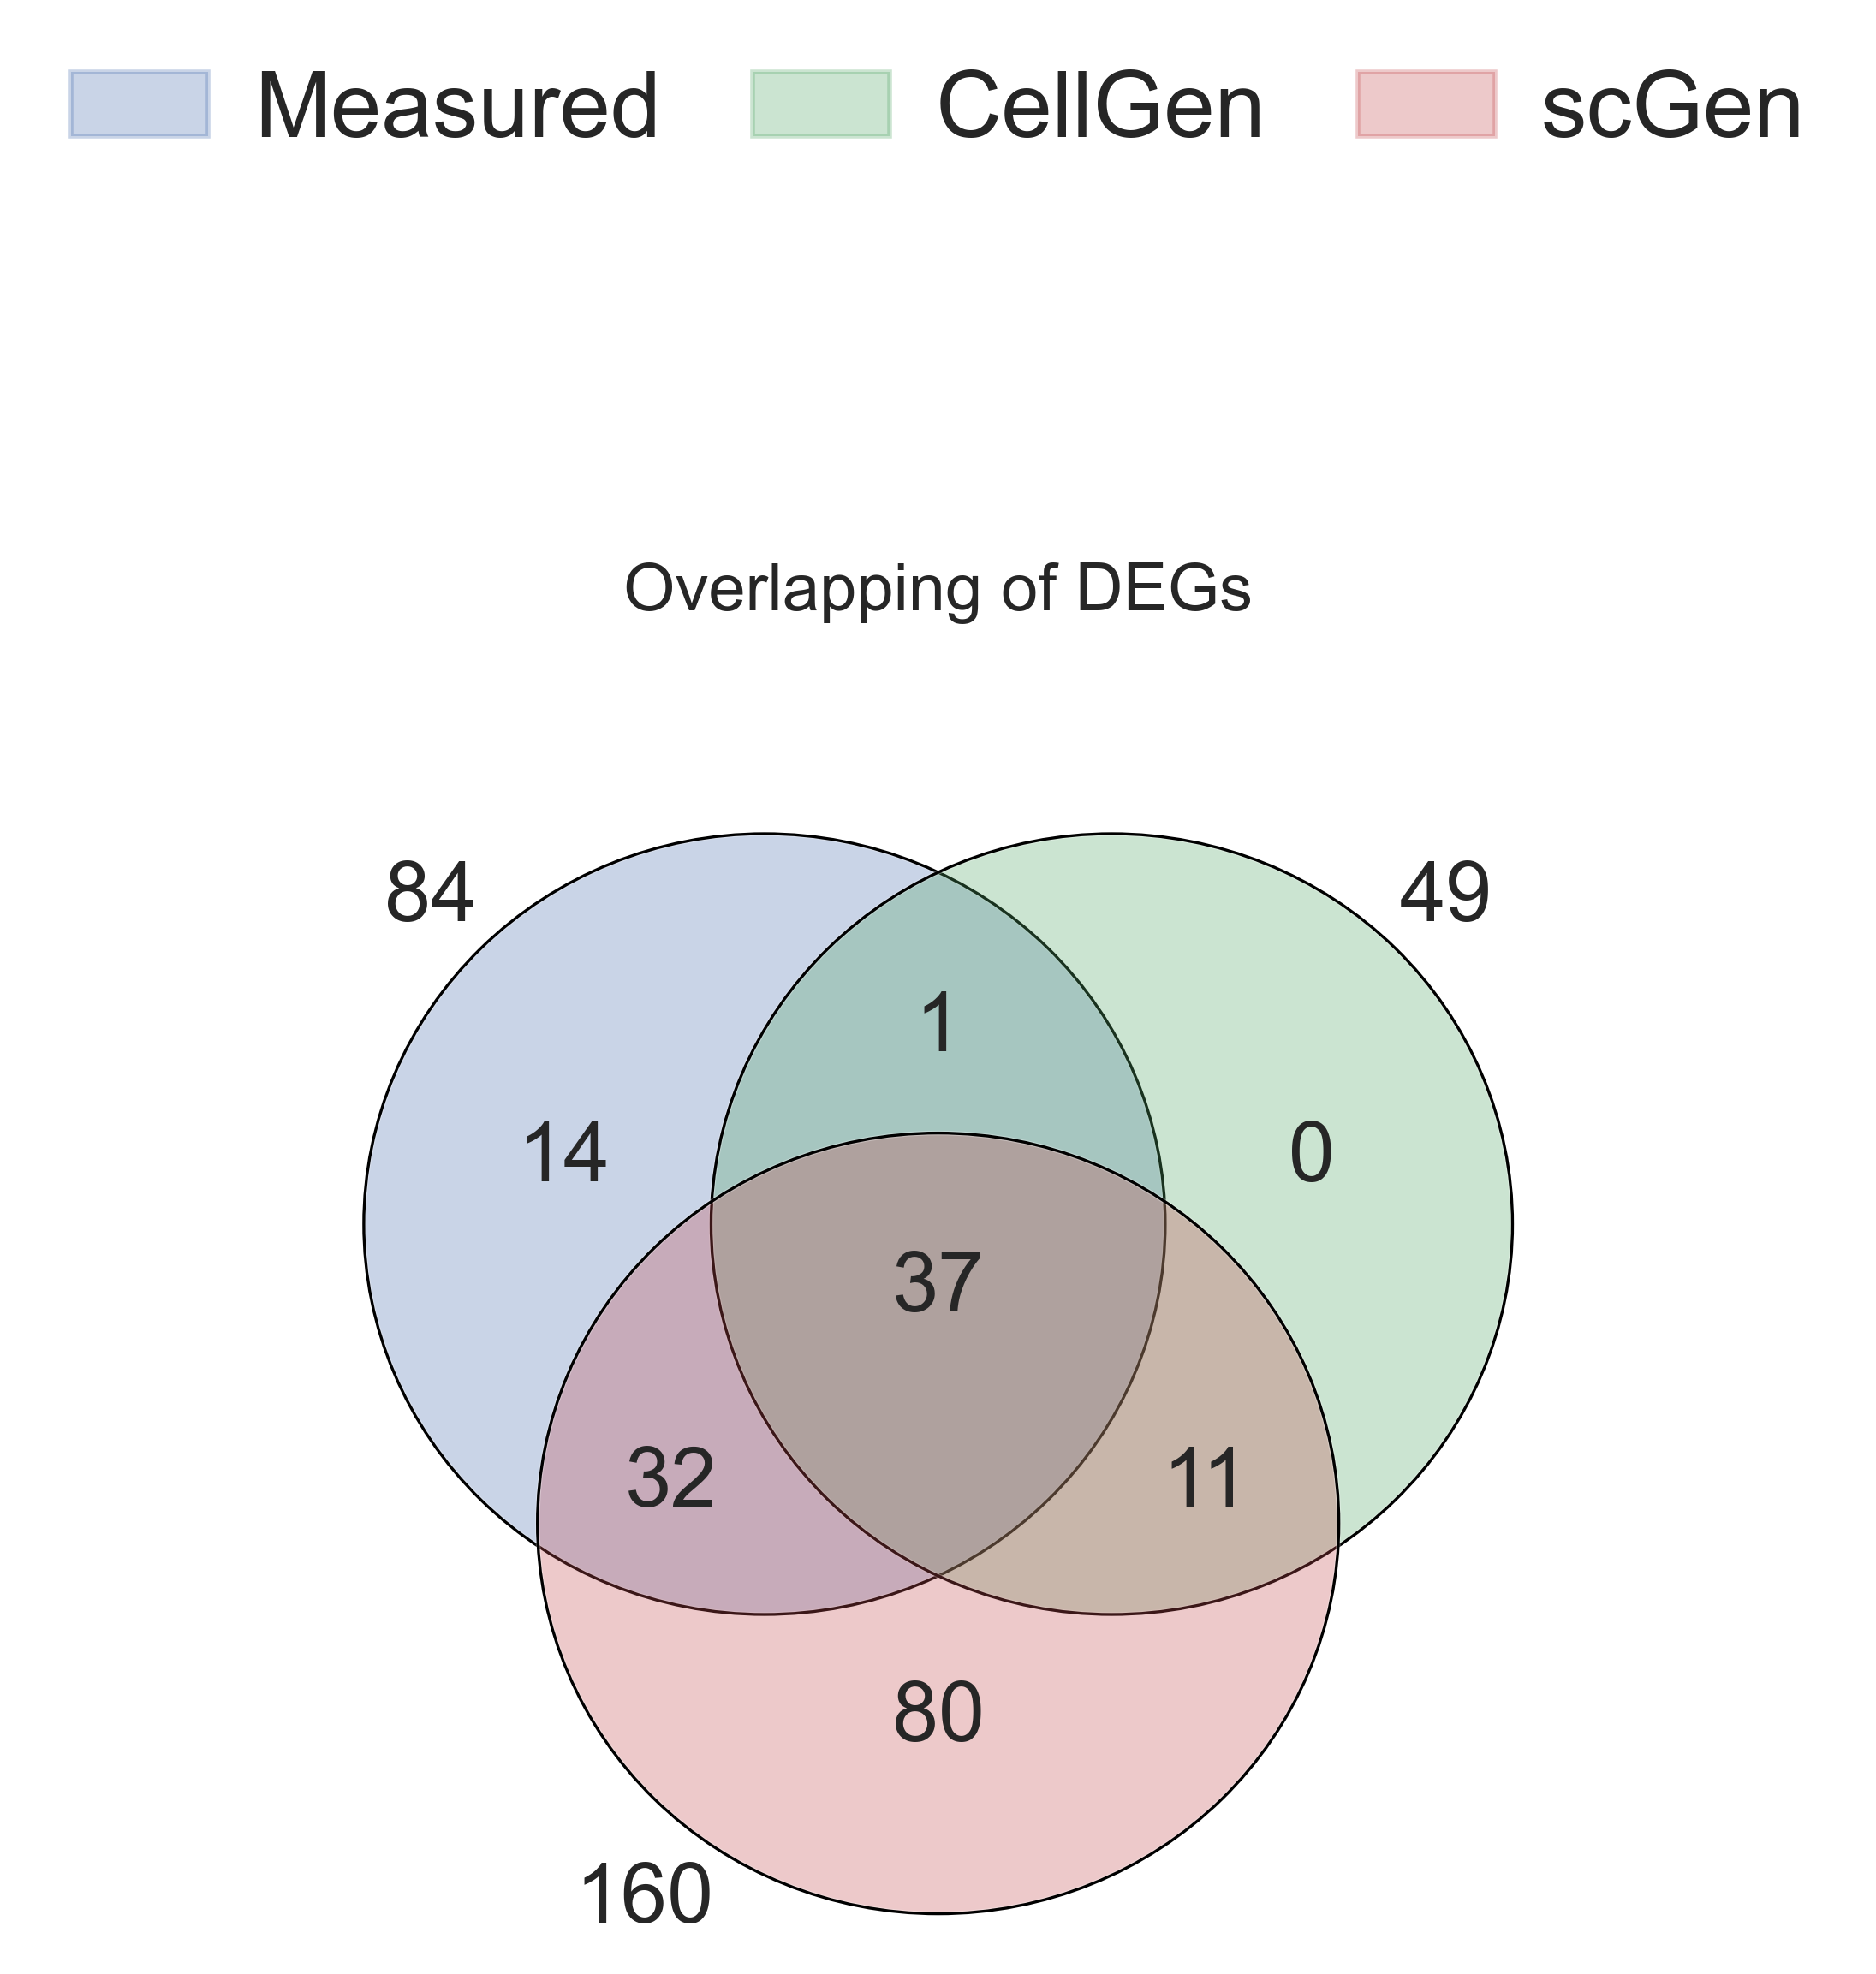

In [335]:
from matplotlib_venn import venn3, venn3_circles
from collections import defaultdict

def venn_diagrams(adata_test_deg, full_adata, model_name, celltype):
    
    adata_test_deg = adata_test_deg[adata_test_deg.obs["cell_type"] == celltype].copy()

    # print(adata_test_deg.obs.cell_type)
    # print(adata_test_deg[adata_test_deg.obs.condition.isin(["Control"])].X.shape)
    # get the ground truth DEGs
    top_num = 1000
    observed_deg = get_deg(adata_test_deg, top = top_num)

    # print(observed_deg)

    # variable to store all the degs gene set
    deg_dict = {}

    deg_dict["Measured"] = set(observed_deg)
    
    for model in model_name:
        # get the DEGs from the predicted gene expressions
        adata_pred_deg = full_adata[full_adata.obs.condition.isin(["Control", model])].copy()
    
        # subset to the given cell type for the DEGs
        adata_pred_deg = adata_pred_deg[adata_pred_deg.obs["cell_type"] == celltype].copy()
        adata_pred_deg.obs.condition.replace(model, "Perturbed", inplace = True)
        adata_pred_deg.obs["condition"] = adata_pred_deg.obs["condition"].astype('category')
        pred_deg = get_deg(adata_pred_deg, "X_pred", top = top_num)

        deg_dict[model] = set(pred_deg)

    sets = [set(deg_dict[key]) for key in deg_dict]

    # Create a dictionary to store element counts across sets
    element_counts = defaultdict(int)
    for elements in deg_dict.values():
        for element in elements:
            element_counts[element] += 1
    
    # Find elements unique to each set
    unique_elements = {key for key, value in element_counts.items() if value == 1}

    CellGen_uniq_set = {}
    
    # Print unique elements for each set
    for set_name, elements in deg_dict.items():
        unique_in_set = {element for element in unique_elements if element in elements} 
        if unique_in_set:
            print(f"Unique elements in {set_name}: {unique_in_set}")
            if set_name == "CellGen":
                CellGen_uniq_set = unique_in_set

    # print(deg_dict)

    
    venn4py.venny4py(deg_dict, ext = "svg", size = 5.0)
    
    plt.title("Overlapping of DEGs")
    plot_save_svg()

    return list(CellGen_uniq_set)
celltype_index = 0
print(celltype_list[celltype_index])

CellGen_gene = venn_diagrams(adata_test_deg, full_adata, model_name = ["CellGen", "scGen"], celltype = celltype_list[celltype_index])
# CellGen_gene

In [277]:
def get_fc(adata_test_deg, layer_name = "X_raw"):

    '''
    layer_name must be either X_raw or X_pred
    '''
    adata_test_deg.layers[layer_name] = adata_test_deg.X.copy()
    
    # uncomment for raw data degs
    adata_test_deg.obsm[f'{layer_name}_pca'] = adata_test_deg.layers[layer_name] @ pca_matrix.T
    sc.tl.dendrogram(adata_test_deg, use_rep = f'{layer_name}_pca', groupby = group_name, optimal_ordering=False)
    
    group_index = 1
    adata_test_deg.X = adata_test_deg.layers[layer_name]
    adata_test_deg.X[adata_test_deg.X < 1] = 0
    adata_test_deg.layers[layer_name] = adata_test_deg.X.copy()
    sc.tl.rank_genes_groups(adata_test_deg, group_name, method='wilcoxon', use_raw = False, corr_method='benjamini-hochberg', layer = layer_name, pts = True)

    deg_fc = compute_logfc(adata_test_deg, groups[group_index], group_name, layer_name)

    
    deg_df = sc.get.rank_genes_groups_df(adata_test_deg, group = groups[group_index], key='rank_genes_groups')
    deg_df.set_index("names", inplace = True)
    # deg_df = deg_df.loc[genes]
    deg_df["logfoldchanges"] = deg_fc

    # filter only the significant gene
    # deg_df = deg_df[(deg_df["pvals_adj"] < 0.05)]

    # sort based on the logfoldchange
    # filtered_deg = deg_df.sort_values("logfoldchanges", ascending = False)
    
    foldchange_values = list(deg_df["logfoldchanges"].values)

    # we want to get all the logfoldchange for all the gene
    return foldchange_values

NK cells


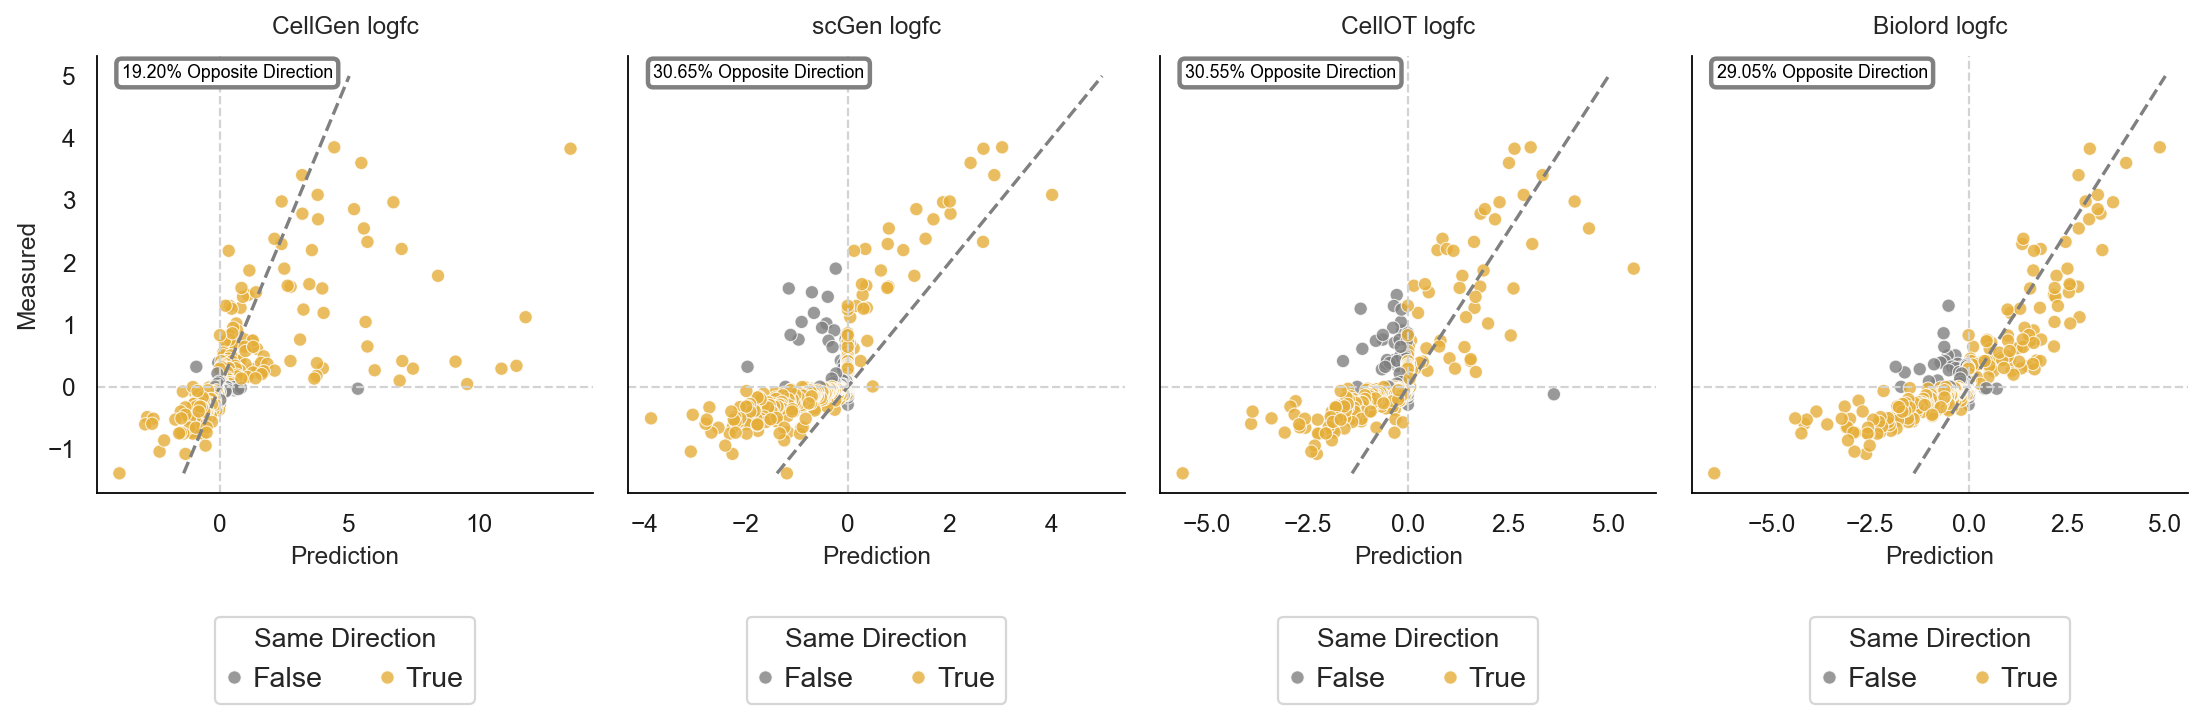

In [336]:
def logfc_plot(adata_test_deg, full_adata, model_name, celltype):
    adata_test_deg_sub = adata_test_deg[adata_test_deg.obs["cell_type"] == celltype].copy()
    observed_fc = get_fc(adata_test_deg_sub)
    
    # Create a single figure with one row and as many columns as there are models
    fig, axes = plt.subplots(1, len(model_name), figsize=(3.5 * len(model_name), 5), sharey=True)

    for idx, model in enumerate(model_name):
        adata_pred = full_adata[(full_adata.obs["condition"].isin(["Control", model]))].copy()
        adata_pred = adata_pred[adata_pred.obs["cell_type"] == celltype].copy()
        
        adata_pred.obs.condition.replace(model, "Perturbed", inplace=True)
        adata_pred.obs["condition"] = adata_pred.obs["condition"].astype('category')

        pred_fc = get_fc(adata_pred)

        # Create a mask for top right and bottom left quadrants
        mask_top_right = np.logical_and(np.array(observed_fc) >= 0, np.array(pred_fc) >= 0)
        mask_bottom_left = np.logical_and(np.array(observed_fc) < 0, np.array(pred_fc) < 0)

        combine_mask = np.logical_or(mask_top_right, mask_bottom_left)

        data = {"Measured": observed_fc, "prediction": pred_fc, "direction": combine_mask}
        
        ax = axes[idx]
        sns.scatterplot(x="prediction", y="Measured", hue="direction", palette={False: 'grey', True: colors_list[2]}, data=data, alpha=0.8, color=colors_list[2], ax=ax)
        ax.plot([min(observed_fc), 5], [min(observed_fc), 5], color="grey", linestyle='--')
        ax.grid(False)
        sns.despine(ax=ax)
        ax.set_title(model + " logfc", pad=10, fontsize=11)
        ax.axhline(0, color='lightgrey', linestyle='--', linewidth=1)
        ax.axvline(0, color='lightgrey', linestyle='--', linewidth=1)
        ax.legend(title="Same Direction", loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=2, fancybox=True)

        percentage_false = 100 - ((sum(combine_mask) / len(combine_mask)) * 100)
        ax.annotate(f'{percentage_false:.2f}% Opposite Direction', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=8, color='black', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=2))
        ax.set_xlabel("Prediction", fontsize=11)
        if idx == 0:
            ax.set_ylabel("Measured", fontsize=11)
        ax.tick_params(axis='both', which='major', labelsize=11)

    plt.tight_layout()
    
celltype_index = 0
print(celltype_list[celltype_index])
logfc_plot(adata_test_deg, full_adata, ["CellGen", "scGen", "CellOT", "Biolord"], celltype_list[celltype_index])
plot_save_svg()

In [280]:
def get_deg_metric(adata_test_deg, layer_name = "X_raw", genes = []):

    '''
    layer_name must be either X_raw or X_pred
    '''
    adata_test_deg.layers[layer_name] = adata_test_deg.X.copy()
    
    # uncomment for raw data degs
    adata_test_deg.obsm[f'{layer_name}_pca'] = adata_test_deg.layers[layer_name] @ pca_matrix.T
    sc.tl.dendrogram(adata_test_deg, use_rep = f'{layer_name}_pca', groupby = group_name, optimal_ordering=False)
    
    group_index = 1
    adata_test_deg.X = adata_test_deg.layers[layer_name]
    adata_test_deg.X[adata_test_deg.X < 1] = 0
    adata_test_deg.layers[layer_name] = adata_test_deg.X.copy()
    sc.tl.rank_genes_groups(adata_test_deg, group_name, method='wilcoxon', use_raw = False, corr_method='benjamini-hochberg', layer = layer_name, pts = True)
    # raw_deg = sc.get.rank_genes_groups_df(adata_test_deg, group = groups[group_index], pval_cutoff=1.0, key='rank_genes_groups')["names"]

    deg_fc = compute_logfc(adata_test_deg, groups[group_index], group_name, layer_name).loc[genes]

    deg_df = sc.get.rank_genes_groups_df(adata_test_deg, group = groups[group_index], key='rank_genes_groups')
    deg_df.set_index("names", inplace = True)
    deg_df = deg_df.loc[genes]
    deg_df["logfoldchanges"] = deg_fc

    # filtered_deg = deg_fc.sort_values("logfc", ascending = False)
    # print(deg_df)

    return deg_df

In [281]:
def get_deg_metric_data(adata_test_deg, full_adata, model_name, model_genes = [], celltype = None):

    # init the matrix to turn the data
    p_values_matrix = []
    logfc_matrix = []
    pct_nz_group_matrix = []
    method_list = ["Measured"] + model_name

    adata_test_deg = adata_test_deg[adata_test_deg.obs["cell_type"] == celltype].copy()
    print(adata_test_deg)
    
    for gene in model_genes:
    
        # obtain the deg for the observed data
        observed_deg = get_deg_metric(adata_test_deg, genes = list(model_genes))

        # init list of data holder & append the data
        p_values_list = []
        logfc_list = []
        pct_nz_group_list = []
    
        logfc_list.append(observed_deg["logfoldchanges"][gene])
        # p_values_list.append(1 - observed_deg["pvals_adj"][gene])
        if observed_deg["pvals_adj"][gene] < 0.05:
            p_values_list.append("Significant")
        else:
            p_values_list.append("Not Significant")
        pct_nz_group_list.append(observed_deg["pct_nz_group"][gene])
    
        # iterate through each model passed
        for model in model_name:
            # get the DEGs from the predicted gene expressions
            adata_pred_deg = full_adata[full_adata.obs.condition.isin(["Control", model])].copy()
            
            # subset to the given cell type for the DEGs
            adata_pred_deg = adata_pred_deg[adata_pred_deg.obs["cell_type"] == celltype].copy()
            adata_pred_deg.obs.condition.replace(model, "Perturbed", inplace = True)
            adata_pred_deg.obs["condition"] = adata_pred_deg.obs["condition"].astype('category')
            
            pred_deg = get_deg_metric(adata_pred_deg, "X_pred", genes = list(model_genes))
    
            logfc_list.append(pred_deg["logfoldchanges"][gene])
            # p_values_list.append(1 - pred_deg["pvals_adj"][gene])
            if pred_deg["pvals_adj"][gene] < 0.05:
                p_values_list.append("Significant")
            else:
                p_values_list.append("Not Significant")
                
            pct_nz_group_list.append(pred_deg["pct_nz_group"][gene])

        p_values_matrix.append(p_values_list)
        logfc_matrix.append(logfc_list)
        pct_nz_group_matrix.append(pct_nz_group_list)

    return np.array(p_values_matrix), np.array(logfc_matrix), method_list, pct_nz_group_matrix

p_values_matrix, logfc_matrix, model_list, pct_nz_group_matrix = get_deg_metric_data(adata_test_deg, full_adata, model_name = ["CellGen", "scGen", "CellOT", "Biolord"], model_genes = CellGen_gene, celltype = celltype_list[celltype_index])

AnnData object with n_obs × n_vars = 1981 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'ensg', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca'


In [282]:
p_values_matrix

array([], dtype=float64)

In [283]:
logfc_matrix

array([], dtype=float64)

In [285]:
# convert matrix into long data type
plot_data = pd.DataFrame(columns = ["methods", "genes", "logfc", "pval_adj", "Fraction of cells in group val"])

for i in range(len(CellGen_gene)):
    for j in range(len(model_list)):
        # Data to append
        data_to_append = pd.DataFrame({'methods': [model_list[j]], 'genes': [CellGen_gene[i]], 'logfc':[logfc_matrix[i][j]], 'pval_adj':[p_values_matrix[i][j]],
                                      'Fraction of cells in group val': pct_nz_group_matrix[i][j]})
        
        # Append data to the DataFrame
        plot_data = pd.concat([plot_data, data_to_append], ignore_index=True)

print(plot_data)

Empty DataFrame
Columns: [methods, genes, logfc, pval_adj, Fraction of cells in group val]
Index: []


In [286]:
plot_data["Fraction of cells in group"] = pd.cut(plot_data['Fraction of cells in group val'], bins=[-1.0, 0.5, 0.7, 0.8, 0.9, 1.0], labels=['0.0', '0.5', '0.75', '0.9', '1.0'])
# plot_data["logfc"] = pd.cut(plot_data['logfc'], bins=4)
plot_data

Empty DataFrame
Columns: [methods, genes, logfc, pval_adj, Fraction of cells in group val, Fraction of cells in group]
Index: []

In [287]:
for gene in CellGen_gene:
    # subset to gene
    expr_data = plot_data[plot_data["genes"] == gene].copy()

    control_data = {"methods": "Control", "genes": gene, "logfc": 0.0, "pval_adj":"Not Significant", "Fraction of cells in group val" : 1.0, "Fraction of cells in group": 1.0}
    expr_data = pd.concat([expr_data, pd.DataFrame([control_data])], ignore_index=True)
    # print(expr_data)
    significant_list = list(expr_data["pval_adj"].values)
    significant_list.insert(1, "Not Significant")

    # obtain gene expression for all the model
    adata_gene = full_adata[:, gene].copy()

    # define list of item
    expr_list = []
    expr_list.append(list(adata_gene[adata_gene.obs.condition == "Measured"].X.copy().round(4).reshape(-1)))
    expr_list.append(list(adata_gene[adata_gene.obs.condition == "CellGen"].X.copy().round(4).reshape(-1)))
    expr_list.append(list(adata_gene[adata_gene.obs.condition == "scGen"].X.copy().round(4).reshape(-1)))
    expr_list.append(list(adata_gene[adata_gene.obs.condition == "CellOT"].X.copy().round(4).reshape(-1)))
    expr_list.append(list(adata_gene[adata_gene.obs.condition == "Biolord"].X.copy().round(4).reshape(-1)))
    expr_list.append(list(adata_gene[adata_gene.obs.condition == "Control"].X.copy().round(4).reshape(-1)))

    expr_data["expr_values"] = expr_list

    expr_data = expr_data.explode("expr_values")
    expr_data["expr_values"] = pd.to_numeric(expr_data["expr_values"])

    # Create violin plot
    plt.figure(figsize=(6, 4))
    sns.violinplot(x='methods', order = ["Measured", "Control", "CellGen", "scGen", "CellOT", "Biolord"], y='expr_values', fill = False, data=expr_data, width = 0.8, linewidth=1,
                  inner="point", density_norm="count", palette = colors_list)
    
    offset = 1.25
    
    for i in range(len(significant_list)):
        if significant_list[i] == "Significant":
            plt.text(i, max(expr_data["expr_values"]) * offset, '*', ha='center', va='top', fontsize=20)

    
    plt.xticks(rotation = 35, ha = "right")
    plt.title(gene, pad = 20)
    plt.grid(False)
    sns.despine()
    # Show plot
    plt.show()

    barplot_data = plot_data[plot_data["genes"] == gene].copy()

    sns.barplot(x='methods', y='logfc', data=barplot_data,
                palette=['orange' if val < 0 else 'purple' for val in barplot_data["logfc"]])
    plt.xlabel('Labels')
    plt.ylabel('Values')
    plt.grid(False)
    plt.xticks(rotation = 35, ha = "right")
    # Add legend for the bar colors
    plt.legend(handles=[plt.Rectangle((0,0),1,1, color='orange', label='Negative LogFC'),
                        plt.Rectangle((0,0),1,1, color='purple', label='Positive LogFC')],
               loc='upper right', bbox_to_anchor = (1,-0.4), ncol = 2)
    plt.title('Log fold change')
    plt.show()


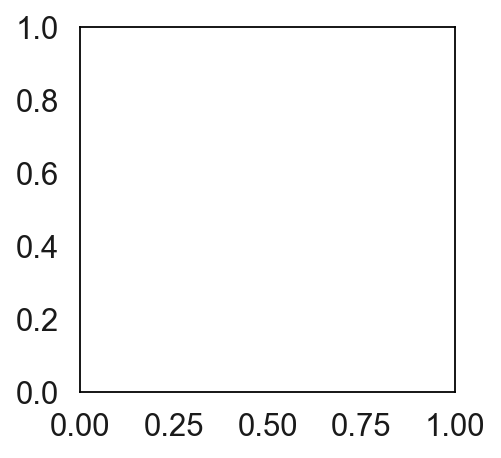

In [288]:
# Example color list for the violin plot
colors_list = sns.color_palette("muted")

# Number of columns for the subplot grid
n_cols = 6

# Initialize figure count
fig_count = 0

for idx, gene in enumerate(CellGen_gene):
    # Initialize a new figure for each set of plots
    if idx % n_cols == 0:
        fig, axes = plt.subplots(1, n_cols, figsize=(24, 4))
        fig_count = 0
        # Increase the space between subplots
        plt.subplots_adjust(wspace=0.5)  # Adjust the value of wspace to increase/decrease space

    # Subset to gene
    expr_data = plot_data[plot_data["genes"] == gene].copy()
    
    control_data = {"methods": "Control", "genes": gene, "logfc": 0.0, "pval_adj": "Not Significant", 
                    "Fraction of cells in group val": 1.0, "Fraction of cells in group": 1.0}
    expr_data = pd.concat([expr_data, pd.DataFrame([control_data])], ignore_index=True)
    
    significant_list = list(expr_data["pval_adj"].values)
    significant_list.insert(1, "Not Significant")

    # Obtain gene expression for all the models
    adata_gene = full_adata[:, gene].copy()
    
    # Define list of expression values
    expr_list = [
        list(adata_gene[adata_gene.obs.condition == "Measured"].X.copy().round(4).reshape(-1)),
        list(adata_gene[adata_gene.obs.condition == "CellGen"].X.copy().round(4).reshape(-1)),
        list(adata_gene[adata_gene.obs.condition == "scGen"].X.copy().round(4).reshape(-1)),
        list(adata_gene[adata_gene.obs.condition == "CellOT"].X.copy().round(4).reshape(-1)),
        list(adata_gene[adata_gene.obs.condition == "Biolord"].X.copy().round(4).reshape(-1)),
        list(adata_gene[adata_gene.obs.condition == "Control"].X.copy().round(4).reshape(-1))
    ]

    expr_data["expr_values"] = expr_list
    expr_data = expr_data.explode("expr_values")
    expr_data["expr_values"] = pd.to_numeric(expr_data["expr_values"])

    # Create violin plot
    try:
        sns.violinplot(ax=axes[fig_count], x='methods', order=["Measured", "Control", "CellGen", "scGen", "CellOT", "Biolord"], 
                       y='expr_values', fill=False, data=expr_data, width=0.8, linewidth=1, inner="point", 
                       density_norm="count", palette=colors_list)
    except:
        break
    
    # Add significance annotation
    offset = 1.1  # Adjust the offset as needed
    max_value = expr_data["expr_values"].max()
    
    for i, method in enumerate(["Measured", "Control", "CellGen", "scGen", "CellOT", "Biolord"]):
        if significant_list[i] == "Significant":
            axes[fig_count].text(i, max_value * offset, '*', ha='center', va='bottom', fontsize=18, color='black')

    axes[fig_count].set_xticks(range(len(significant_list)))
    axes[fig_count].set_xticklabels(axes[fig_count].get_xticklabels(), rotation=35, ha="right")
    axes[fig_count].set_title(gene, pad=20)
    axes[fig_count].grid(False)
    sns.despine(ax=axes[fig_count])

    # Increment figure count for bar plot
    fig_count += 1

    # Create bar plot
    sns.barplot(ax=axes[fig_count], x='methods', y='logfc', data=expr_data,
                palette=['orange' if val < 0 else 'purple' for val in expr_data["logfc"]])
    
    axes[fig_count].set_xlabel('Methods')
    axes[fig_count].set_ylabel('Log fold change')
    axes[fig_count].grid(False)
    axes[fig_count].set_xticklabels(axes[fig_count].get_xticklabels(), rotation=35, ha="right")
    
    # Add legend for the bar colors
    handles = [plt.Rectangle((0,0),1,1, color='orange', label='Negative LogFC'),
               plt.Rectangle((0,0),1,1, color='purple', label='Positive LogFC')]
    axes[fig_count].legend(handles=handles, loc='upper right', bbox_to_anchor=(1,-0.4), ncol=2)
    axes[fig_count].set_title('Log fold change')

    # Increment figure count
    fig_count += 1

    # Show plots every 6 genes or at the end of the list
    if (idx + 1) % n_cols == 0 or (idx + 1) == len(CellGen_gene):
        plt.tight_layout()
    # plt.show()
plot_save_svg()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
import scipy.stats as st

In [300]:
targeted_label

'Perturbed'

In [301]:
full_adata[full_adata.obs["condition"].isin(["scGen"])].copy().X

array([[ 1.2280962e-01,  3.8206244e+00,  3.8308373e-01, ...,
        -1.7001515e-03,  1.9009562e-02, -3.7890337e-03],
       [ 2.6265116e-02,  3.4400043e+00,  9.8770075e-02, ...,
        -7.7829364e-04,  8.8098440e-03,  3.2238647e-02],
       [ 2.6493910e-01,  3.3516216e+00,  4.6767333e-01, ...,
        -4.0437635e-03,  1.9762358e-03, -1.7890856e-03],
       ...,
       [ 3.0411480e-01,  5.7714915e+00, -5.9578070e-02, ...,
         1.9323004e-03,  1.6634427e-02,  5.0691377e-02],
       [ 5.9734480e-01,  8.1124270e+00,  7.2807220e-02, ...,
        -1.1036771e-02,  3.6377640e-02,  6.0958218e-02],
       [ 1.6918036e+00,  7.9282330e+00, -2.4881382e-02, ...,
        -9.3044680e-03, -2.2635637e-03,  3.6466770e-02]])

In [304]:
try:
    full_adata.var.set_index("symbol", inplace = True)
except:
    full_adata

In [305]:
def plot_gene(gene_name):

    # first get list of the genes index
    all_genes = full_adata.var.index.values

    # supply gene name to find the index for predicted and observed gene expression
#     gene_name = "PSMB8"
    gene_index = np.where(all_genes == gene_name)[0][0]

    gene_pred = output_results[:, gene_index]
    gene_obs = true_perturb_pop[:, gene_index]
    gene_control = test_data[:, gene_index]
    
    # add-on for benchmarking with other methods
    gene_scGen = scGen.values[:, gene_index]
    gene_CellOT = CellOT.values[:, gene_index]
    gene_Biolord = Biolord.values[:, gene_index]

    # downsample so that the obs and the gene pred vector is the same
    if gene_obs.shape[0] > gene_pred.shape[0]:
        gene_obs = uniform_downsample_array(gene_obs, gene_pred.shape[0])
        
    # for benchmarking the models
    elif gene_obs.shape[0] < gene_pred.shape[0]:
        gene_pred = uniform_downsample_array(gene_pred, gene_obs.shape[0])
        gene_control = uniform_downsample_array(gene_control, gene_obs.shape[0])
        gene_scGen = uniform_downsample_array(gene_scGen, gene_obs.shape[0])
        gene_CellOT = uniform_downsample_array(gene_CellOT, gene_obs.shape[0])
        gene_Biolord = uniform_downsample_array(gene_CellOT, gene_obs.shape[0])

    # Sample data (replace with your actual data)
    # data = pd.DataFrame({'Observed': gene_obs, 'CellGen': gene_pred, 'CellOT': gene_CellOT,  "scGen": gene_scGen, "Control": gene_control,
    #                      "Biolord":gene_Biolord})

    # Create the line plot
    # setting the theme
    sns.set_palette(custom_palette)
    
    # adding plotting data
    alpha = 1.
    
    sns.kdeplot(gene_control, label = "Control", alpha = alpha, common_norm=False, color = "#b1d1fc")
    sns.kdeplot(gene_obs, label='Observed', alpha = alpha, common_norm=False)
    sns.kdeplot(gene_pred, label='CellGen', alpha = alpha, common_norm=False)
    # sns.kdeplot(data["scGen"], label = "scGen", fill = True, alpha = alpha)
    sns.kdeplot(gene_CellOT, label = "CellOT", alpha = alpha, common_norm=False)
    
    # sns.kdeplot(data["Biolord"], label = "Biolord", fill = True, alpha = alpha)
    
    # adding legend
    plt.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.3), fontsize = 8, ncol = 4)
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(False)

    sns.despine()

    plt.show()

In [309]:
adata

AnnData object with n_obs × n_vars = 22447 × 2000
    obs: 'sample_id', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'batch', 'batch_num'
    var: 'ensg', 'symbol', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca'
    layers: 'log_norm', 'X_raw'

In [314]:
metric_data_df = pd.DataFrame(metric_data).round(3)
metric_data_df

CellGen  \
sliced_wasserstein                                           0.097338   
corr mean                                                    0.969923   
iLISI               [1.956, 1.691, 1.633, 1.614, 1.774, 1.97, 1.45...   
MMD                                                            0.0038   
r2                                                             0.1007   
MNN_Pairs                                                         225   
MNN_corr            [0.0935, 0.1586, 0.157, 0.006, -0.0262, -0.026...   
RBO_total                            [[0.6, 0.85, 0.7, 0.55, 0.4848]]   
RBO                                    [0.6, 0.85, 0.7, 0.55, 0.4848]   
RBO_avg                                [0.6, 0.85, 0.7, 0.55, 0.4848]   

                                                                scGen  \
sliced_wasserstein                                           0.282166   
corr mean                                                    0.963447   
iLISI               [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.26, 1.0,...   
MMD                                                            0.1467   
r2                                                             0.0916   
MNN_Pairs                                                         103   
MNN_corr            [0.5426, 0.4554, 0.3182, 0.235, -0.0637, -0.07...   
RBO_total                               [[0.8, 0.8, 0.8, 0.65, 0.58]]   
RBO                                       [0.8, 0.8, 0.8, 0.65, 0.58]   
RBO_avg                                   [0.8, 0.8, 0.8, 0.65, 0.58]   

                                                               CellOT  \
sliced_wasserstein                                            0.24679   
corr mean                                                    0.909456   
iLISI               [1.639, 1.983, 1.396, 1.538, 1.987, 1.84, 1.98...   
MMD                                                            0.0734   
r2                                                              0.079   
MNN_Pairs                                                         195   
MNN_corr            [0.2694, 0.3972, 0.1762, 0.012, 0.0269, 0.0885...   
RBO_total                             [[0.5, 0.65, 0.8, 0.725, 0.64]]   
RBO                                     [0.5, 0.65, 0.8, 0.725, 0.64]   
RBO_avg                                 [0.5, 0.65, 0.8, 0.725, 0.64]   

                                                              Biolord  \
sliced_wasserstein                                           0.514226   
corr mean                                                    0.753243   
iLISI               [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
MMD                                                            0.3831   
r2                                                             0.0596   
MNN_Pairs                                                           2   
MNN_corr            [1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0...   
RBO_total                            [[0.6, 0.6, 0.6333, 0.55, 0.46]]   
RBO                                    [0.6, 0.6, 0.6333, 0.55, 0.46]   
RBO_avg                                [0.6, 0.6, 0.6333, 0.55, 0.46]   

                                                              Control  \
sliced_wasserstein                                           0.221773   
corr mean                                                    0.814476   
iLISI               [1.0, 1.005, 1.037, 1.0, 1.0, 1.0, 1.0, 1.898,...   
MMD                                                            0.0087   
r2                                                             0.1184   
MNN_Pairs                                                          62   
MNN_corr            [0.5821, 0.5697, 0.1292, -0.0587, 1.0, 0.1064,...   
RBO_total                                                         NaN   
RBO                                                               NaN   
RBO_avg                                                           NaN   

                                          

In [316]:
from scipy.spatial import distance

In [320]:
# clear GPU
import torch
torch.cuda.empty_cache()